# Project 2: Simulational annealing

Task: Optimize the configuration of $N$ charges in order to minimize the energy of the system defined as $E=\sum_{i,j=0}^N \frac{1}{r_{ij}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Charges:
  def __init__(self, NUMBER_OF_CHARGES, boundary_size, boundary_type):
    self.charges = np.random.rand(2, NUMBER_OF_CHARGES)
    self.boundary_size = boundary_size
    self.charges *= 2 * self.boundary_size
    self.charges -= self.boundary_size
    self.boundary_type = boundary_type
    
    for i in range(NUMBER_OF_CHARGES):
      while(True): 
        # For circular boundary
        if self.boundary_type == 0 and self.charges[0, i] ** 2 +self.charges[1, i] ** 2 > self.boundary_size**2:
          self.charges[0, i] = np.random.random() * 2 * self.boundary_size - self.boundary_size
          self.charges[1, i] = np.random.random() * 2 * self.boundary_size - self.boundary_size
        # For rectangular boundary
        elif self.boundary_type == 1 and not (
          self.charges[0, i] <= self.boundary_size and self.charges[1, i]
          <= self.boundary_size and self.charges[0, i] >= -self.boundary_size and self.charges[1, i] >= -self.boundary_size):
          self.charges[0, i] = np.random.random() * 2 * self.boundary_size - self.boundary_size
          self.charges[1, i] = np.random.random() * 2 * self.boundary_size - self.boundary_size
        else:
          break
    self.NUMBER_OF_CHARGES = NUMBER_OF_CHARGES

  def __str__(self):
    return f'Number of charges: {self.NUMBER_OF_CHARGES}'

In [20]:
class Annealer:
  def __init__(self, NUMBER_OF_CHARGES, initial_temperature, final_temperature,
               cooling_ratio, monte_carlo_steps, change_epsilon, boundary_size, boundary_type):
    self.NUMBER_OF_CHARGES = NUMBER_OF_CHARGES
    if boundary_type == 'circle':
      self.boundary_type = 0
    elif boundary_type == 'square':
      self.boundary_type = 1
    else:
      raise Exception('Wrong type of the boundary')
    self.charges = Charges(NUMBER_OF_CHARGES, boundary_size, self.boundary_type)
    self.initial_temperature = initial_temperature
    self.final_temperature = final_temperature
    self.cooling_ratio = cooling_ratio
    self.monte_carlo_steps = monte_carlo_steps
    self.config_gen = Configuration_Generator(self.charges, initial_temperature, change_epsilon, boundary_size, self.boundary_type)
    self.energies = []
    self.boundary_size = boundary_size
  
  def freeze(self):
    current_temperature = self.initial_temperature
    while current_temperature > self.final_temperature:
      self.config_gen.set_temperature(current_temperature)
      for i in range(self.monte_carlo_steps):
        self.config_gen.generate_new_config()
        self.energies.append(self.config_gen.compute_energy())
      current_temperature *= self.cooling_ratio
#       print(current_temperature)
#       print(temp_energy)
#       self.plot_charges()

  def plot_charges(self):
      plt.scatter(self.charges.charges[0,:], self.charges.charges[1,:], c='r')
      x = np.cos(np.arange(0,1.01,0.01) * 2 * np.pi)
      y = np.sin(np.arange(0,1.01,0.01) * 2 * np.pi)
      plt.plot(x, y)
      plt.axis('equal')
      plt.show()
  
  def save_plot(self, file_name):
      if self.boundary_type == 0:
        self.save_circular_plot(file_name)
      elif self.boundary_type == 1:
        self.save_square_plot(file_name)
        
  def save_circular_plot(self, file_name):
      plt.clf()
      plt.scatter(self.charges.charges[0,:], self.charges.charges[1,:], c='r', label="Charges", s=750)
      x = np.cos(np.arange(0,1.01,0.01) * 2 * np.pi)
      y = np.sin(np.arange(0,1.01,0.01) * 2 * np.pi)
      plt.plot(x, y, c='xkcd:sky blue', linewidth=10, label="Boundary")
      plt.axis('equal')
      plt.legend(fontsize='40')
      plt.title(f'Optimized configuration of {self.charges.charges.shape[1]} charges\n', fontsize='60')
      plt.gcf().set_size_inches(30, 22.5)
      plt.tick_params(axis='both', which='major', labelsize=35)
      plt.savefig(f'Results/{file_name}.pdf')
      plt.show()
      
  def save_square_plot(self, file_name):
      plt.clf()
      plt.scatter(self.charges.charges[0,:], self.charges.charges[1,:], c='r', label="Charges", s=750)
      x = np.array([-self.boundary_size, self.boundary_size, self.boundary_size, -self.boundary_size, -self.boundary_size])
      y = np.array([self.boundary_size, self.boundary_size, -self.boundary_size, -self.boundary_size, self.boundary_size])
      plt.plot(x, y, c='xkcd:sky blue', linewidth=10, label="Boundary")
#       plt.gca().add_patch(patches.Rectangle((-1,-1), 2, 2, color='r', fill=False, linewidth=5))
      plt.axis('equal')
      plt.legend(fontsize='40')
      plt.title(f'Optimized configuration of {self.charges.charges.shape[1]} charges\n', fontsize='60')
      plt.gcf().set_size_inches(30, 22.5)
      plt.tick_params(axis='both', which='major', labelsize=35)
      plt.savefig(f'Results/{file_name}.pdf')
      plt.show()
      
  def save_energies(self, file_name):
      plt.clf()
      plt.plot(range(len(self.energies)), self.energies, c='xkcd:sky blue', linewidth=10, label="Energy")
      plt.legend(fontsize='40')
      plt.xlabel('\nTime', fontsize='50')
      plt.ylabel('Energy\n', fontsize='50')
      plt.title('Evolution of the system\'s energy \n', fontsize='60')
      plt.gcf().set_size_inches(30, 22.5)
      plt.tick_params(axis='both', which='major', labelsize=35)
      plt.savefig(f'Results/{file_name}.pdf')
      plt.show()
    
  def __str__(self):
    return f'Energy of the system: {self.config_gen.compute_energy()}'

In [4]:
class Configuration_Generator:
  def __init__(self, charges, temperature, change_epsilon, boundary_size, boundary_type):
    self.charges = charges
    self.temperature = temperature
    self.change_epsilon = change_epsilon
    # Rectangle boundary length
    self.boundary_size = boundary_size
    self.boundary_type = boundary_type
    
  def set_temperature(self, temperature):
    self.temperature = temperature
    
  def interaction_energy(self, id_a, id_b):
    temp = self.charges.charges[:,id_a] - self.charges.charges[:,id_b]
    temp = np.power(temp, 2).sum()
    temp = np.power(temp, -0.5)
    return temp
  
  def compute_energy(self):
    total_energy = 0.0
    for charge_a_id in range(self.charges.NUMBER_OF_CHARGES):
      for charge_b_id in range(charge_a_id + 1, self.charges.NUMBER_OF_CHARGES):
        total_energy += self.interaction_energy(charge_a_id, charge_b_id)
    return total_energy
  
  def energy_1vsAll(self, charges, single_charge):
    temp_energy = charges - single_charge.reshape((2,1))
#     print(temp_energy)
    temp_energy = np.power(temp_energy, 2)
#     print(temp_energy)
    temp_energy = temp_energy.sum(axis=0)
#     print(temp_energy)
    temp_energy = np.power(temp_energy, -0.5)
#     print(temp_energy)
    temp_energy = temp_energy.sum()
#     print(temp_energy)
    return temp_energy
  
  def energy_difference(self, new_coord, old_coord, id):
    charges_except_id = self.charges.charges[:,np.arange(0, self.charges.charges.shape[1])!=id]
    if charges_except_id.shape[0]==1:
      print(id)
      print(charges_except_id)
    E_prev = self.energy_1vsAll(charges_except_id, old_coord)
    E_next = self.energy_1vsAll(charges_except_id, new_coord)
    return E_next - E_prev
  
  def generate_new_config(self):
    for i in range(self.charges.NUMBER_OF_CHARGES):
      charge_id = np.random.randint(self.charges.NUMBER_OF_CHARGES)      
      old = np.copy(self.charges.charges[:, charge_id])
#       old_energy = self.compute_energy()
      
      # Move it inside the boundaries
      while True:
        temp_coords = self.charges.charges[:, charge_id] + self.change_epsilon * (2 * np.random.random(size=(2)) -1)
        if self.boundary_type == 0 and np.power(temp_coords, 2).sum() <= self.boundary_size**2:
          self.charges.charges[:, charge_id] = temp_coords
          break
        if self.boundary_type == 1 and (temp_coords[0] <= self.boundary_size and
                                        temp_coords[1] <= self.boundary_size and
                                        temp_coords[0] >= -self.boundary_size and
                                        temp_coords[1] >= -self.boundary_size):
          self.charges.charges[:, charge_id] = temp_coords
          break
          

      # Compute energy difference
#       new_energy = self.compute_energy()
      energy_dif = self.energy_difference(temp_coords, old, charge_id)#new_energy - old_energy
      
      # Accept if it is lower than 0, otherwise accept with probability exp(-E/T), else leave unchanged
      if energy_dif <= 0 or np.random.random() < np.exp(-energy_dif / self.temperature):
        pass
      else:
        self.charges.charges[:, charge_id] = old 

In [91]:
def anneal_save(N, initial_temp, cooling_ratio, MCS):
  an_temp = Annealer(N, initial_temp, 10**-5, cooling_ratio, MCS, 0.01, 1, 'circle')
  print(an_temp)
  an_temp.plot_charges()
  an_temp.freeze()
  an_temp.save_plot(f'CH{N}C{cooling_ratio}MCS{MCS}')
  an_temp.save_energies(f'energy_CH{N}C{cooling_ratio}MCS{MCS}')
  return an_temp

In [5]:
an = Annealer(256, 1, 10**-5, 0.98, 50, 0.02, 1, 'square')

In [6]:
an.freeze()

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

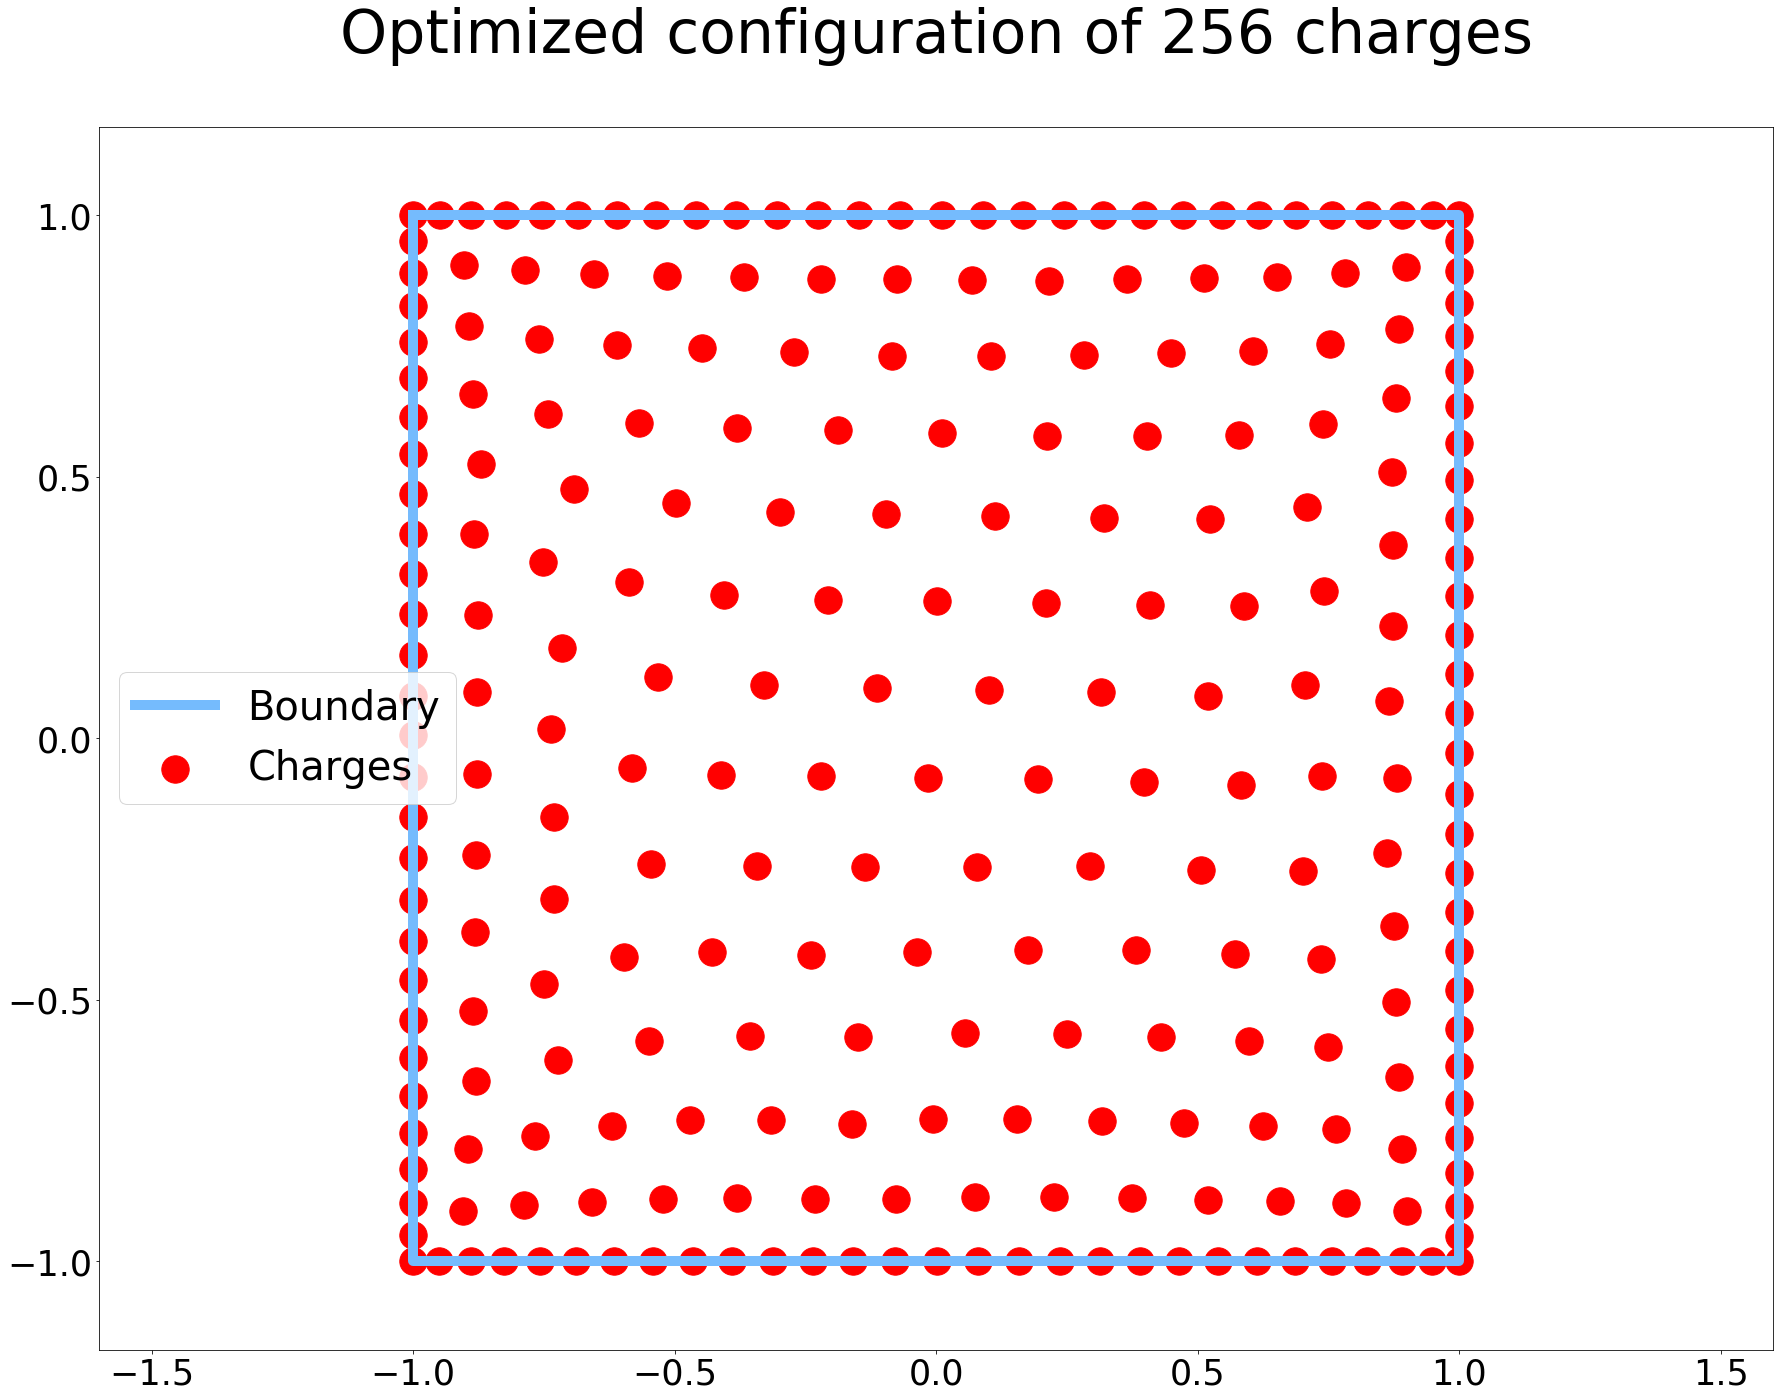

In [10]:
an.save_plot('Square256C098')

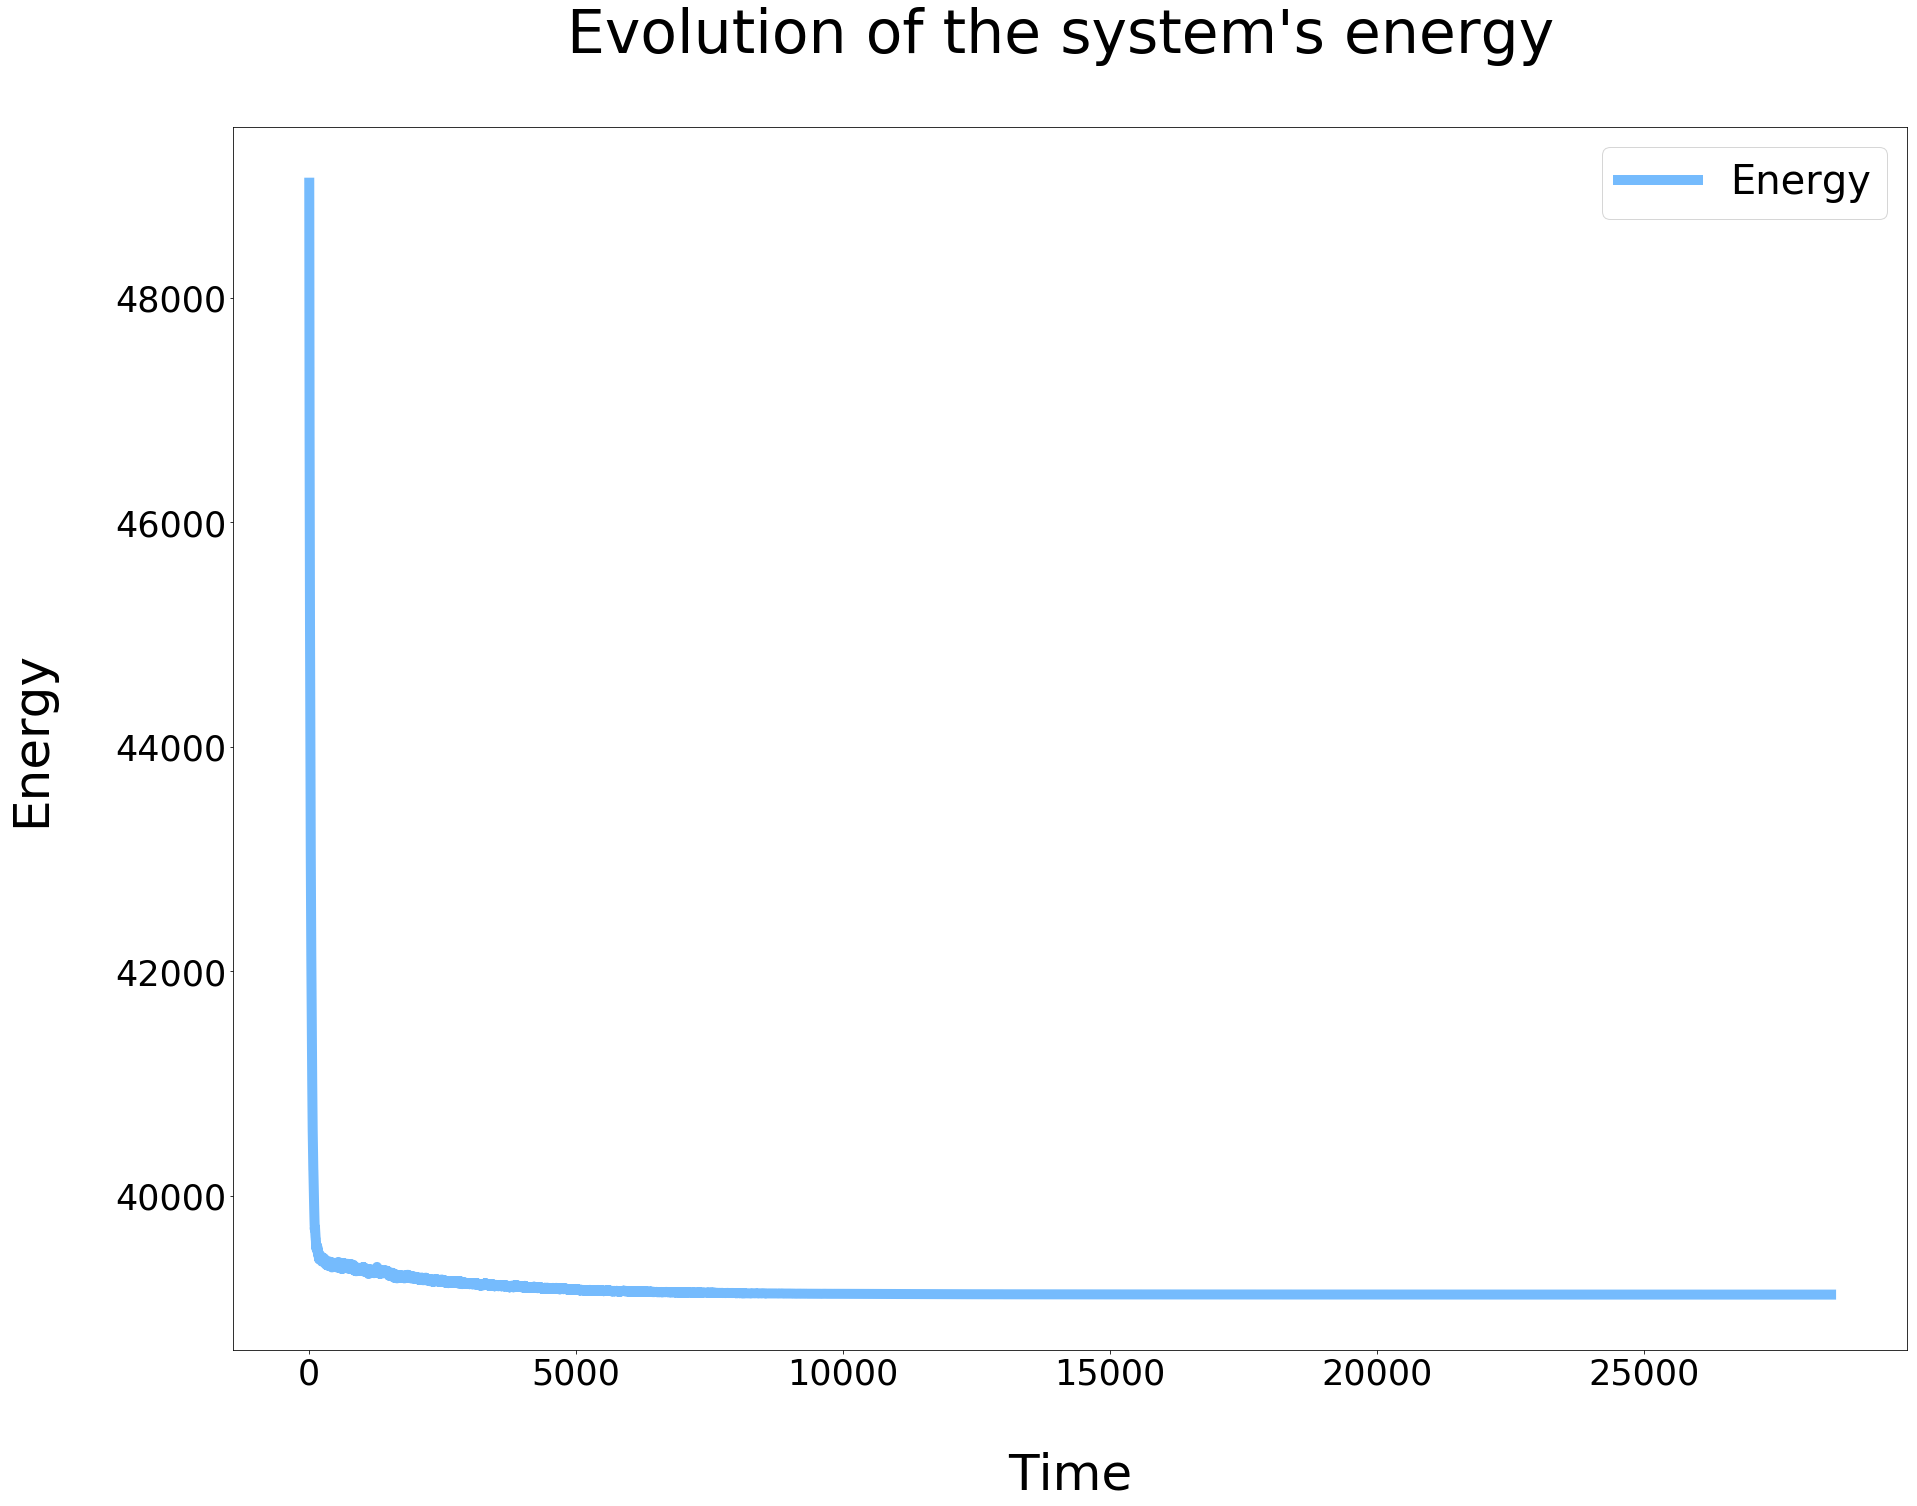

In [11]:
an.save_energies('Square256C098Energy')

In [9]:
an.energies[-1]

39122.17387092211

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

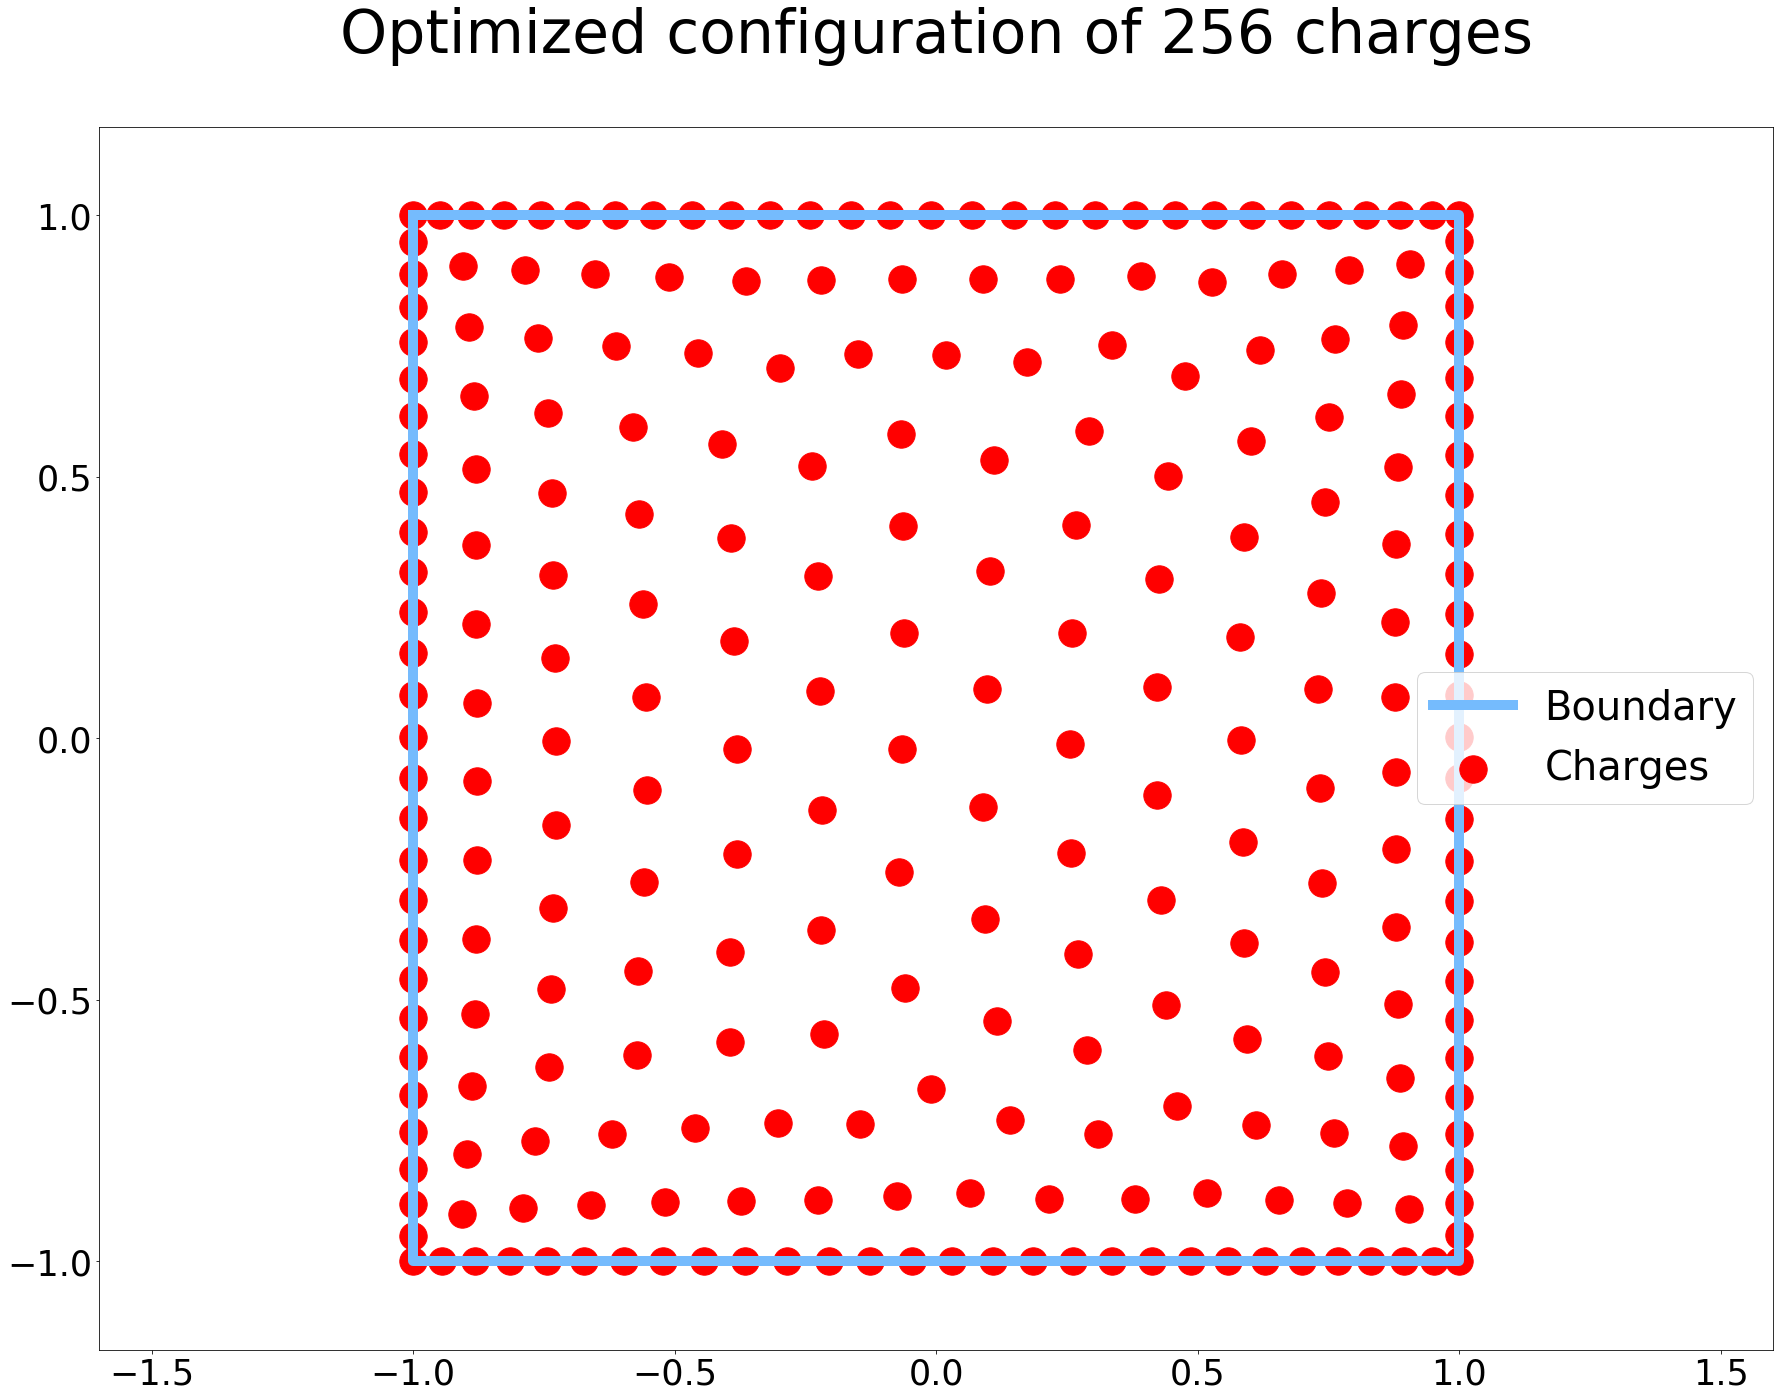

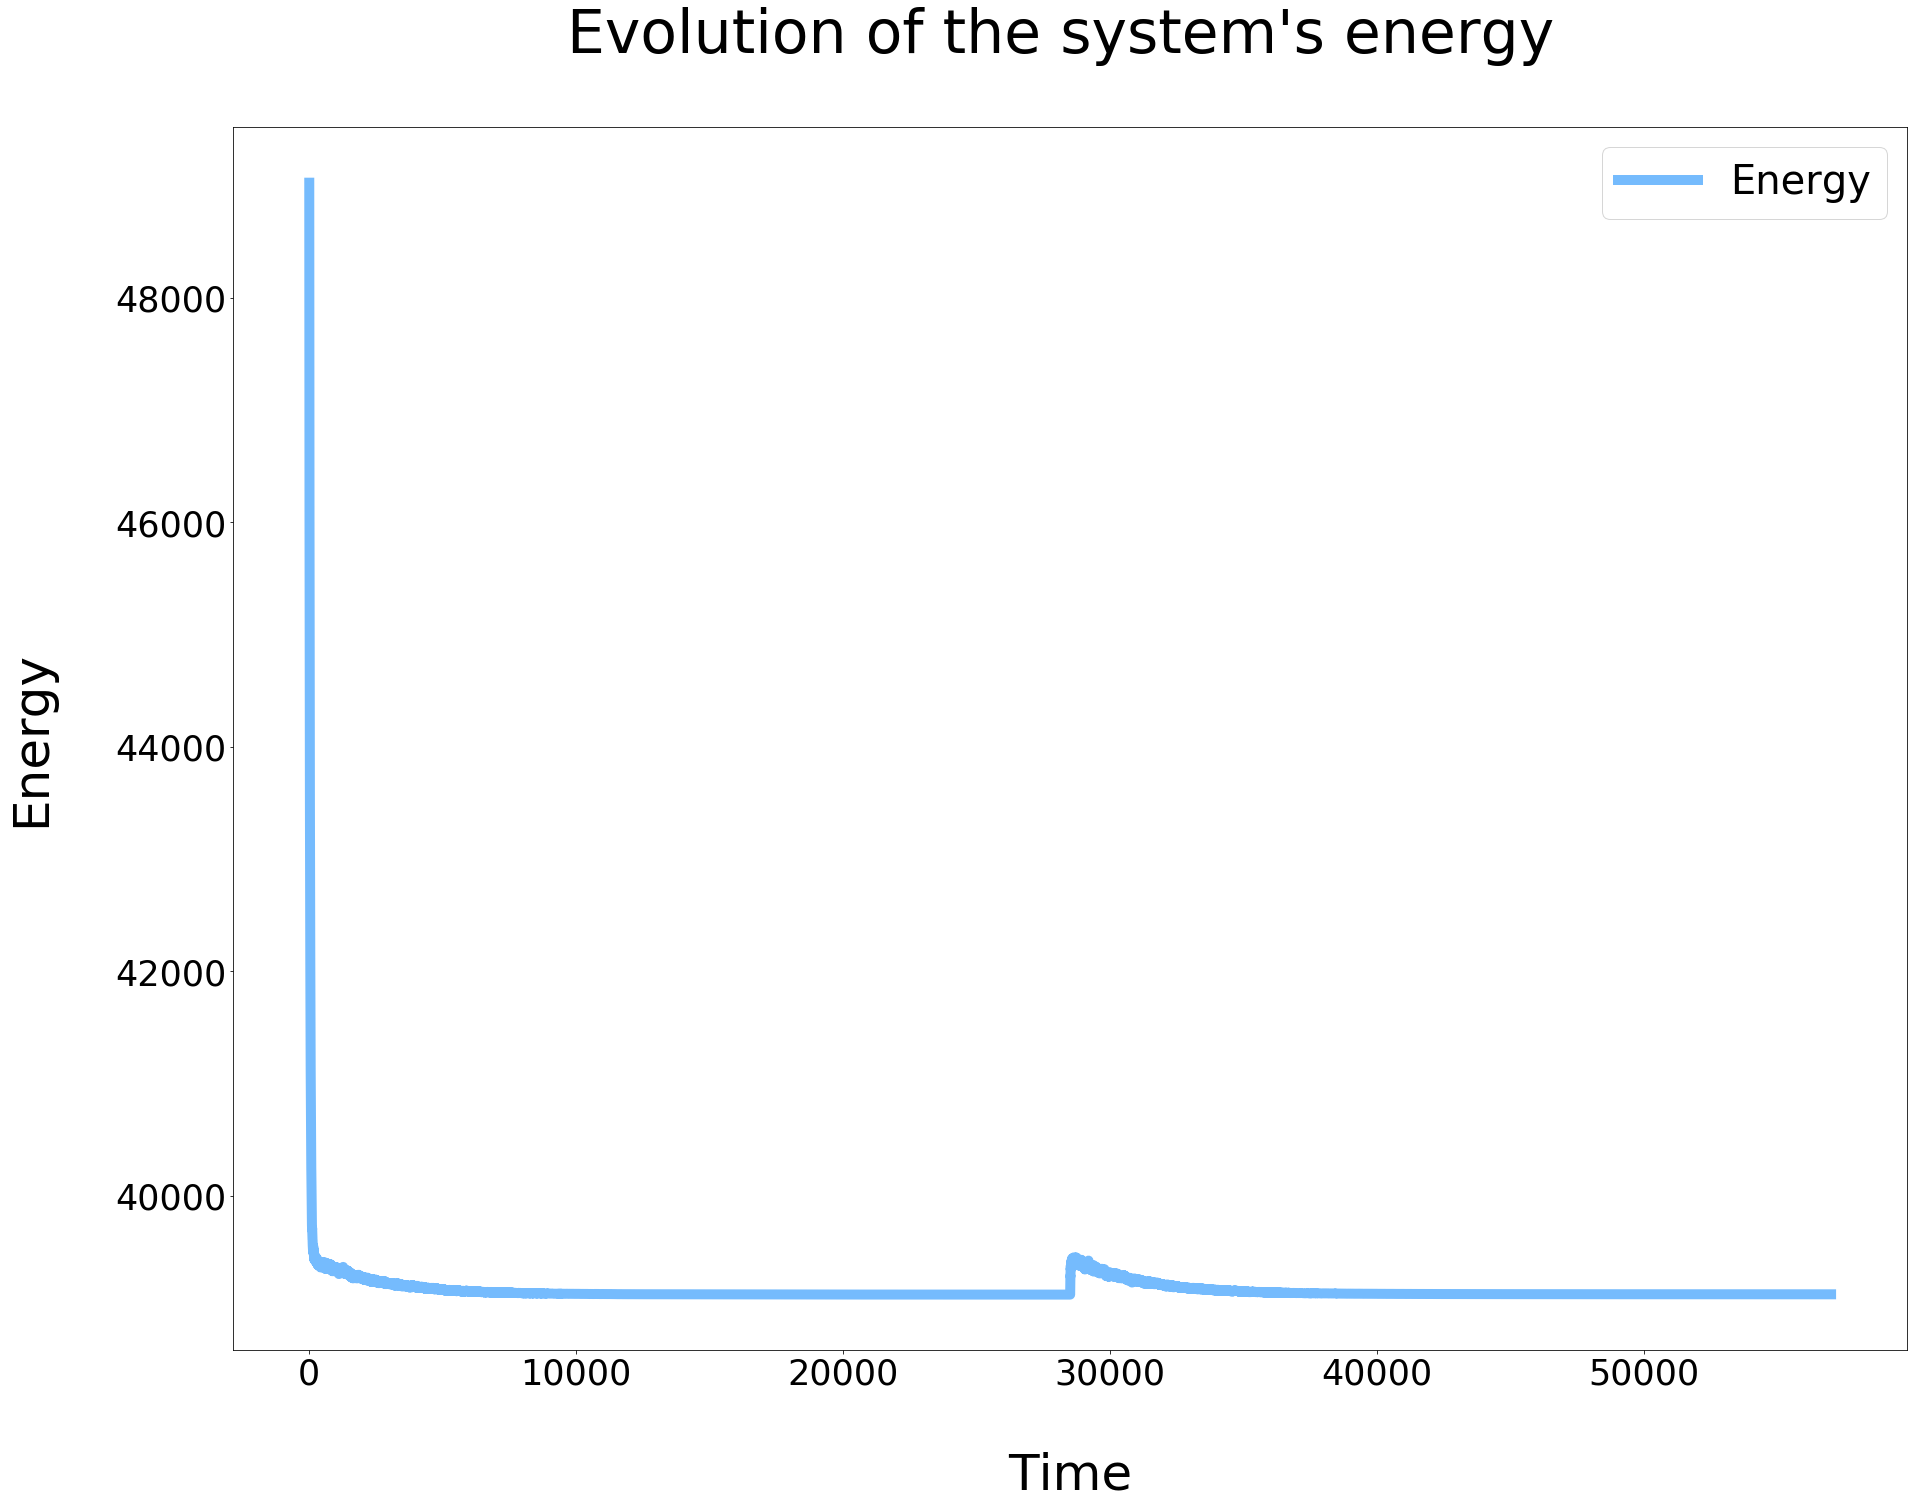

39124.853593797408

In [17]:
an.freeze()
an.save_plot('Square256C098v2')
an.save_energies('Square256C098Energyv2')
an.energies[-1]

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

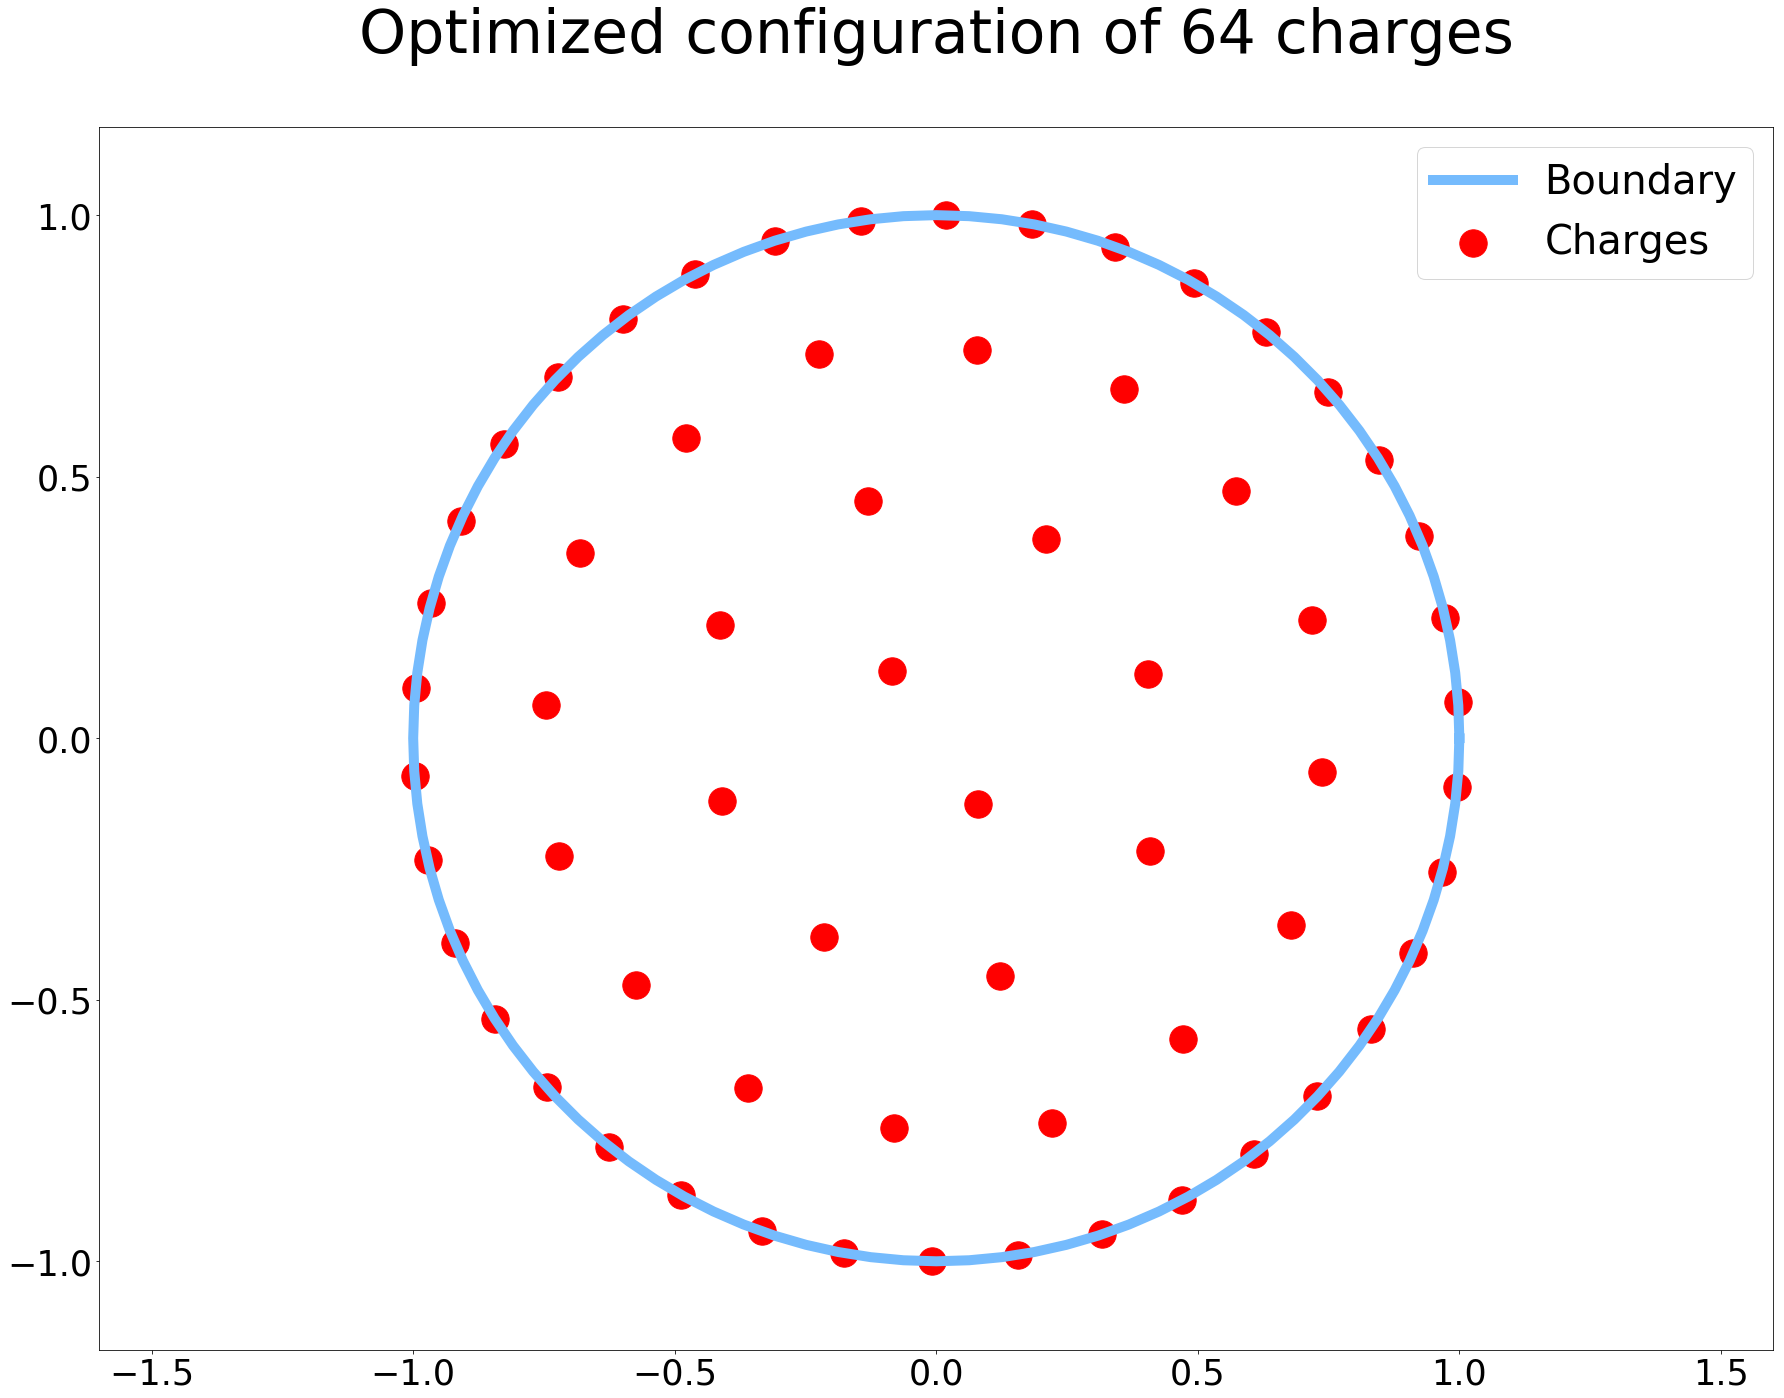

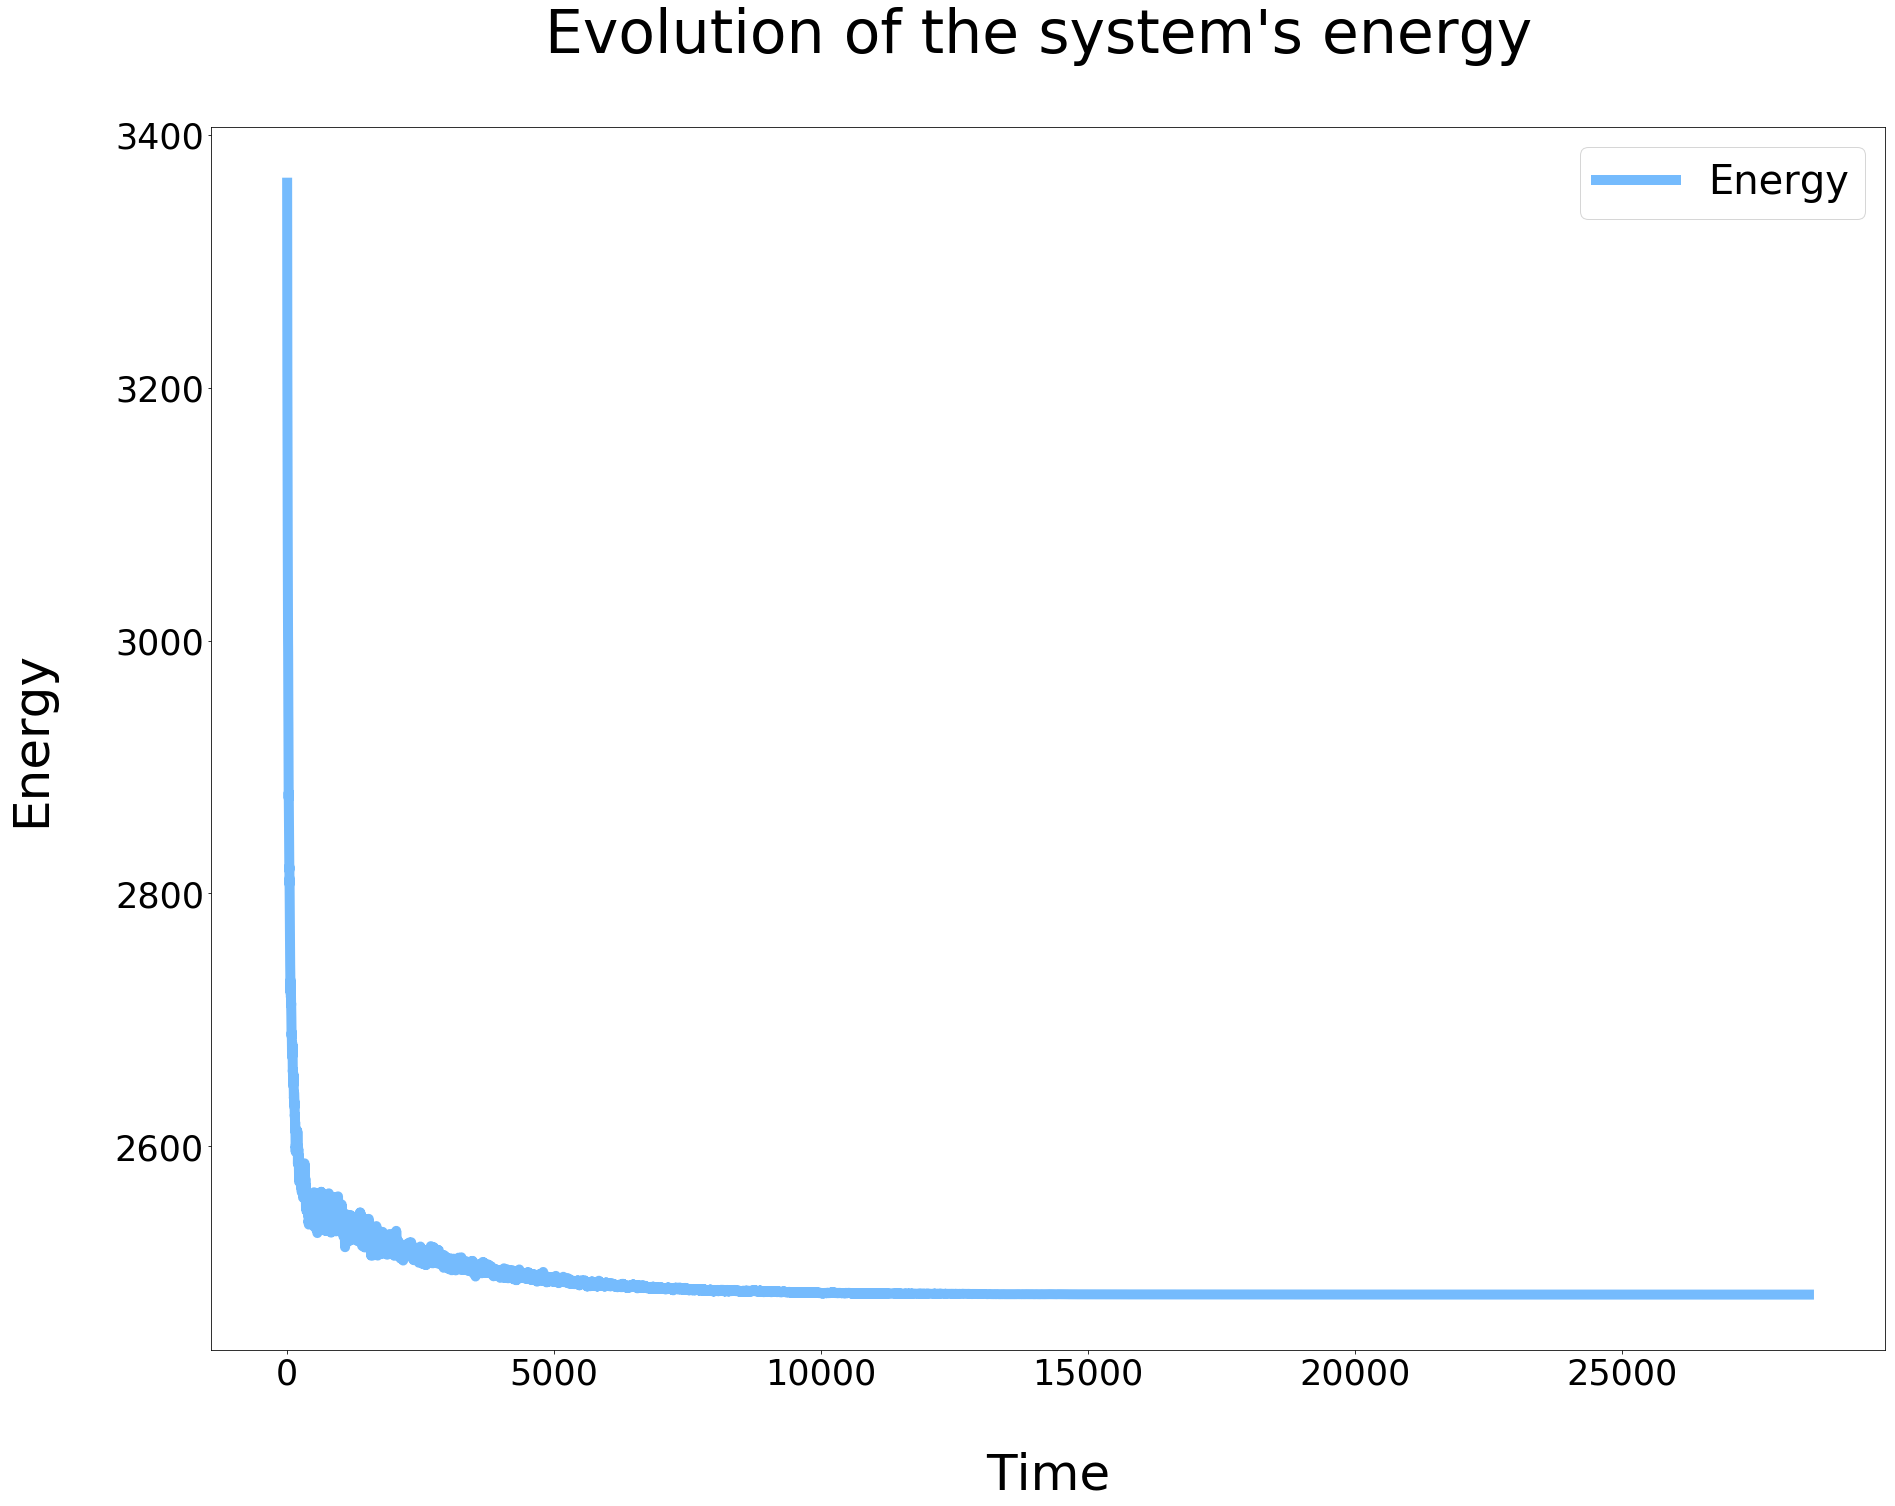

In [12]:
an2 = Annealer(64, 1, 10**-5, 0.98, 50, 0.02, 1, 'circle')
an2.freeze()
an2.save_plot('Circle64C098')
an2.save_energies('Circle64C098Energy')

In [13]:
an2.energies[-1]

2482.691459370581

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

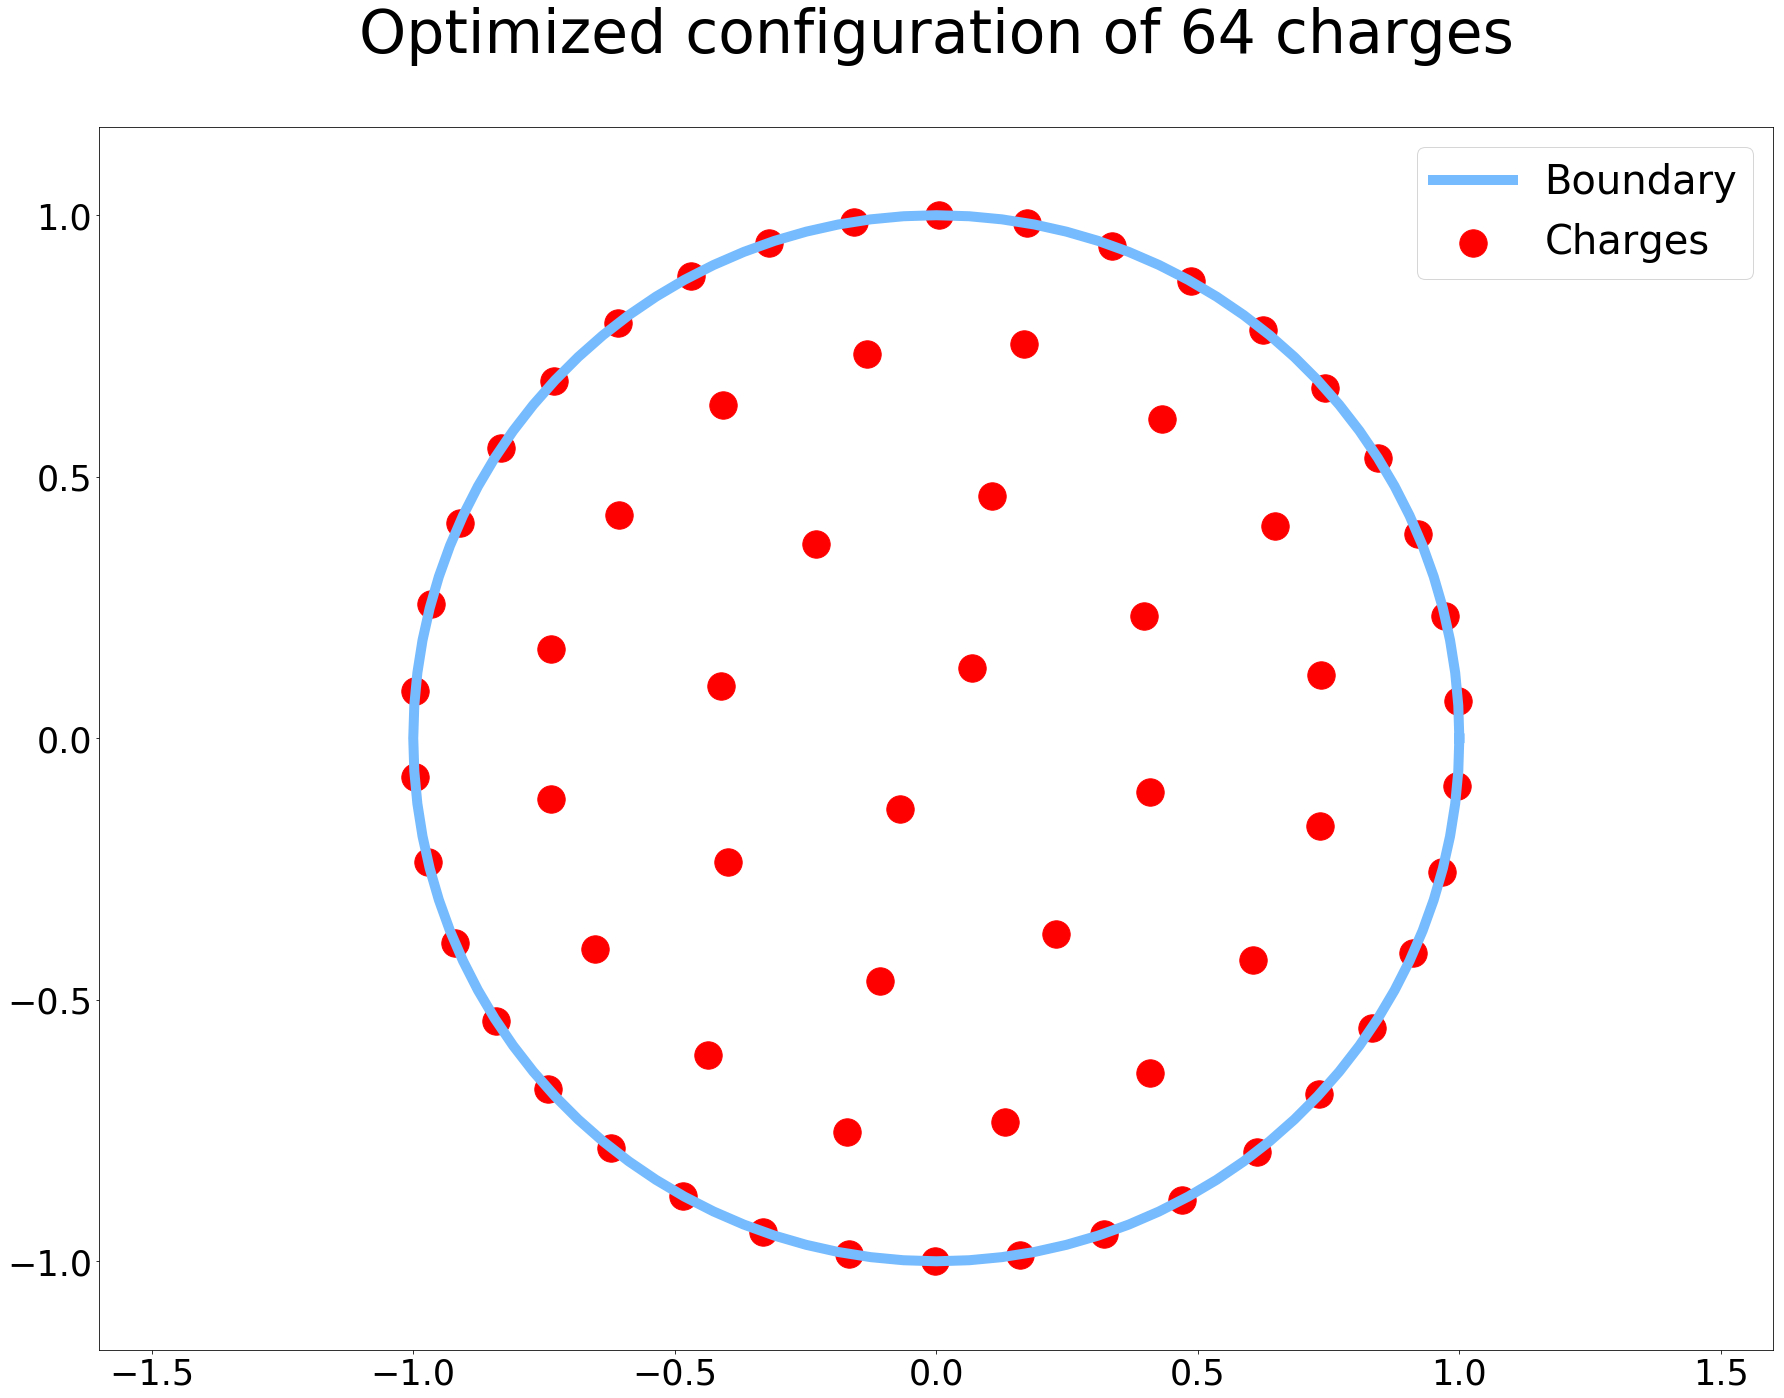

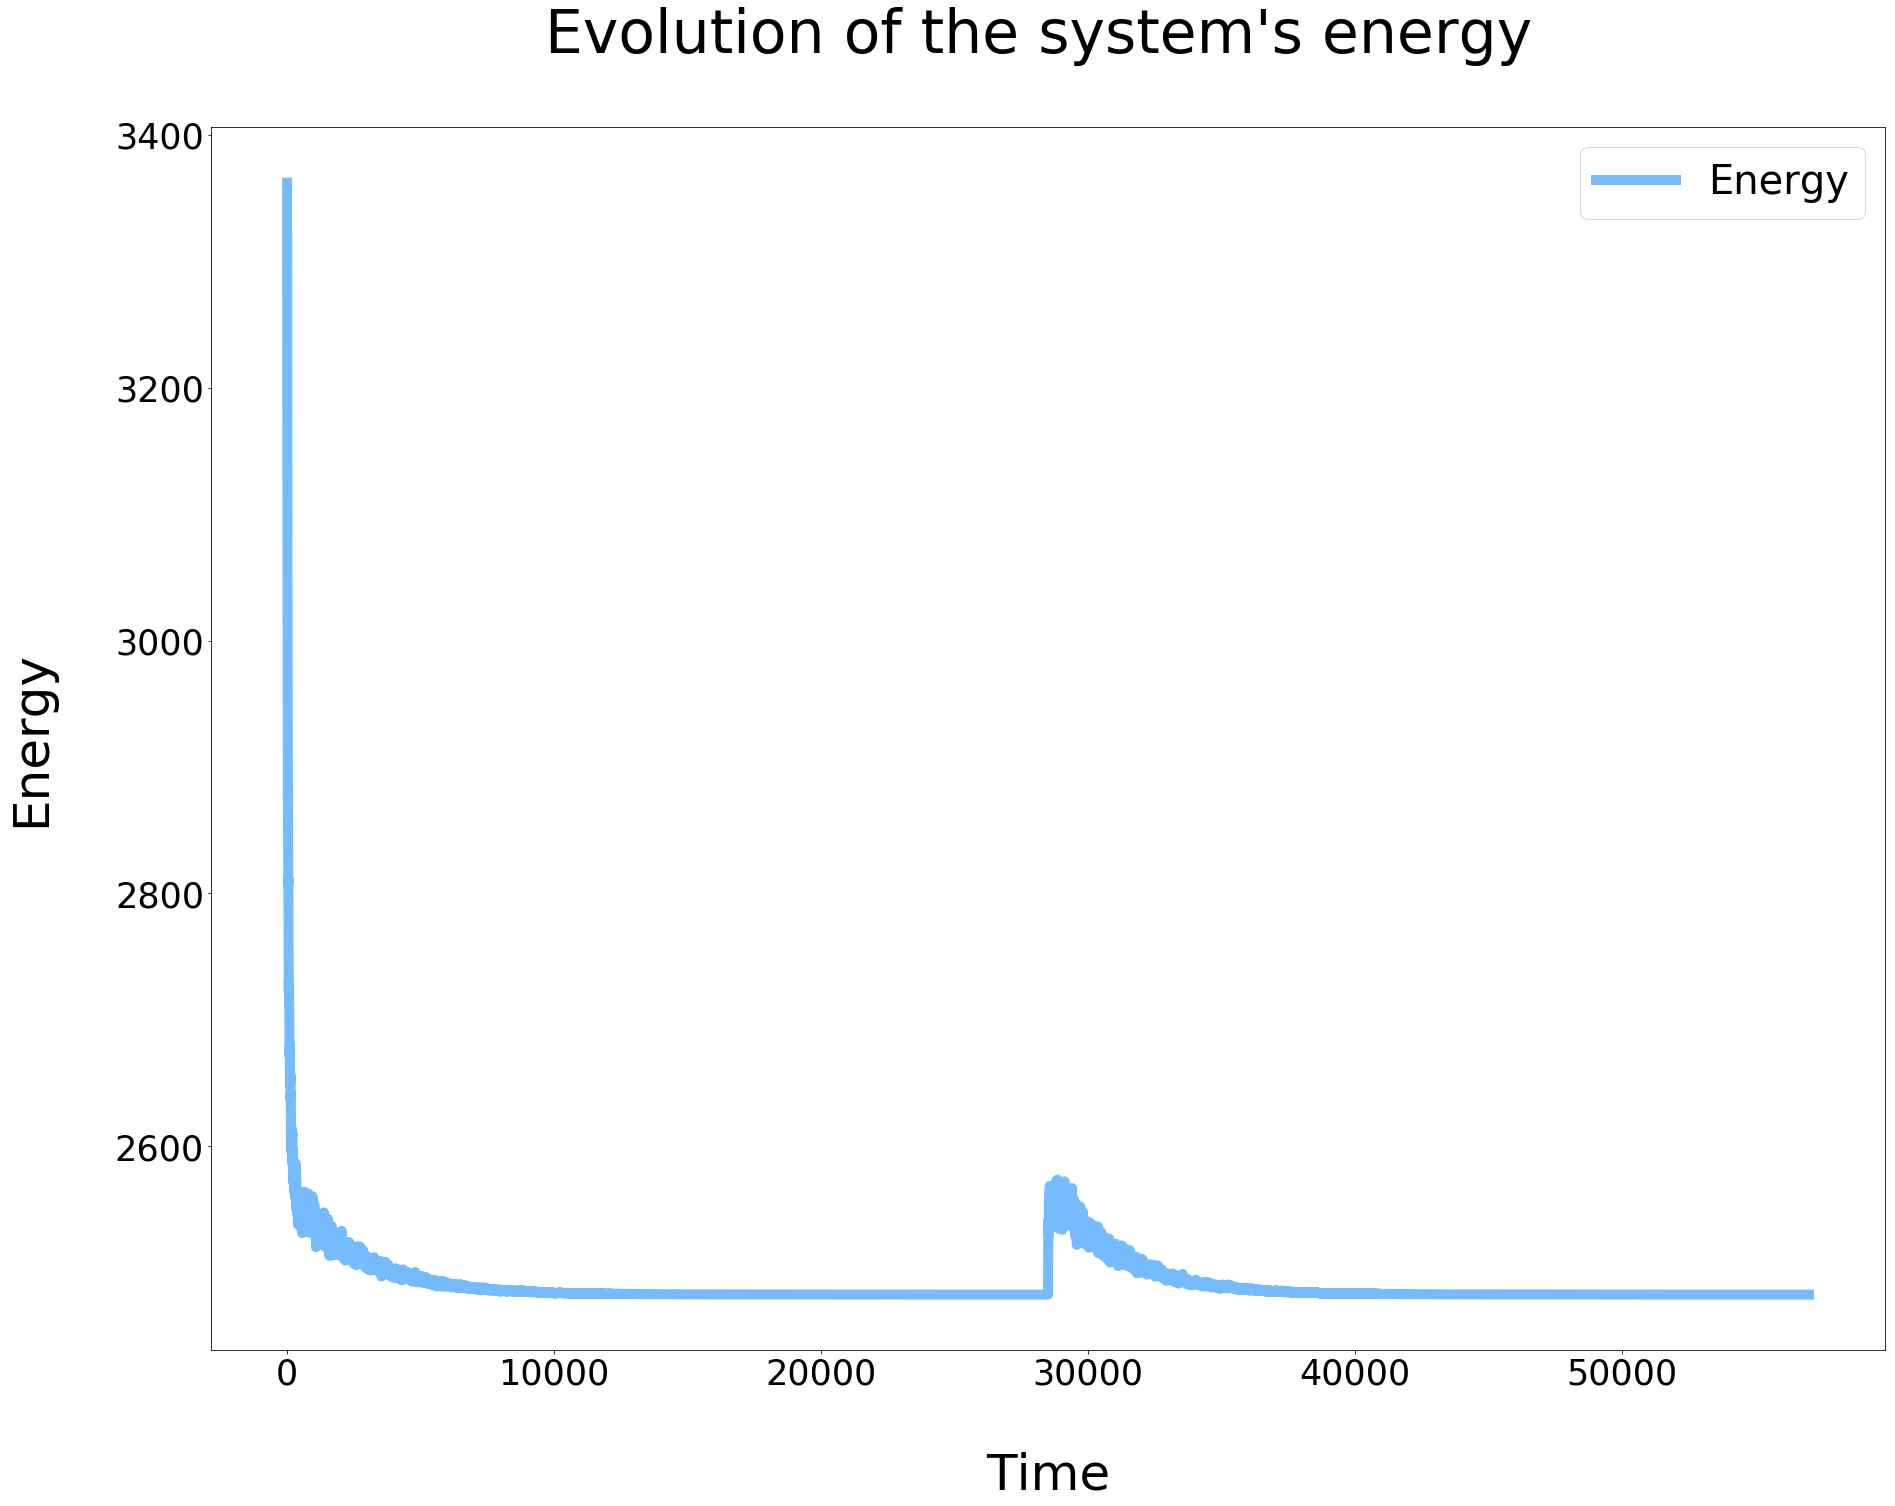

In [14]:
an2.freeze()
an2.save_plot('Circle64C098v2')
an2.save_energies('Circle64C098Energyv2')

In [15]:
an2.energies[-1]

2482.6923001932678

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

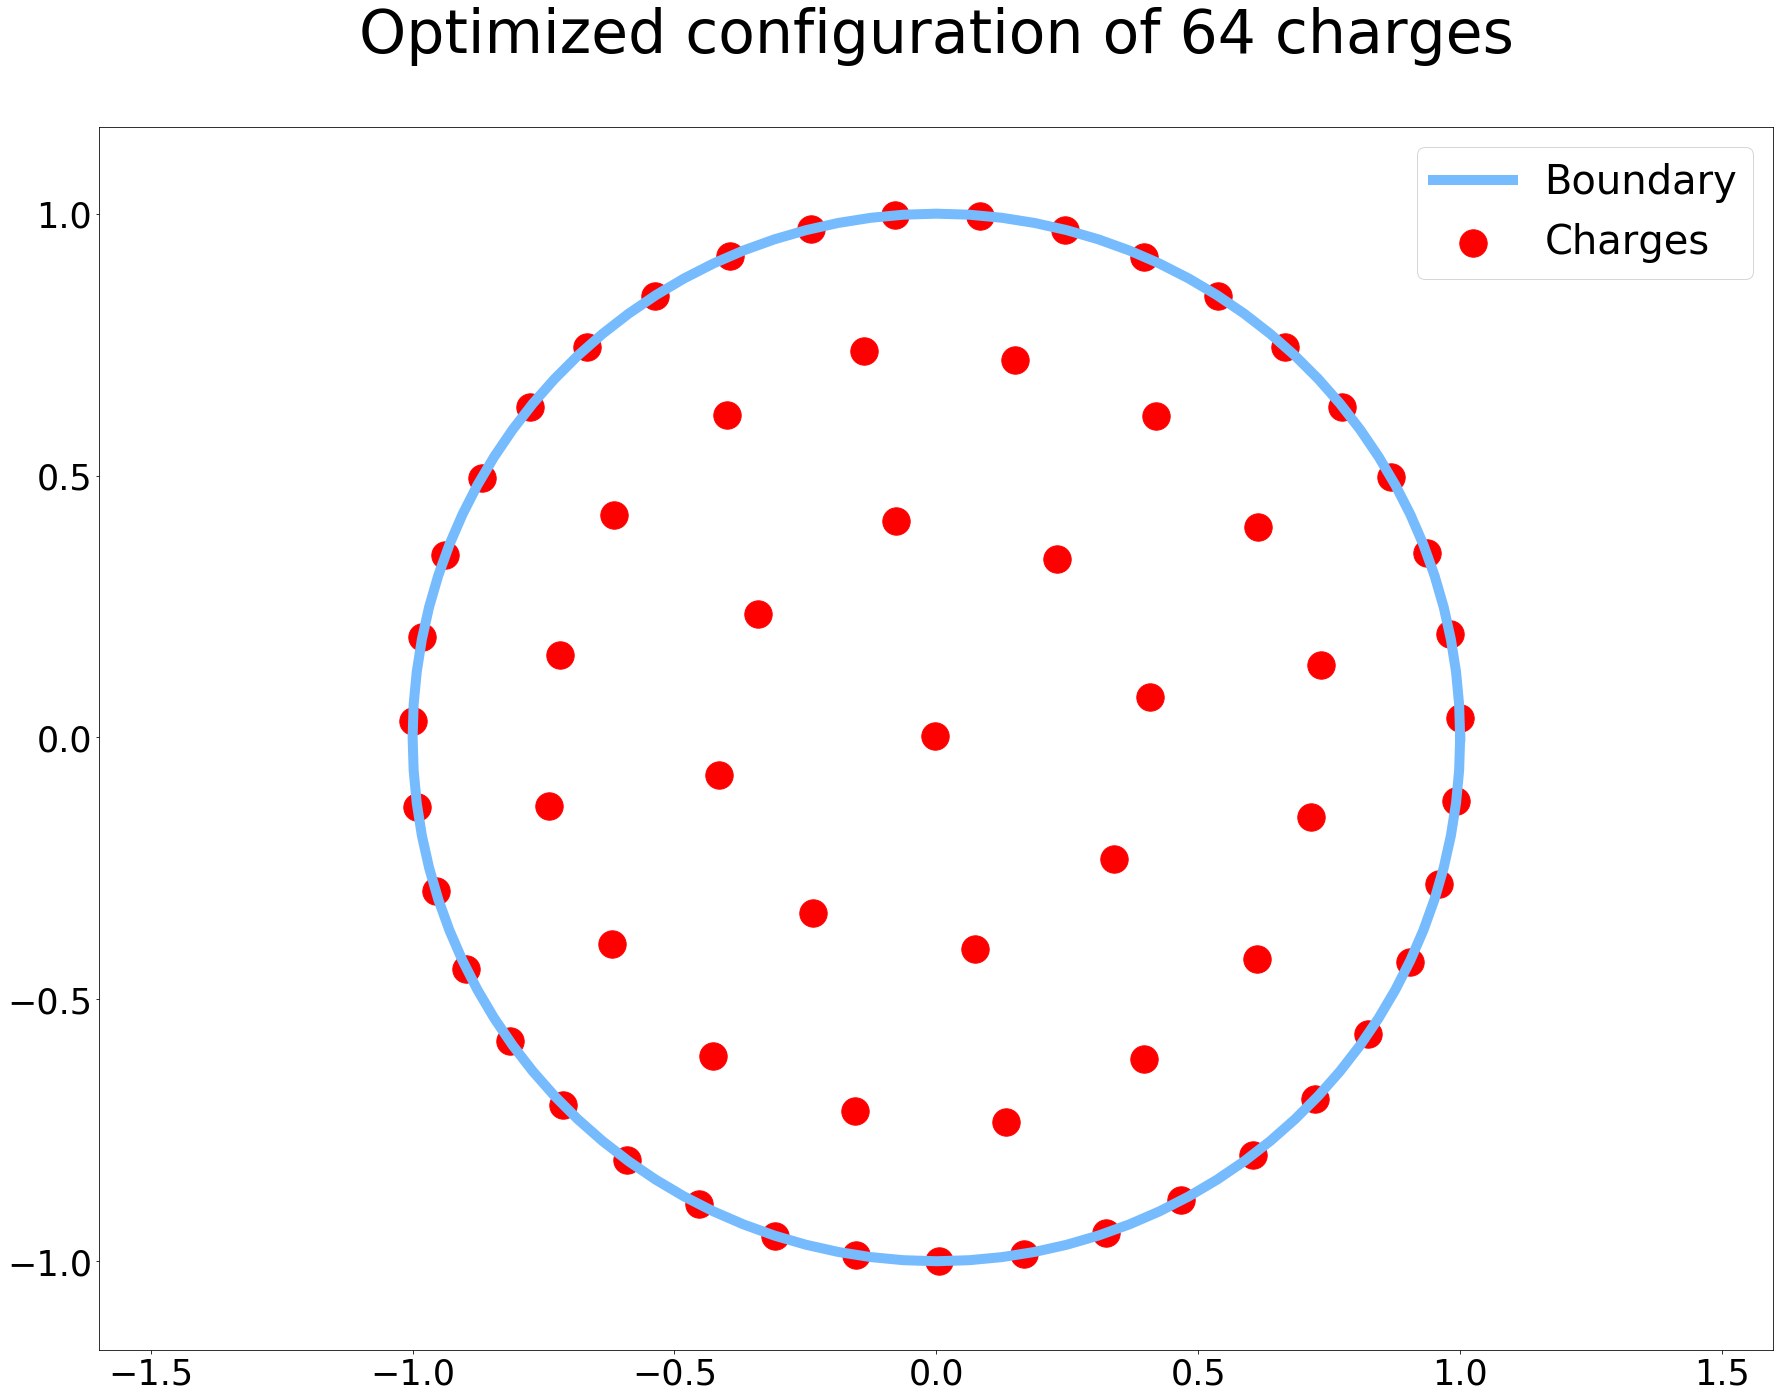

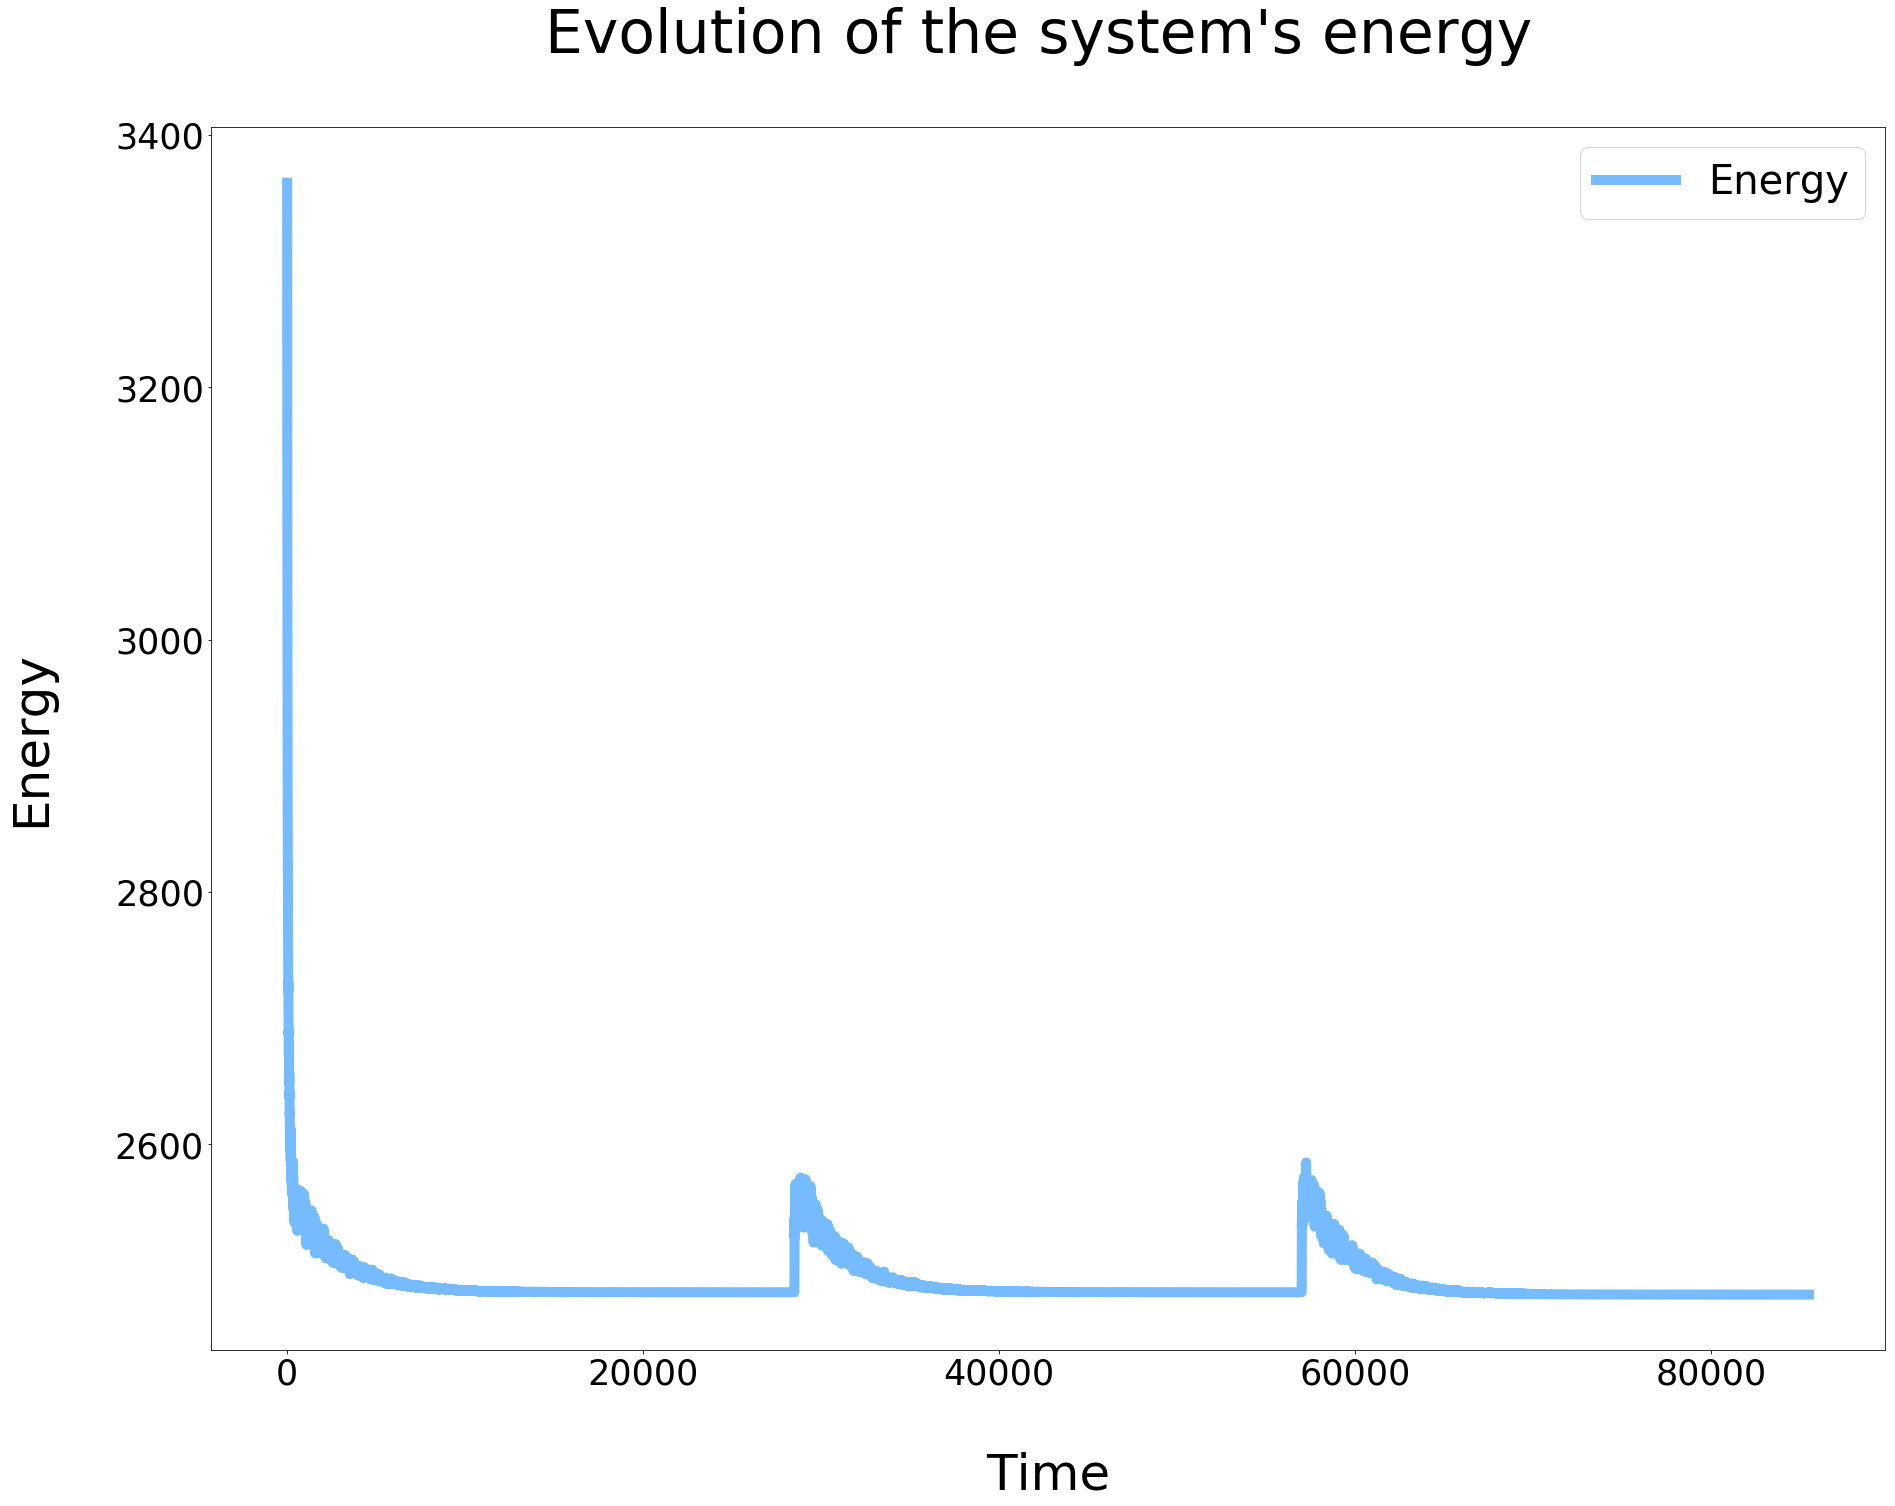

2480.8307850048609

In [16]:
an2.freeze()
an2.save_plot('Circle64C098v2')
an2.save_energies('Circle64C098Energyv2')
an2.energies[-1]

In [5]:
an3 = Annealer(256, 1, 10**-5, 0.98, 50, 0.02, 1, 'square')

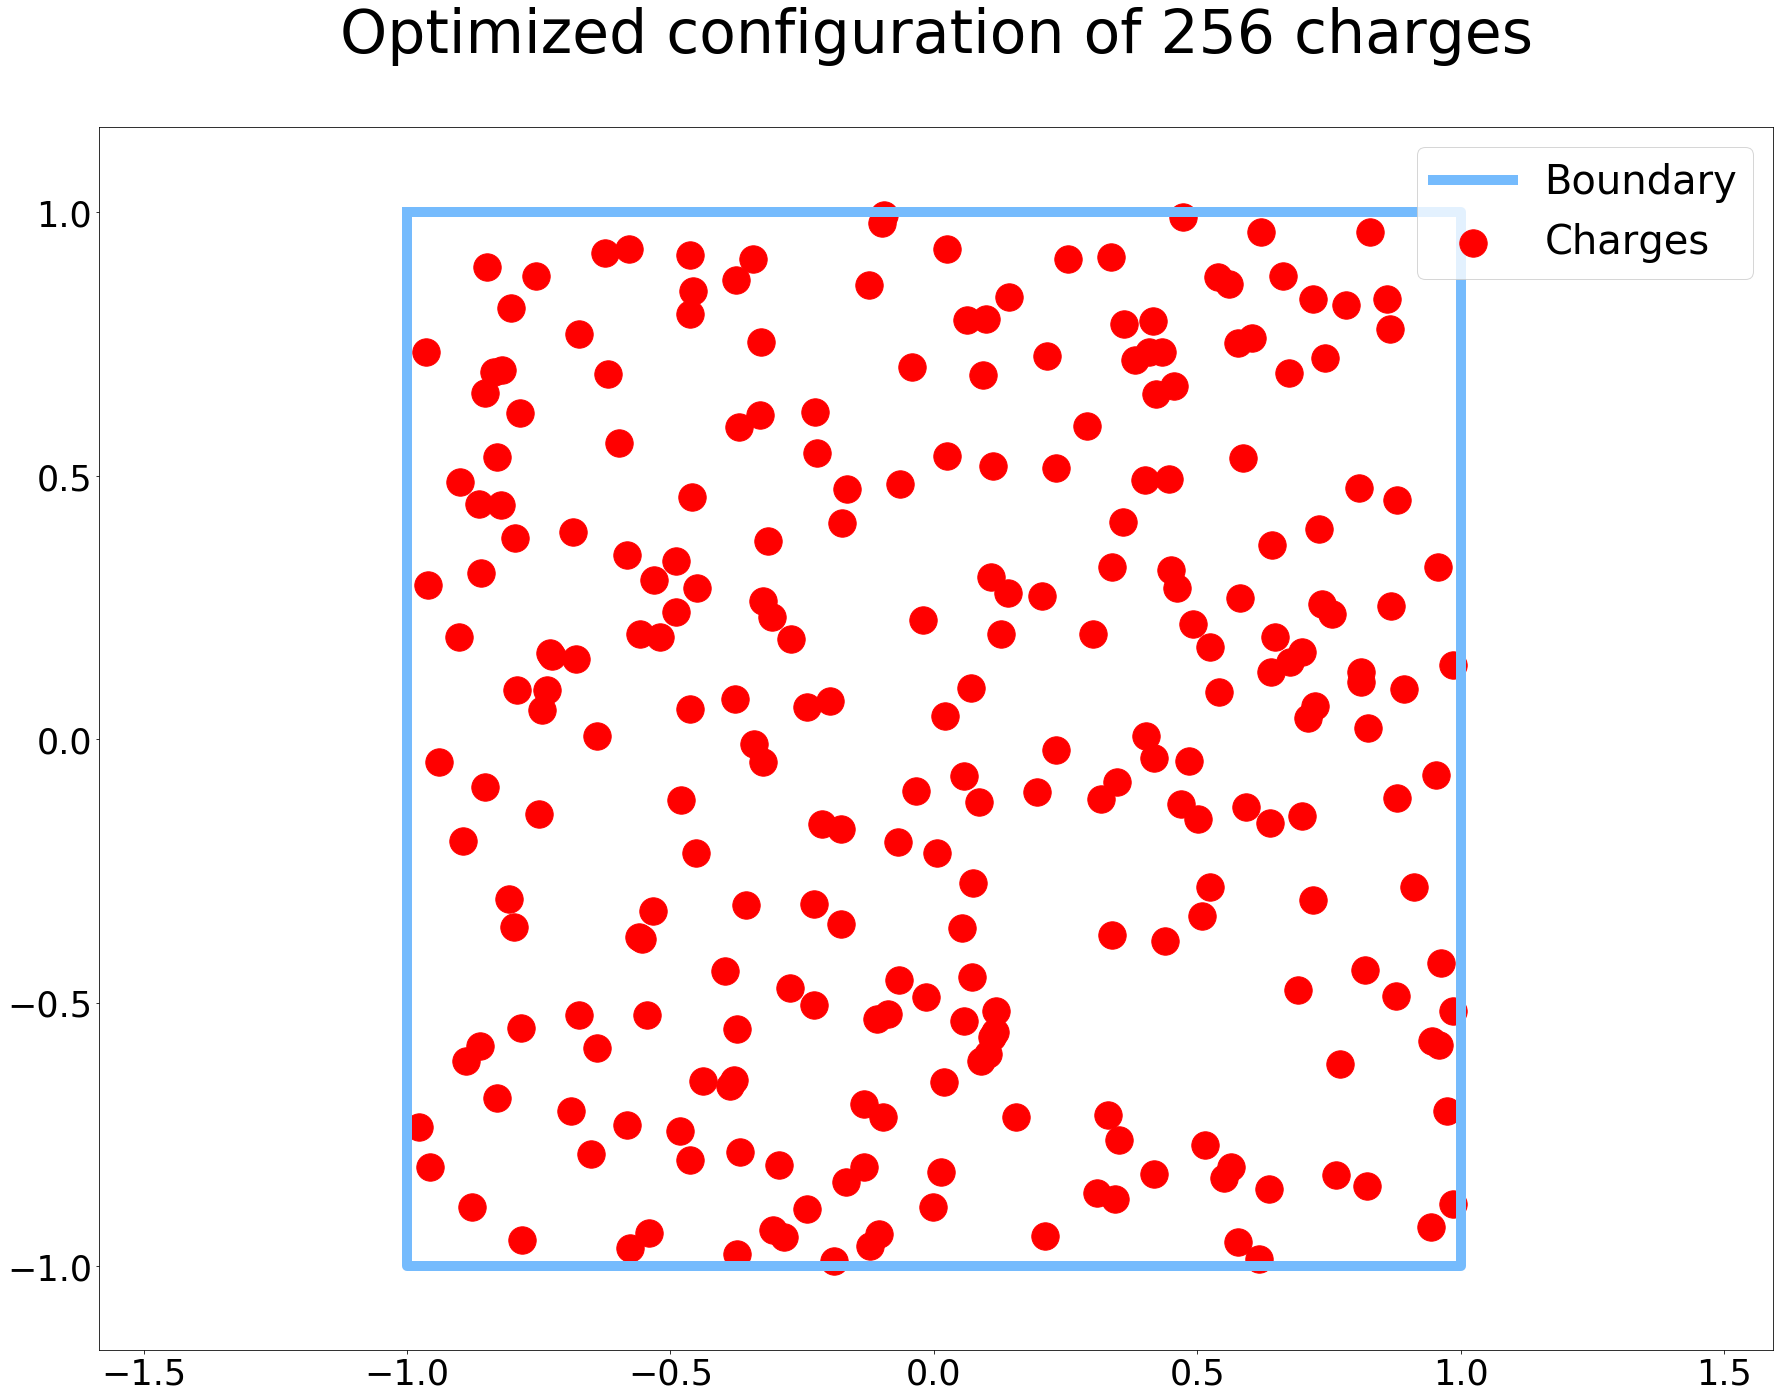

In [6]:
an3.save_plot('Square256Init')

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

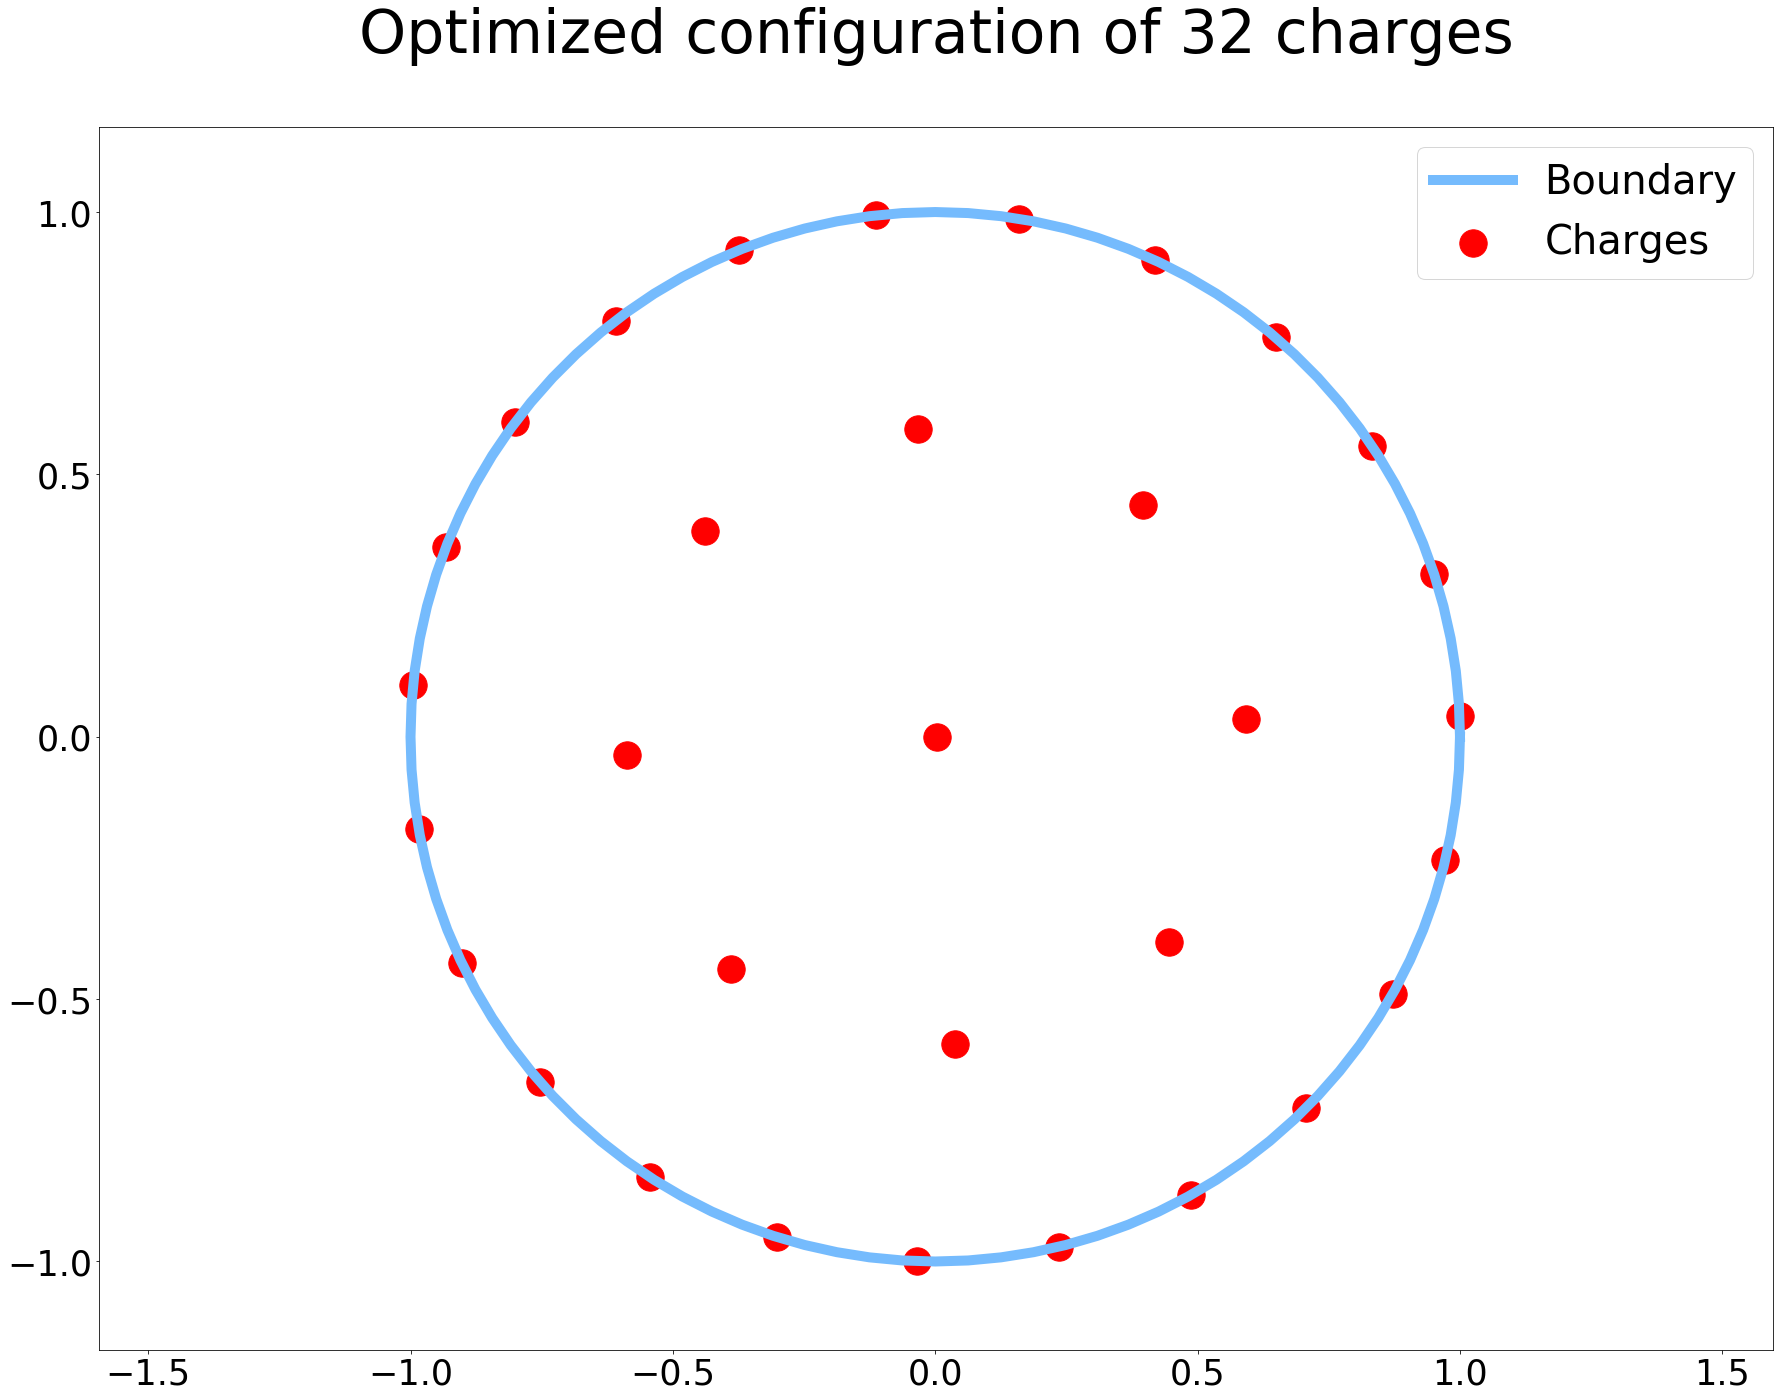

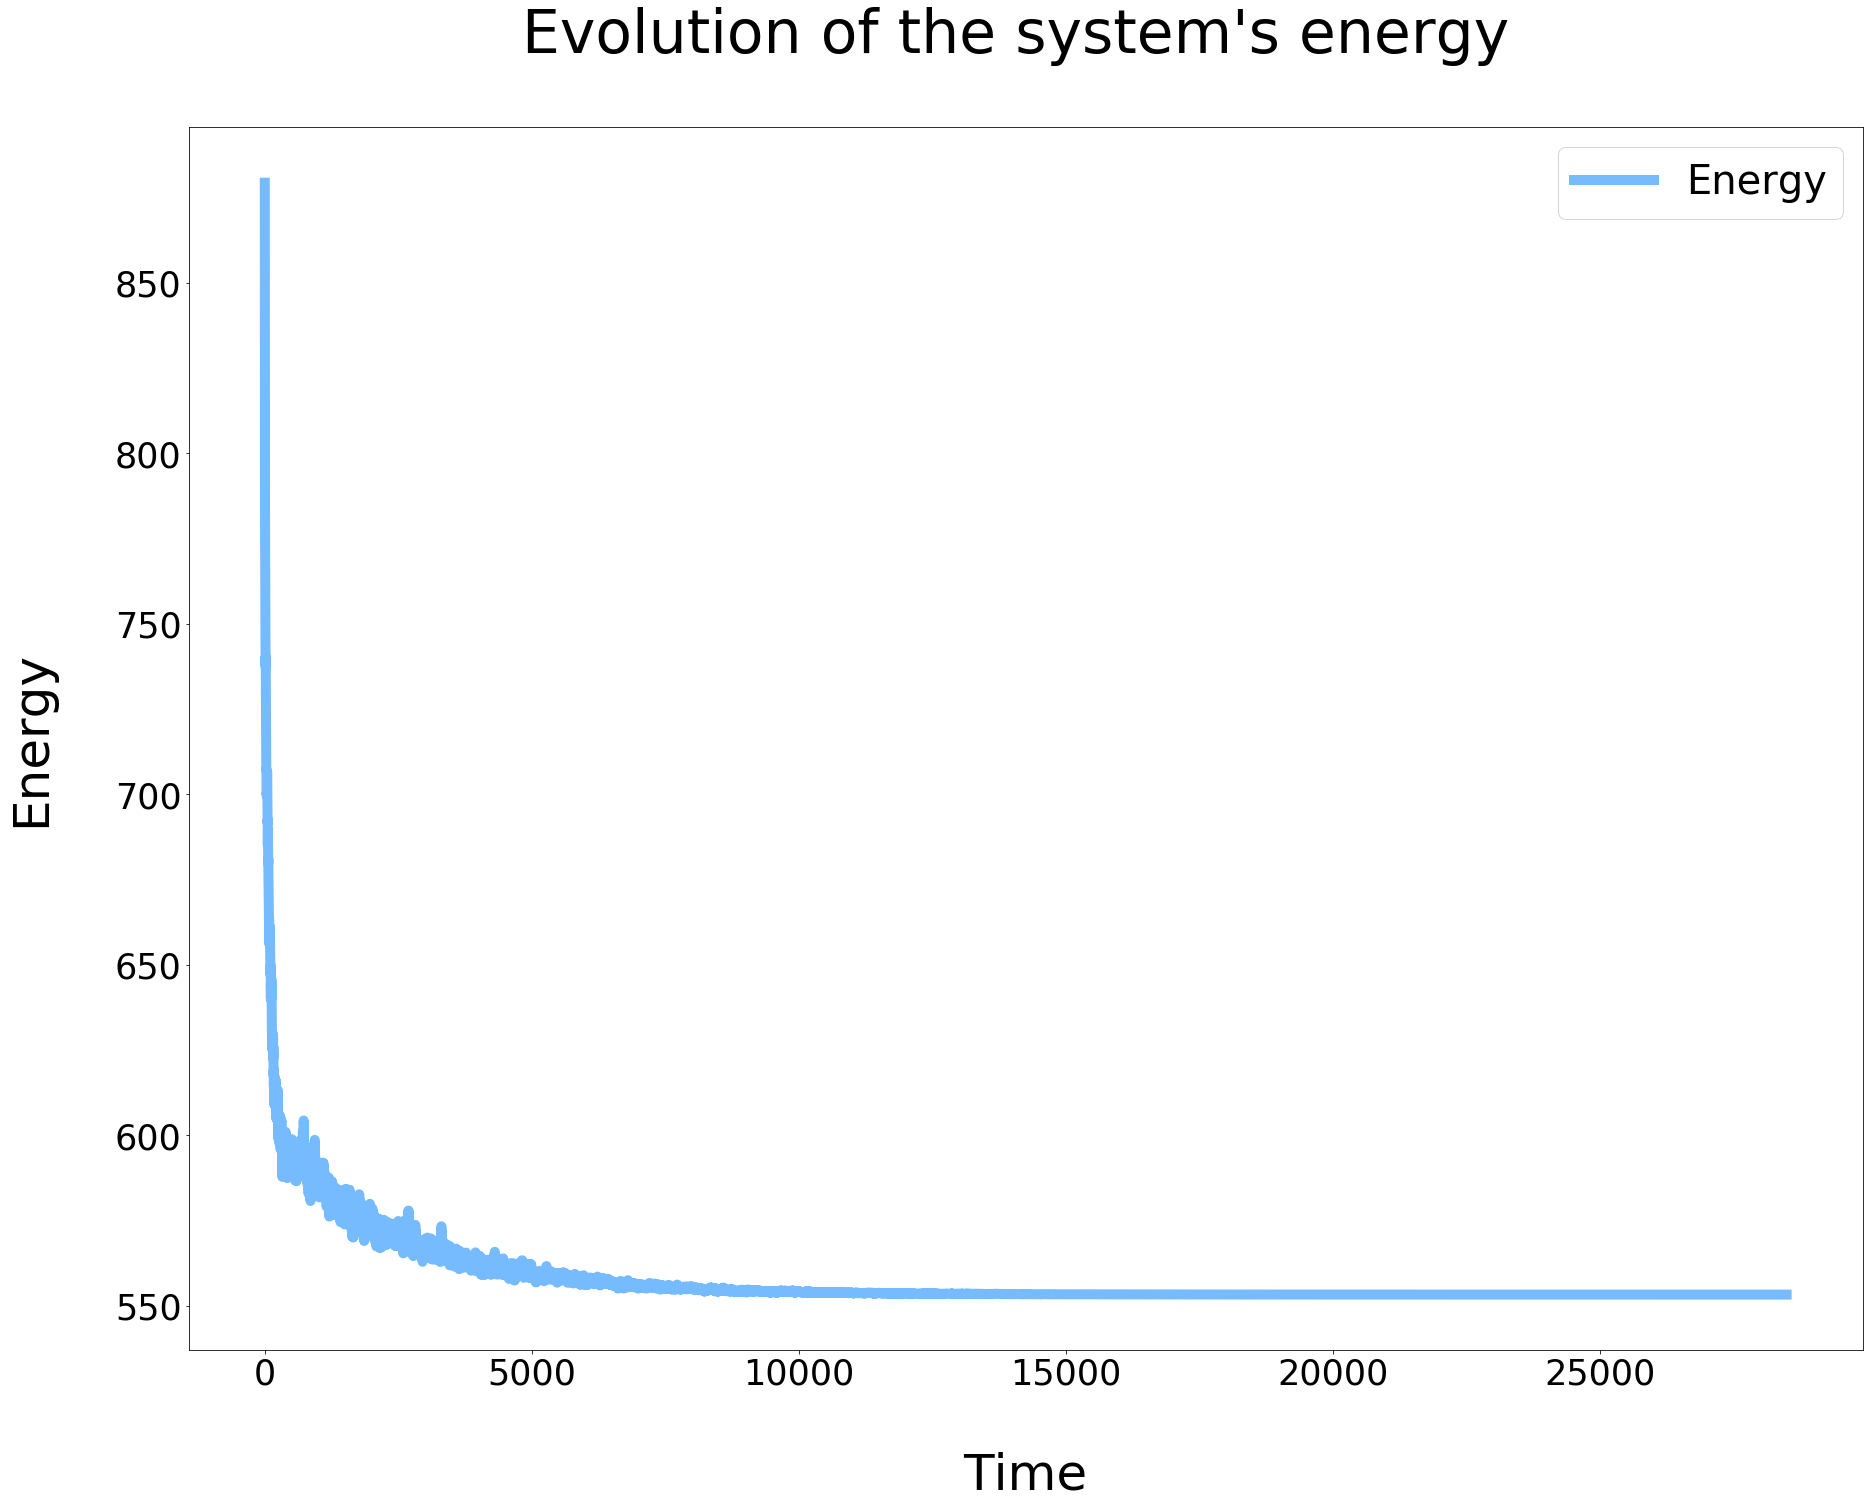

553.33199909386656

In [8]:
an4 = Annealer(32, 1, 10**-5, 0.98, 50, 0.02, 1, 'circle')
an4.freeze()
an4.save_plot('Circle32C098')
an4.save_energies('Circle32C098Energy')
an4.energies[-1]

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

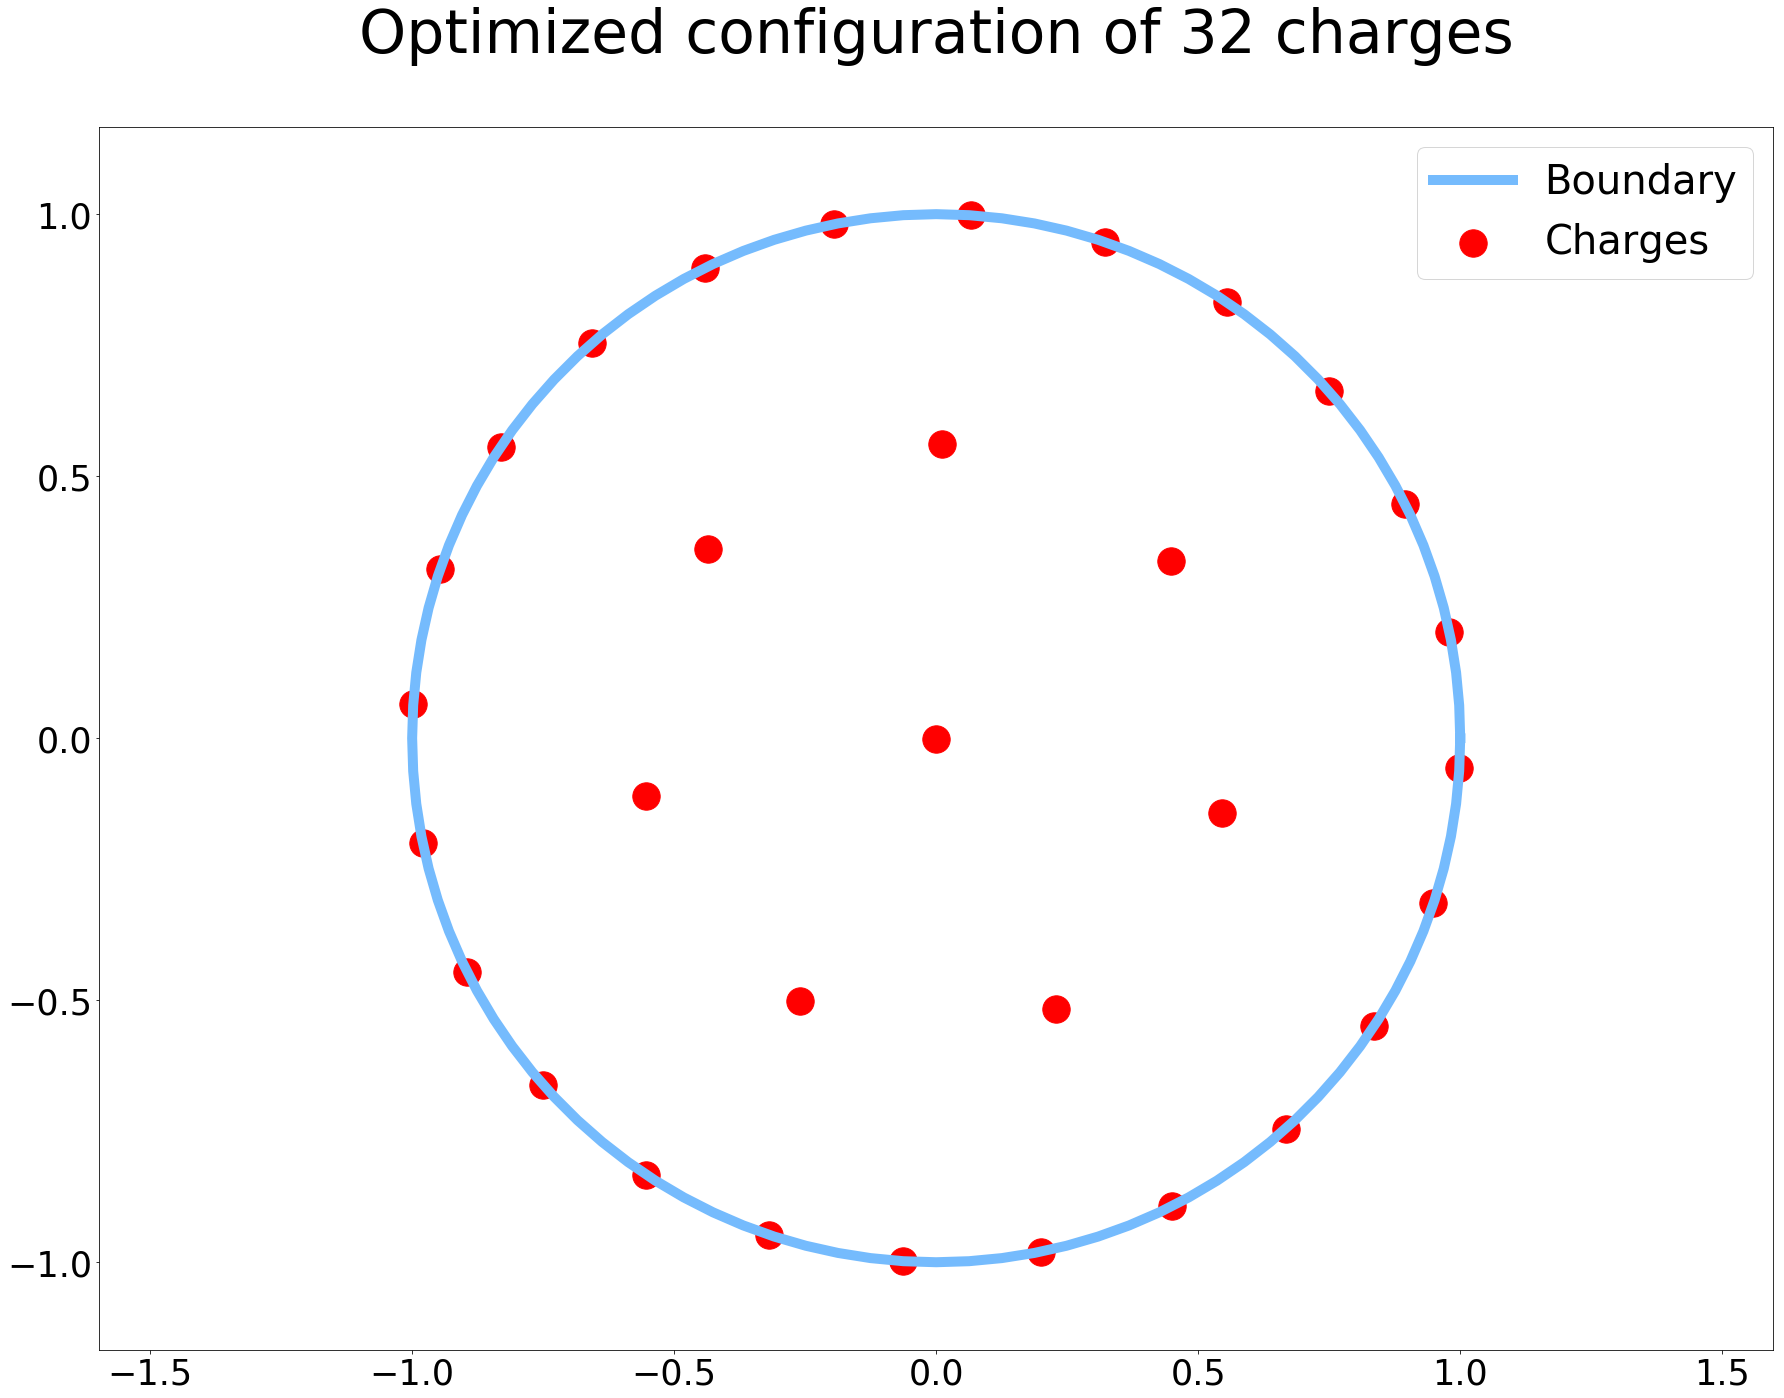

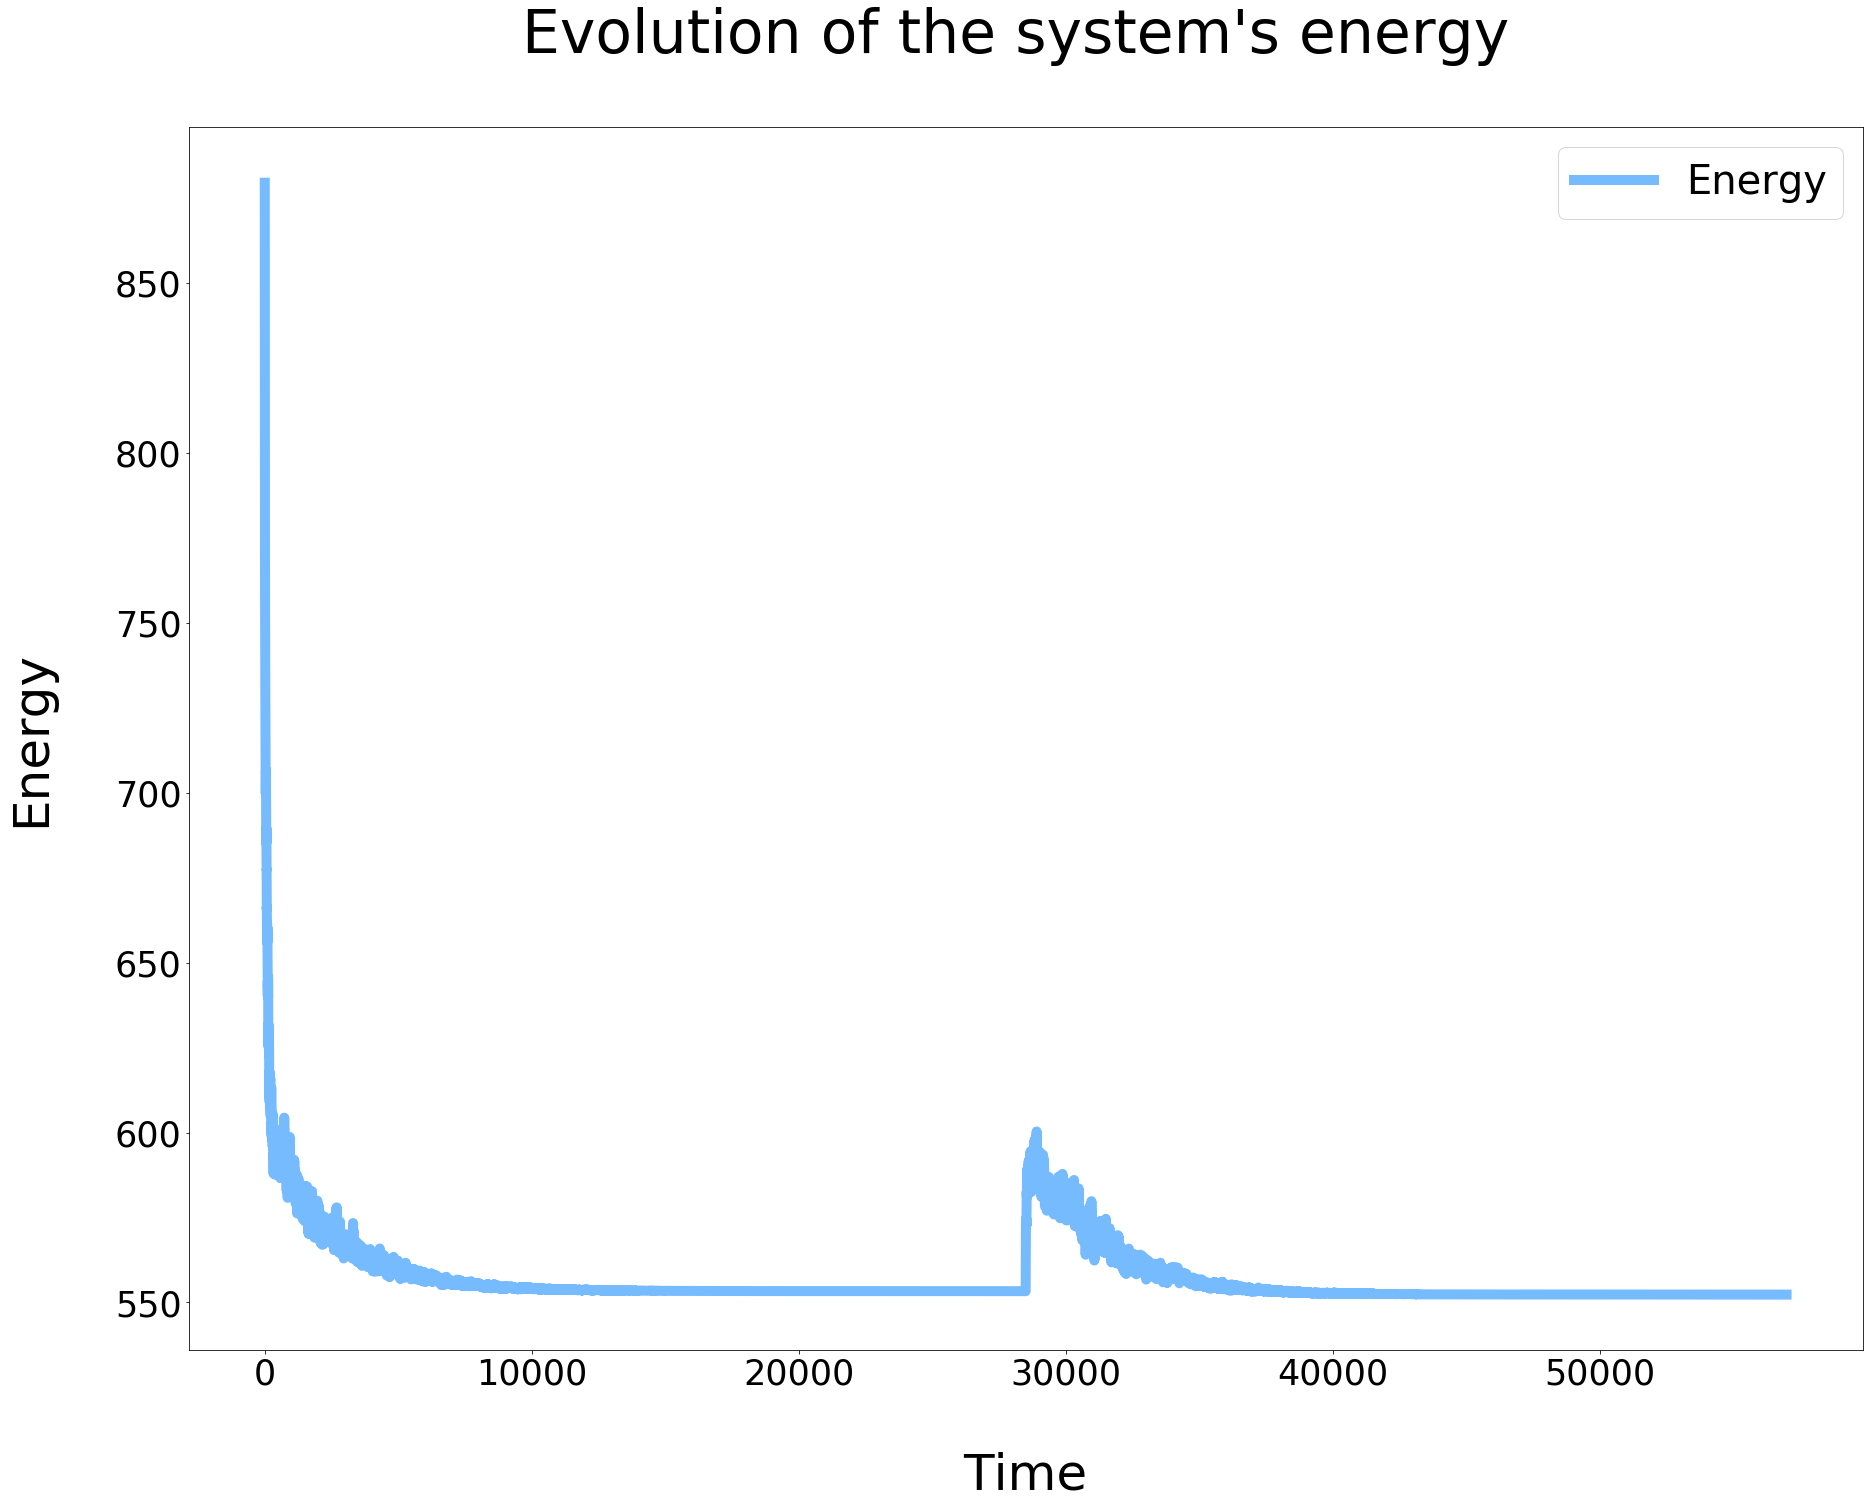

552.31930731100863

In [9]:
an4.freeze()
an4.save_plot('Circle32C098v2')
an4.save_energies('Circle32C098Energyv2')
an4.energies[-1]

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

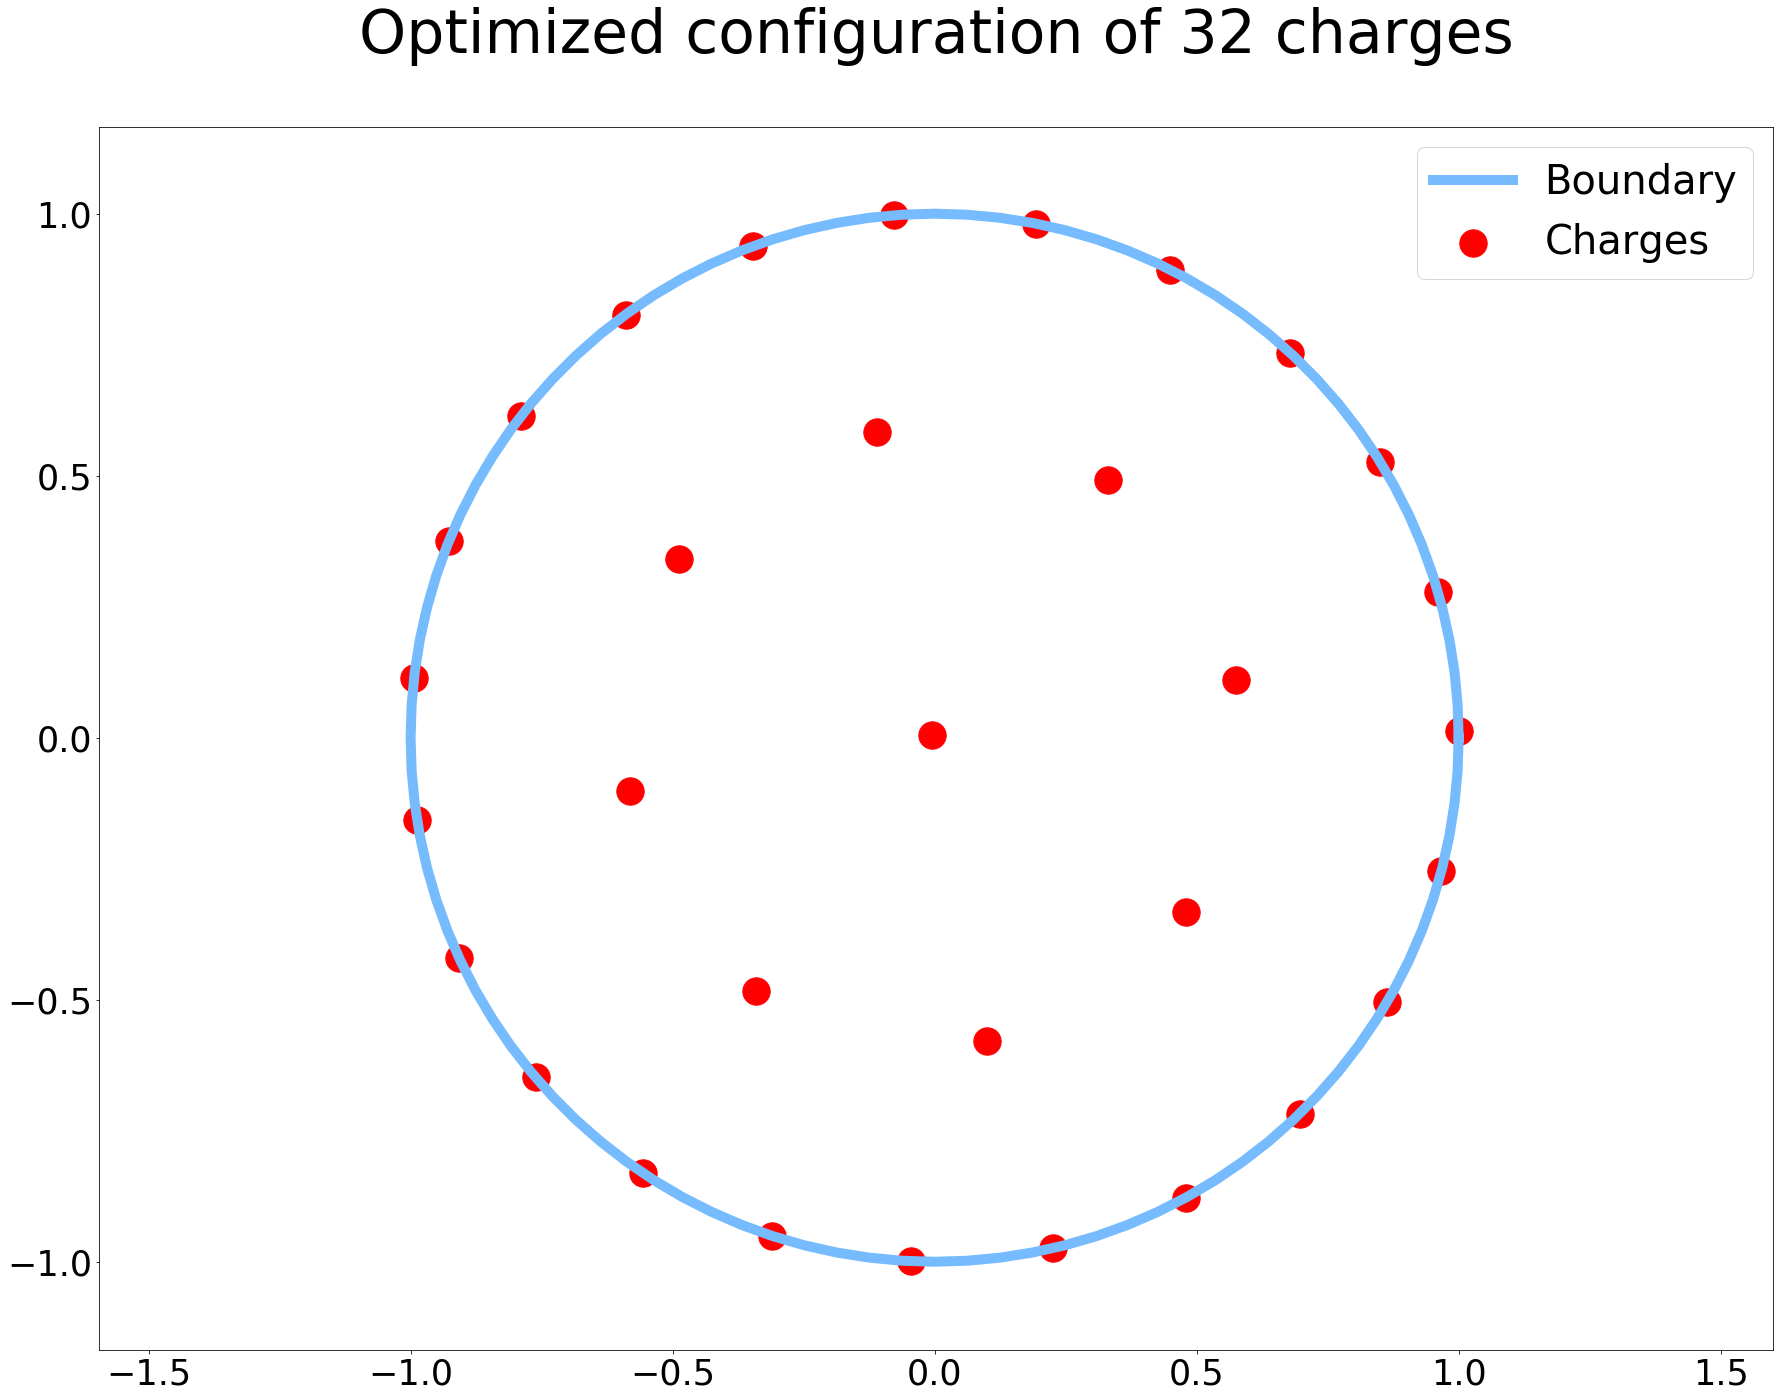

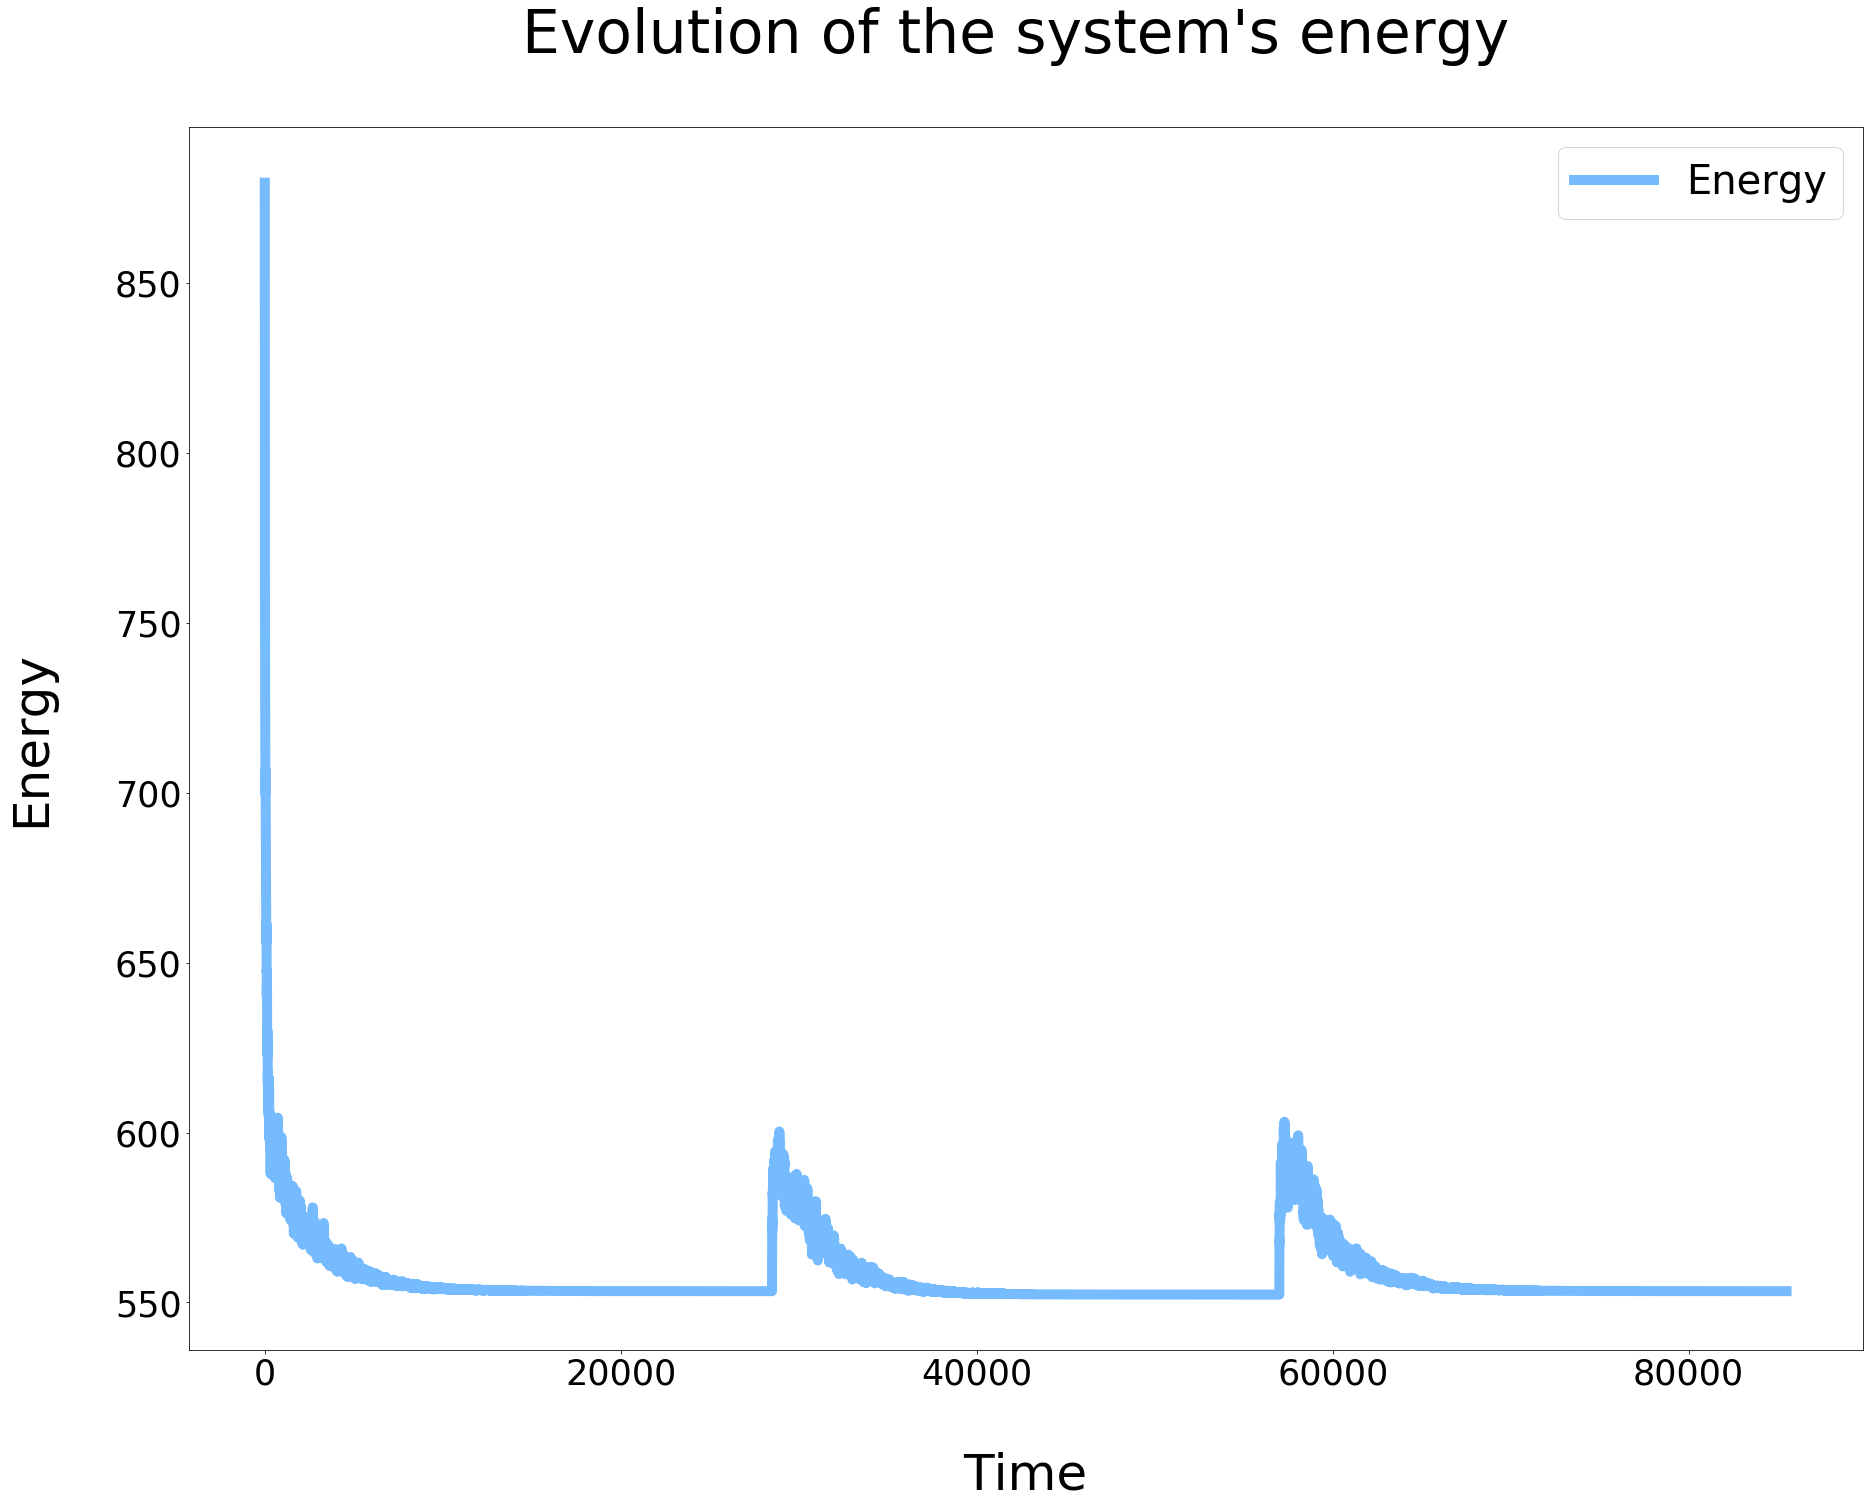

553.33687192099546

In [10]:
an4.freeze()
an4.save_plot('Circle32C098v3')
an4.save_energies('Circle32C098Energyv3')
an4.energies[-1]

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

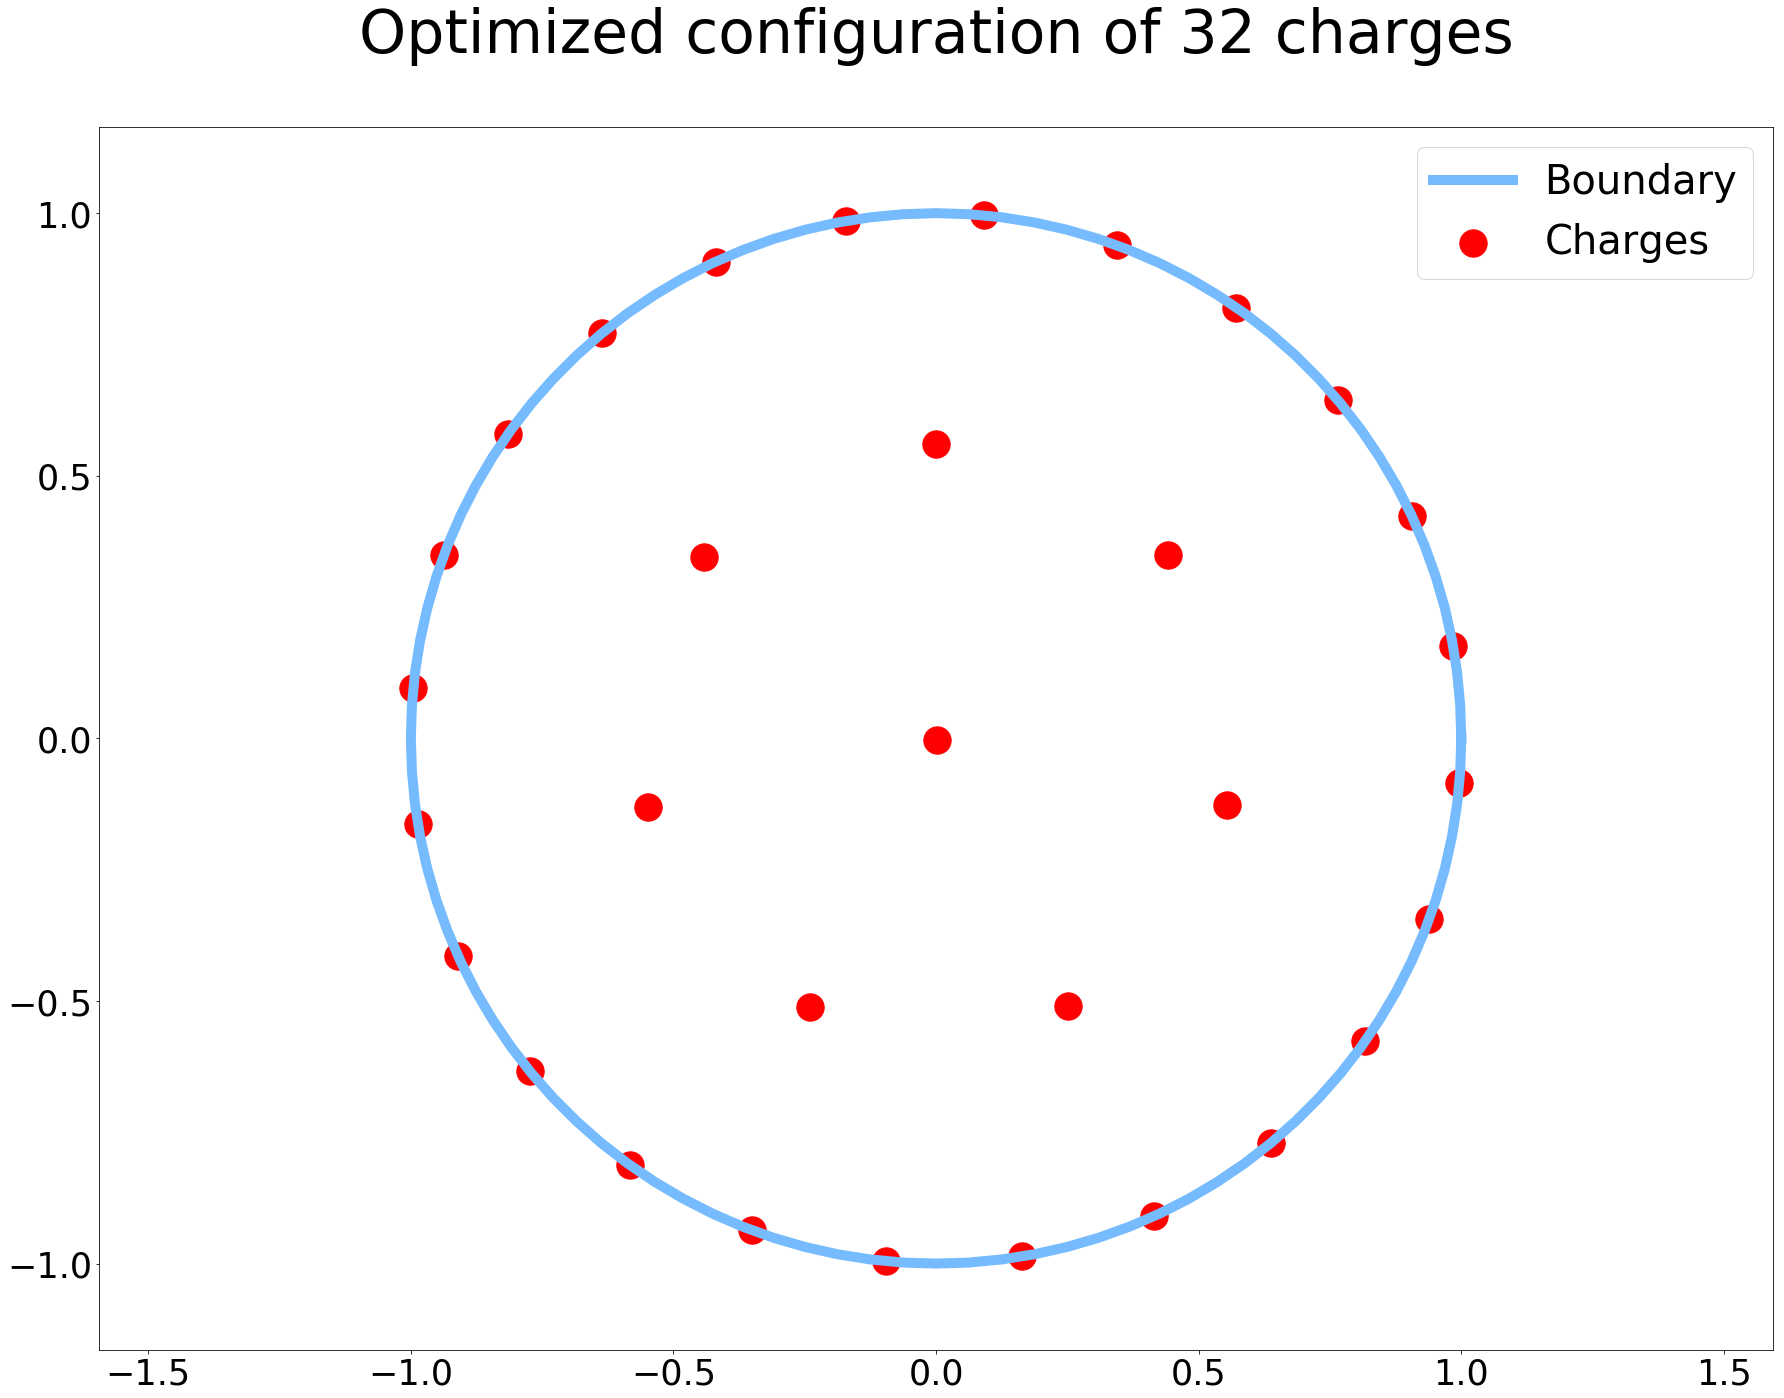

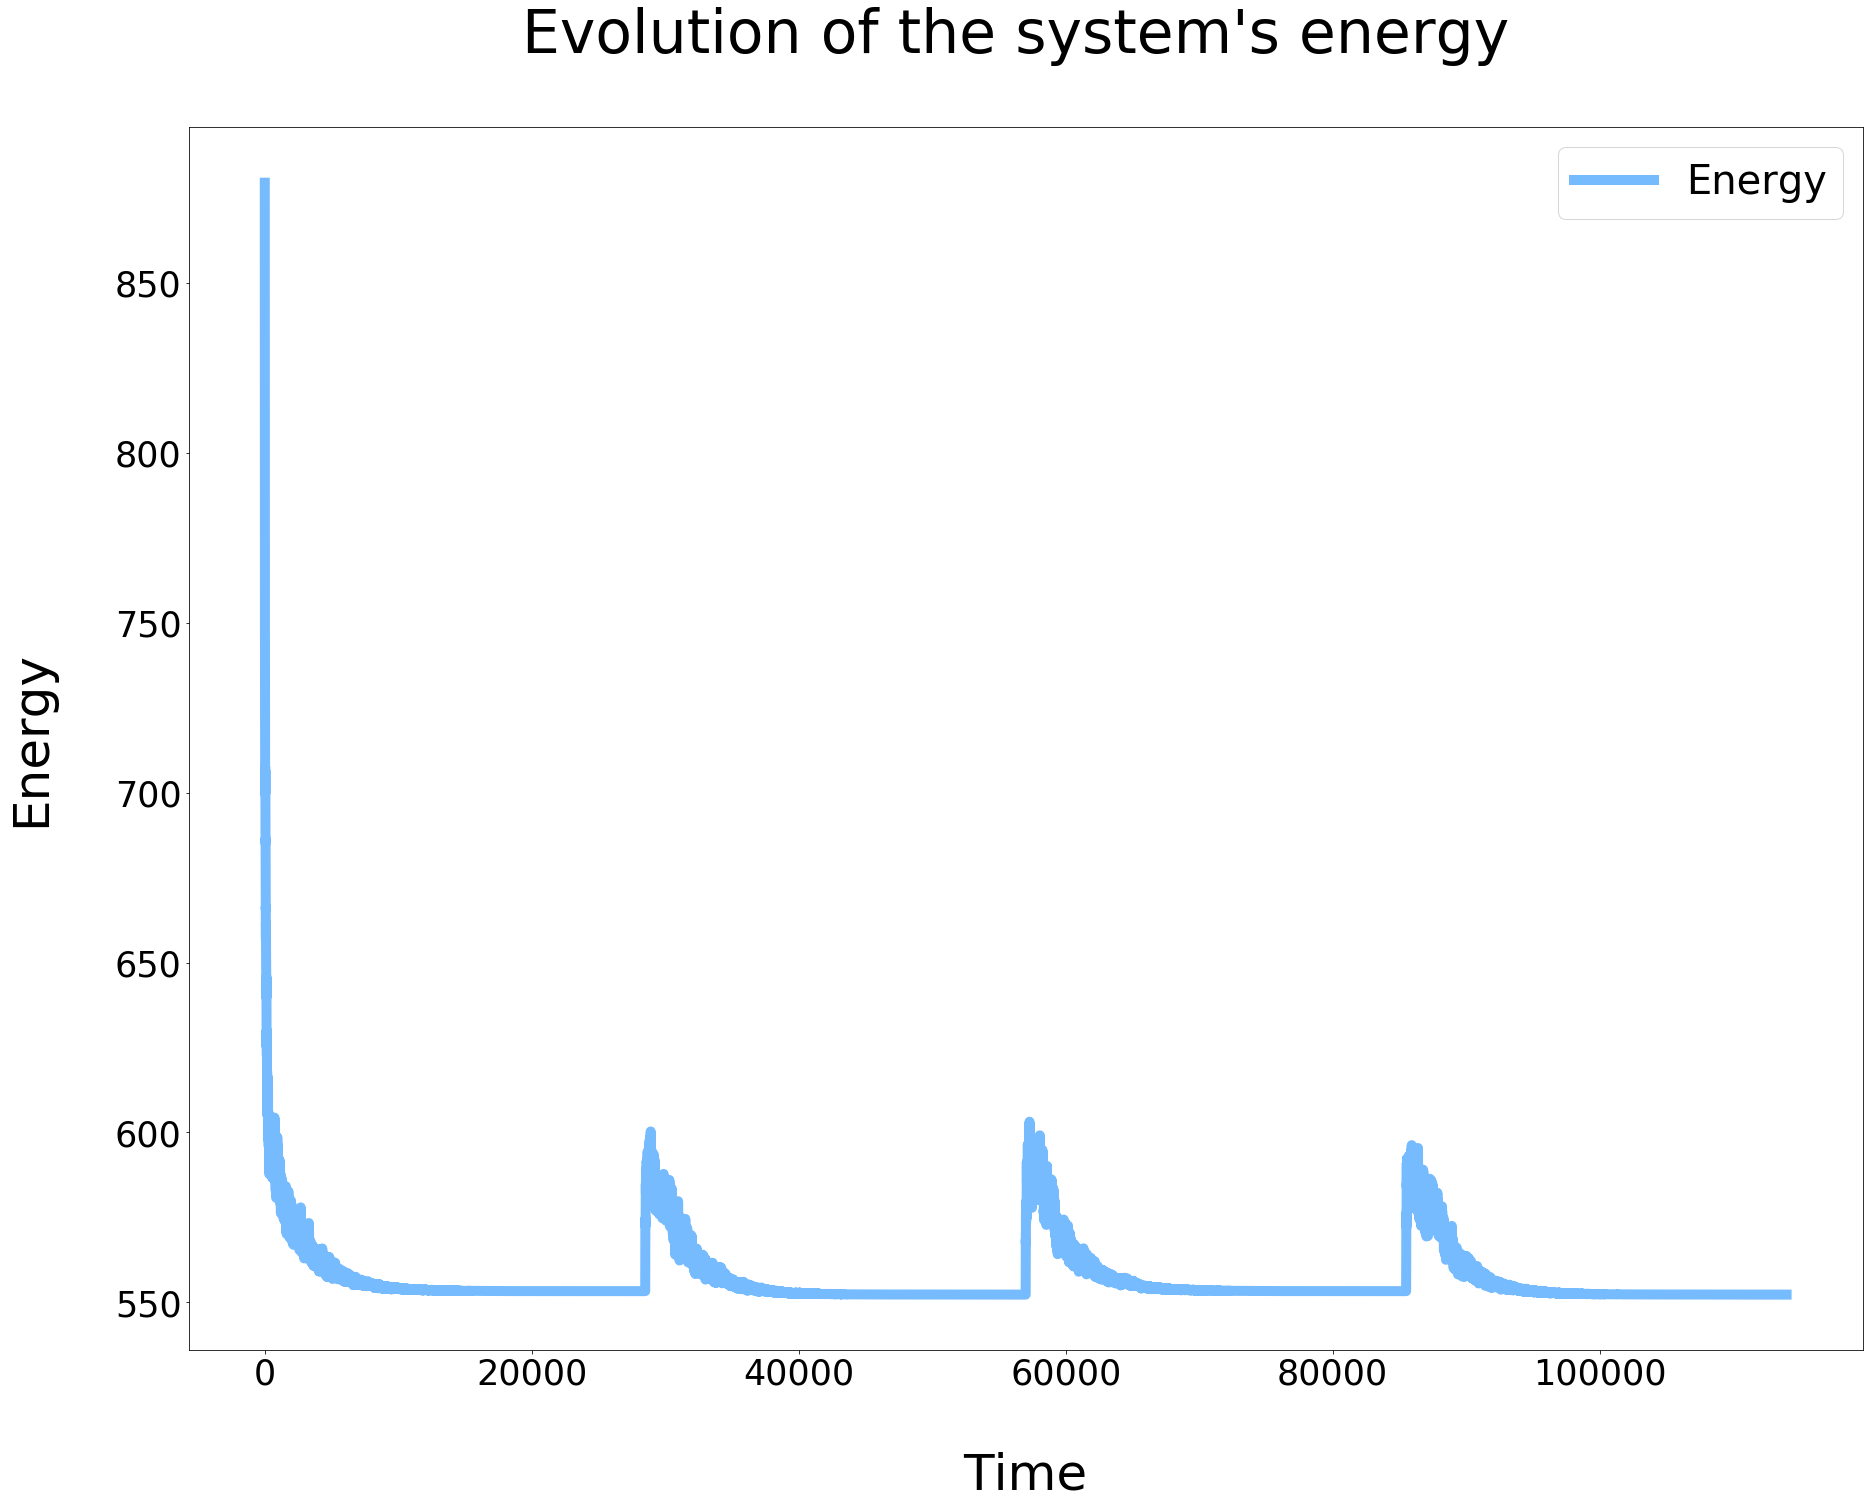

552.31856846380072

In [11]:
an4.freeze()
an4.save_plot('Circle32C098v4')
an4.save_energies('Circle32C098Energyv4')
an4.energies[-1]

0.98
0.9603999999999999
0.9411919999999999
0.9223681599999999
0.9039207967999998
0.8858423808639998
0.8681255332467198
0.8507630225817854
0.8337477621301497
0.8170728068875467
0.8007313507497957
0.7847167237347998
0.7690223892601038
0.7536419414749017
0.7385691026454037
0.7237977205924956
0.7093217661806457
0.6951353308570327
0.6812326242398921
0.6676079717550942
0.6542558123199923
0.6411706960735924
0.6283472821521205
0.6157803365090782
0.6034647297788965
0.5913954351833186
0.5795675264796523
0.5679761759500592
0.5566166524310581
0.5454843193824369
0.5345746329947881
0.5238831403348924
0.5134054775281945
0.5031373679776306
0.493074620618078
0.48321312820571644
0.4735488656416021
0.46407788832877006
0.45479633056219465
0.44570040395095073
0.4367863958719317
0.42805066795449304
0.41948965459540316
0.4110998615034951
0.4028778642734252
0.39482030698795667
0.38692390084819756
0.3791854228312336
0.37160171437460887
0.3641696800871167
0.35688628648537435
0.34974856075566685
0.34275358954055

0.00031564884265888887
0.0003093358658057111
0.0003031491484895969
0.00029708616551980496
0.00029114444220940886
0.00028532155336522067
0.00027961512229791625
0.00027402281985195793
0.00026854236345491875
0.00026317151618582036
0.00025790808586210394
0.00025274992414486185
0.00024769492566196463
0.00024274102714872534
0.00023788620660575082
0.0002331284824736358
0.0002284659128241631
0.00022389659456767983
0.00021941866267632623
0.0002150302894227997
0.0002107296836343437
0.00020651508996165683
0.00020238478816242368
0.0001983370923991752
0.0001943703505511917
0.00019048294354016786
0.0001866732846693645
0.0001829398189759772
0.00017928102259645766
0.0001756954021445285
0.00017218149410163792
0.00016873786421960516
0.00016536310693521307
0.0001620558447965088
0.0001588147279005786
0.00015563843334256703
0.00015252566467571568
0.00014947515138220136
0.00014648564835455732
0.00014355593538746618
0.00014068481667971685
0.00013787112034612252
0.00013511369793920008
0.00013241142398041607
0

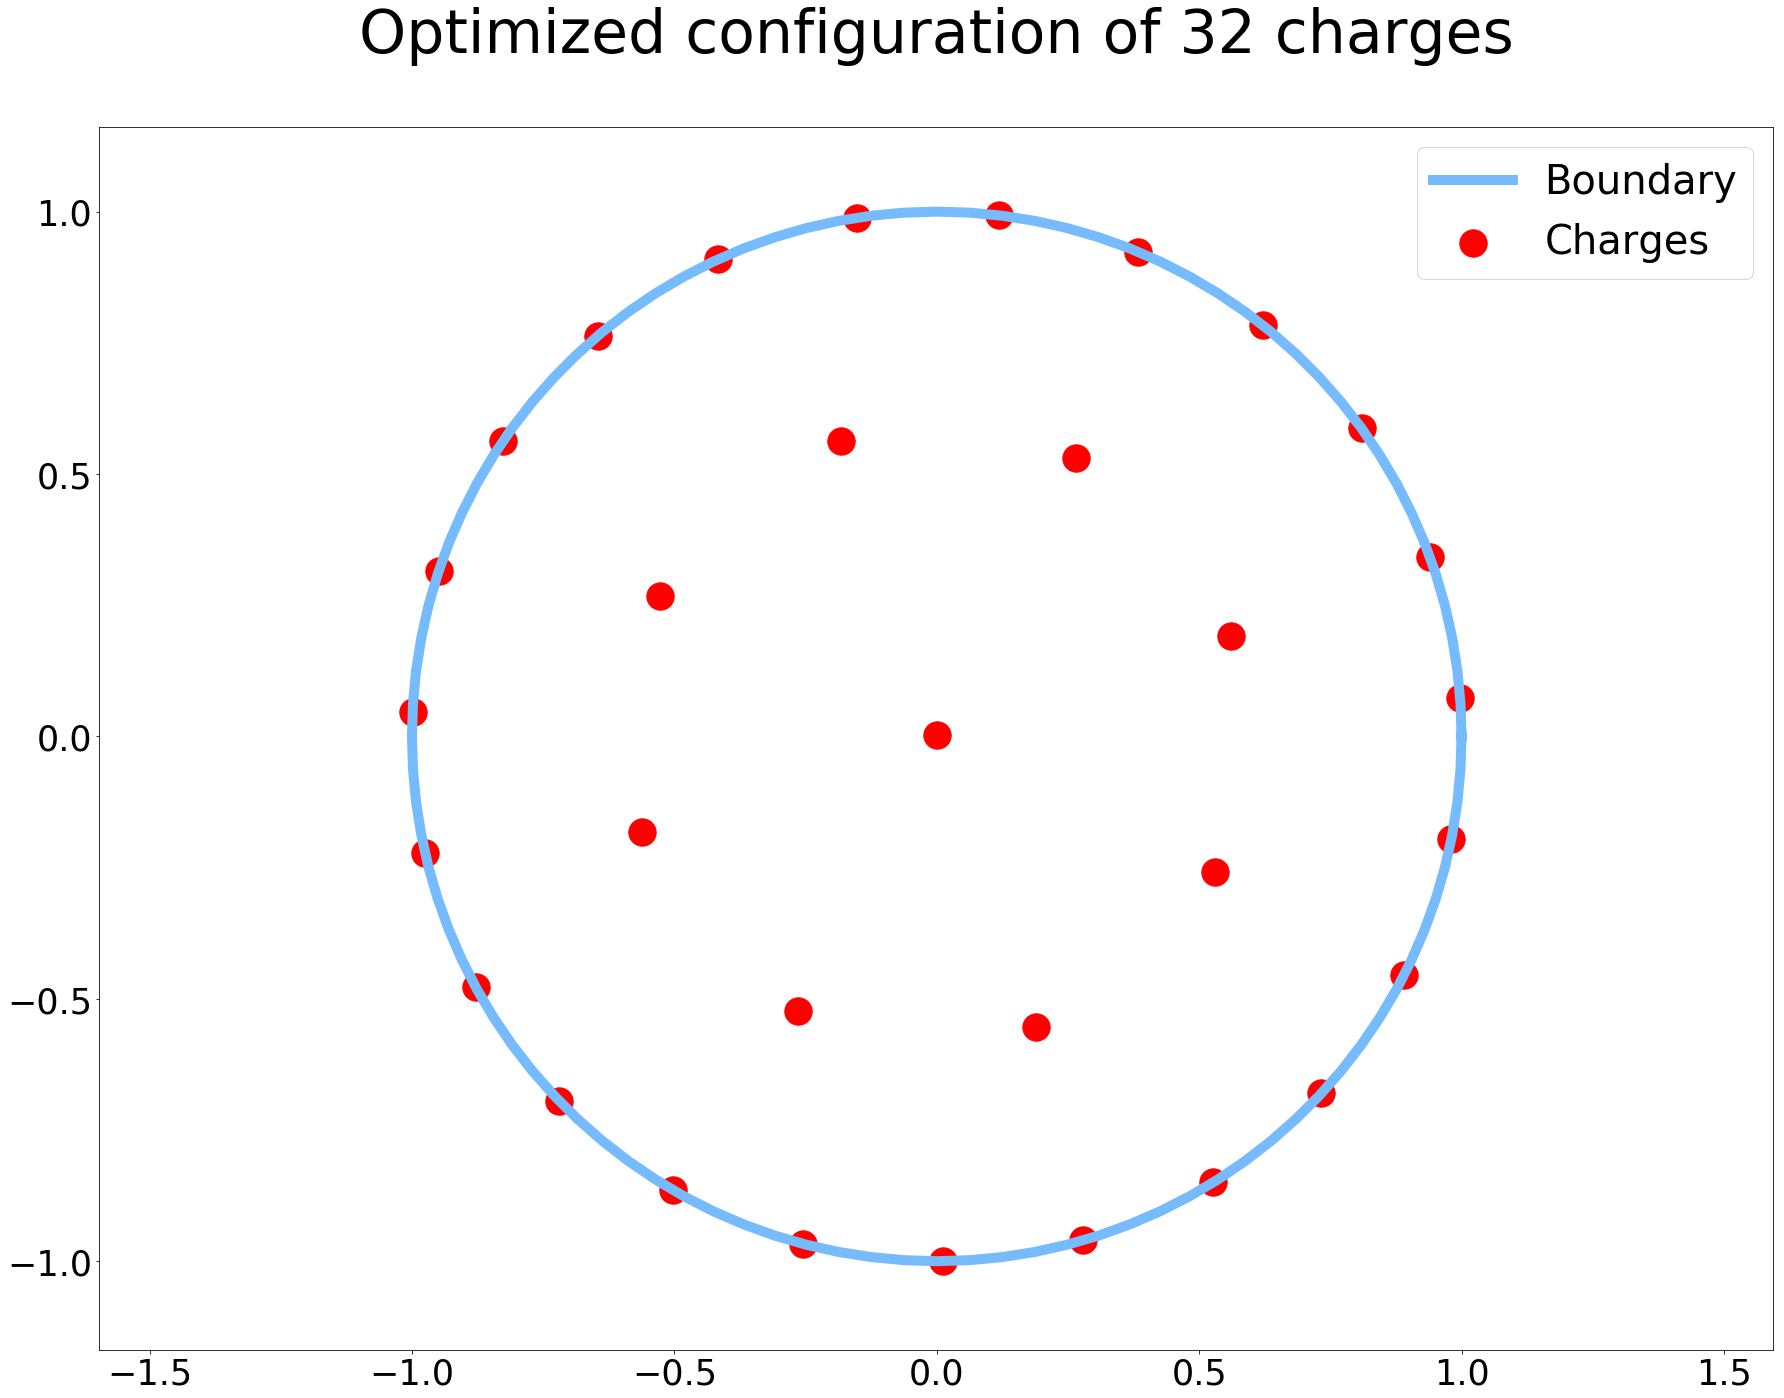

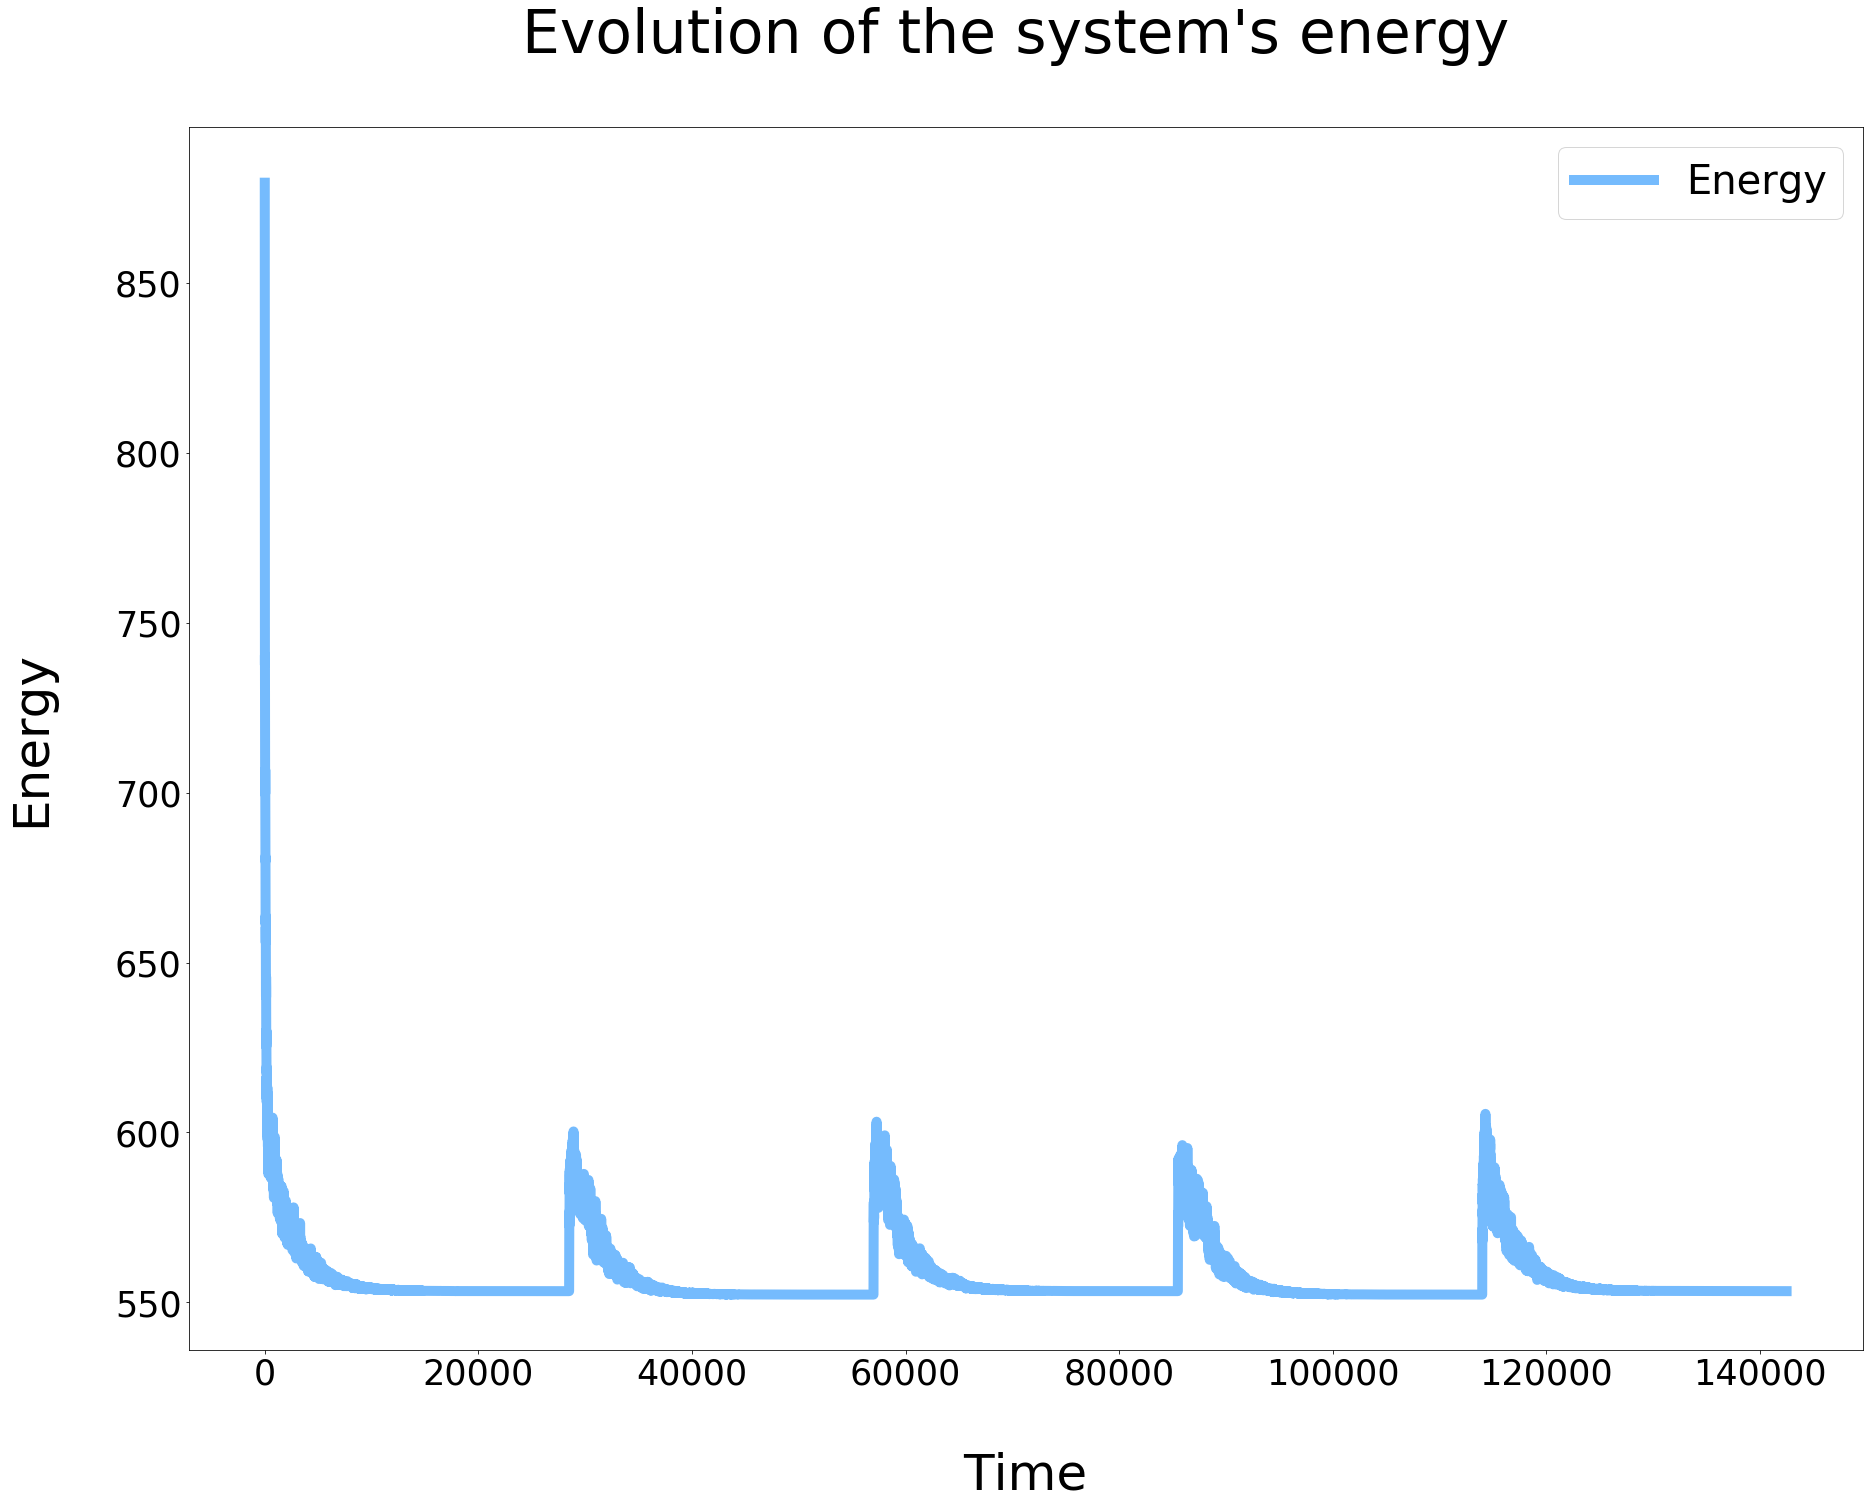

553.33393096827899

In [12]:
an4.freeze()
an4.save_plot('Circle32C098v5')
an4.save_energies('Circle32C098Energyv5')
an4.energies[-1]

In [19]:
def mutliple_annealing(N_charges, N_processes, initial_temp, cooling_ratio, MCS, boundary_type):
  multiple_minima = []
  an_multiple = Annealer(N_charges, initial_temp, 10**-5, cooling_ratio, MCS, 0.02, 1, boundary_type)
  for i in range(N_processes):
    print(f'{i+1}/{N_processes} began')
    an_multiple.freeze()
    an_multiple.save_plot(f'{boundary_type}{N_charges}C{cooling_ratio}v{i+1}')
    an_multiple.save_energies(f'{boundary_type}{N_charges}C{cooling_ratio}Energyv{i+1}')
    multiple_minima.append(an_multiple.energies[-1])
  return an_multiple, multiple_minima

1/10 began


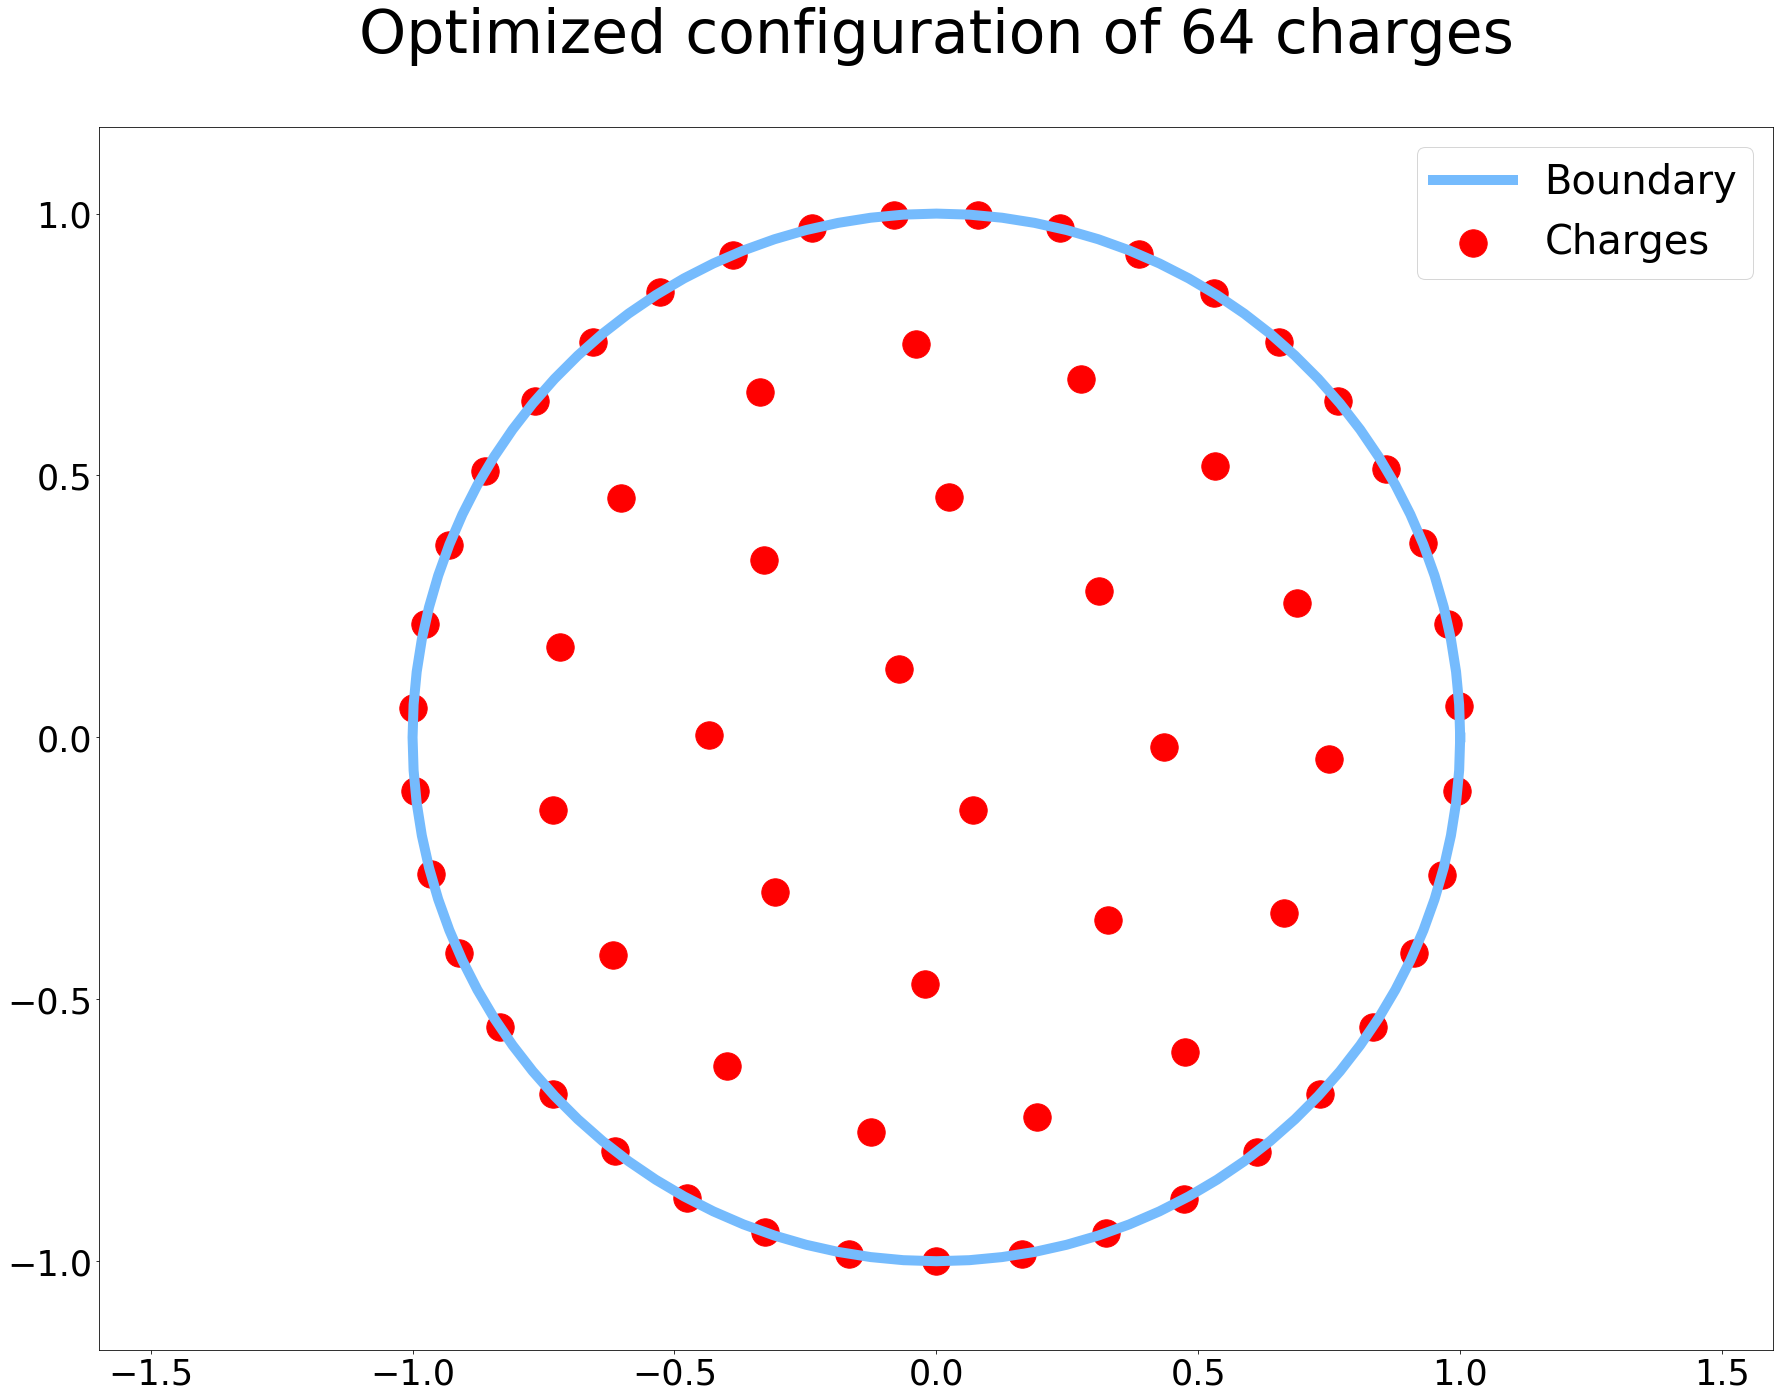

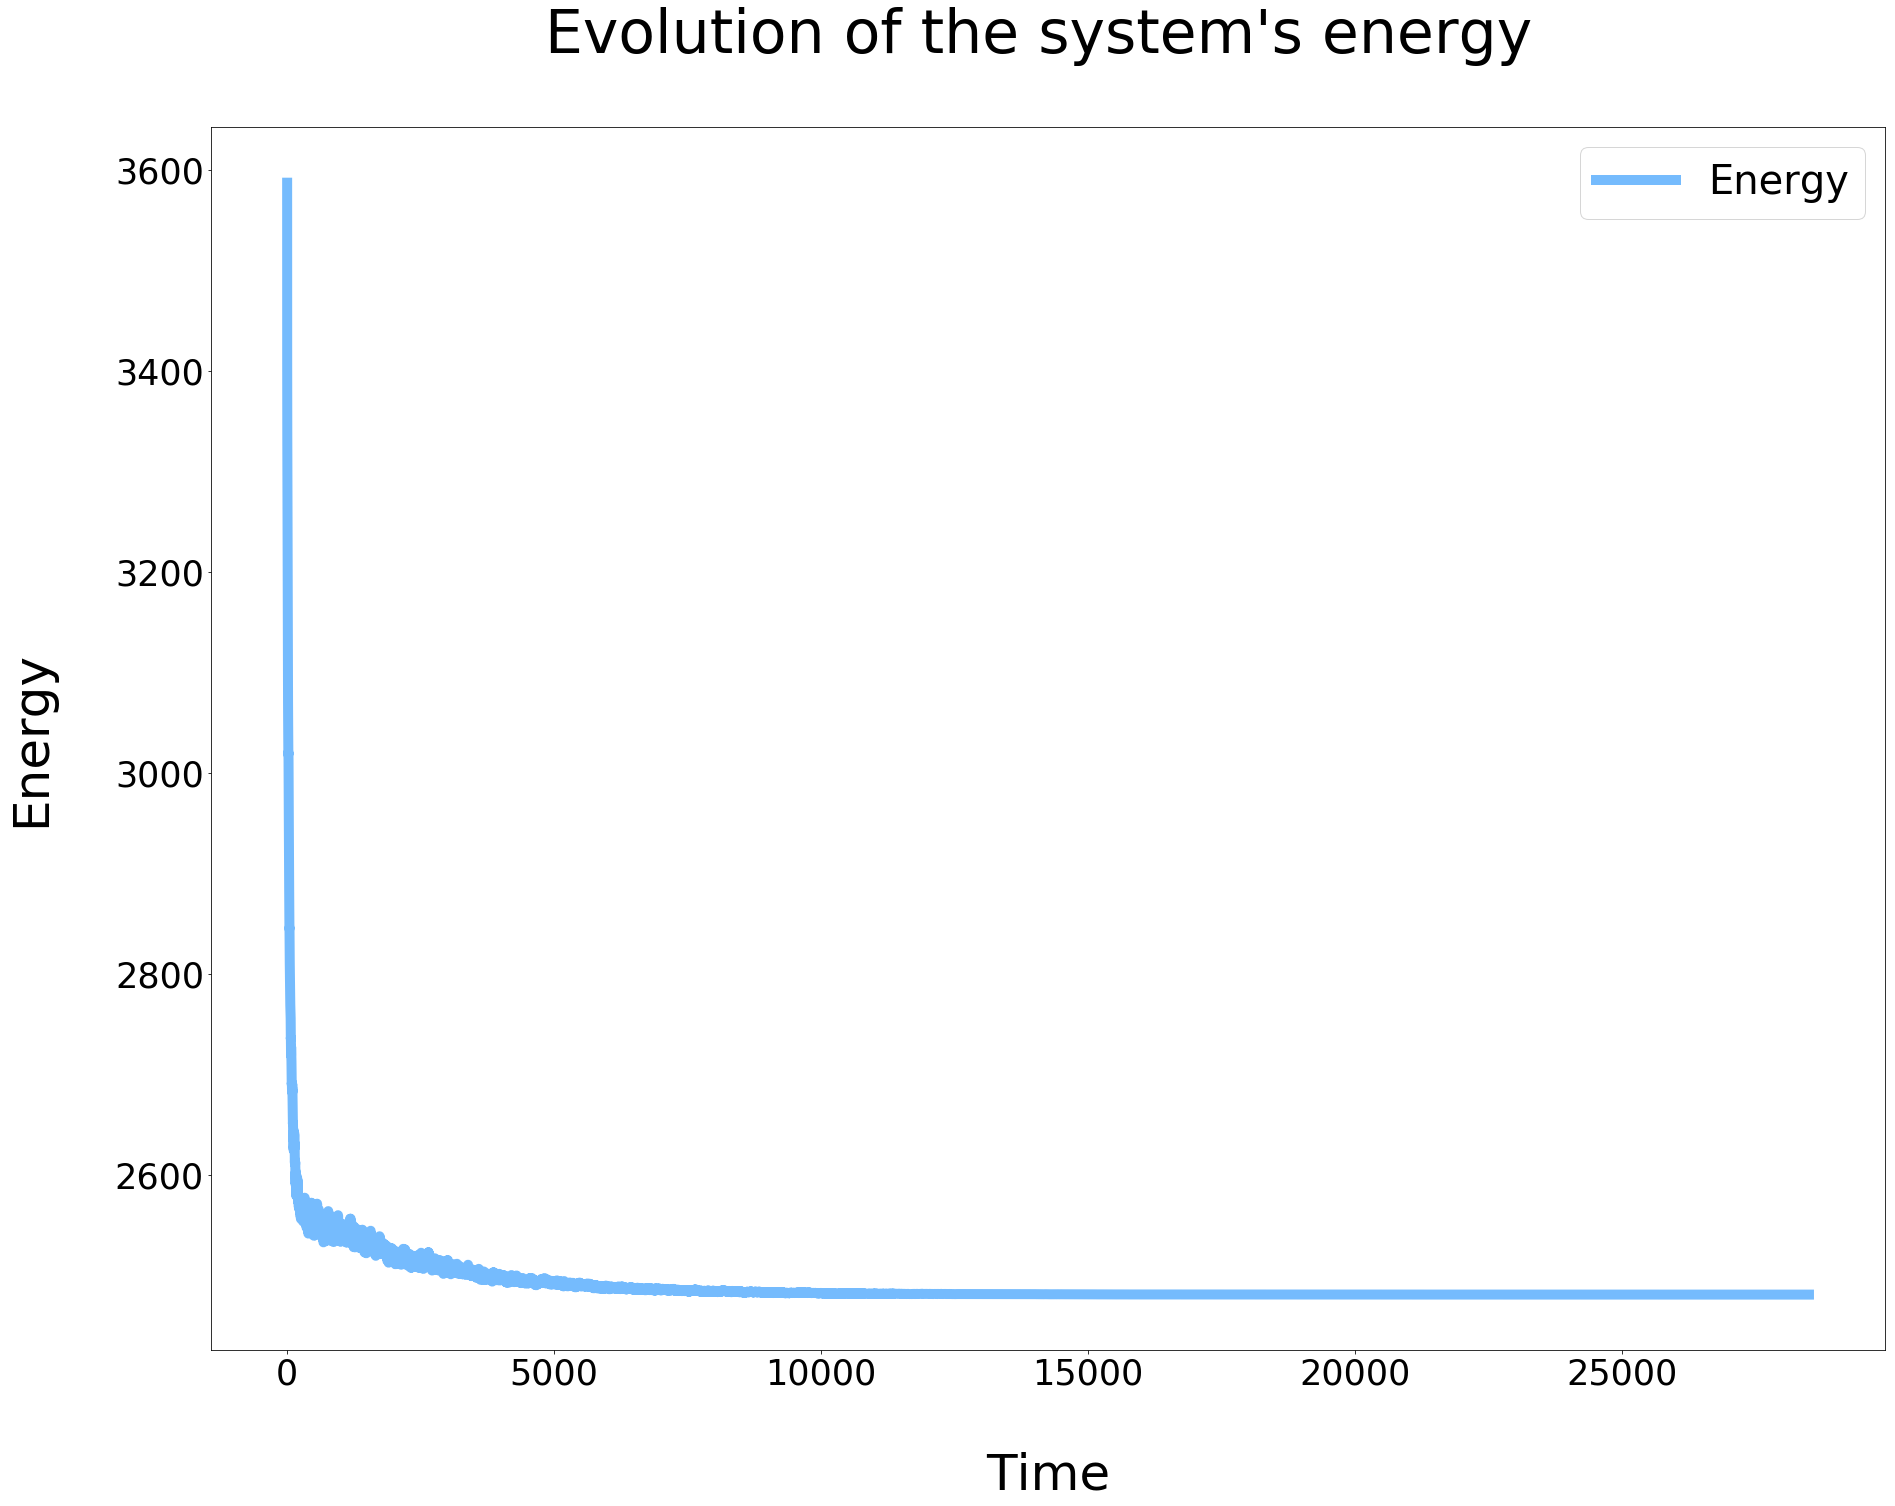

2/10 began


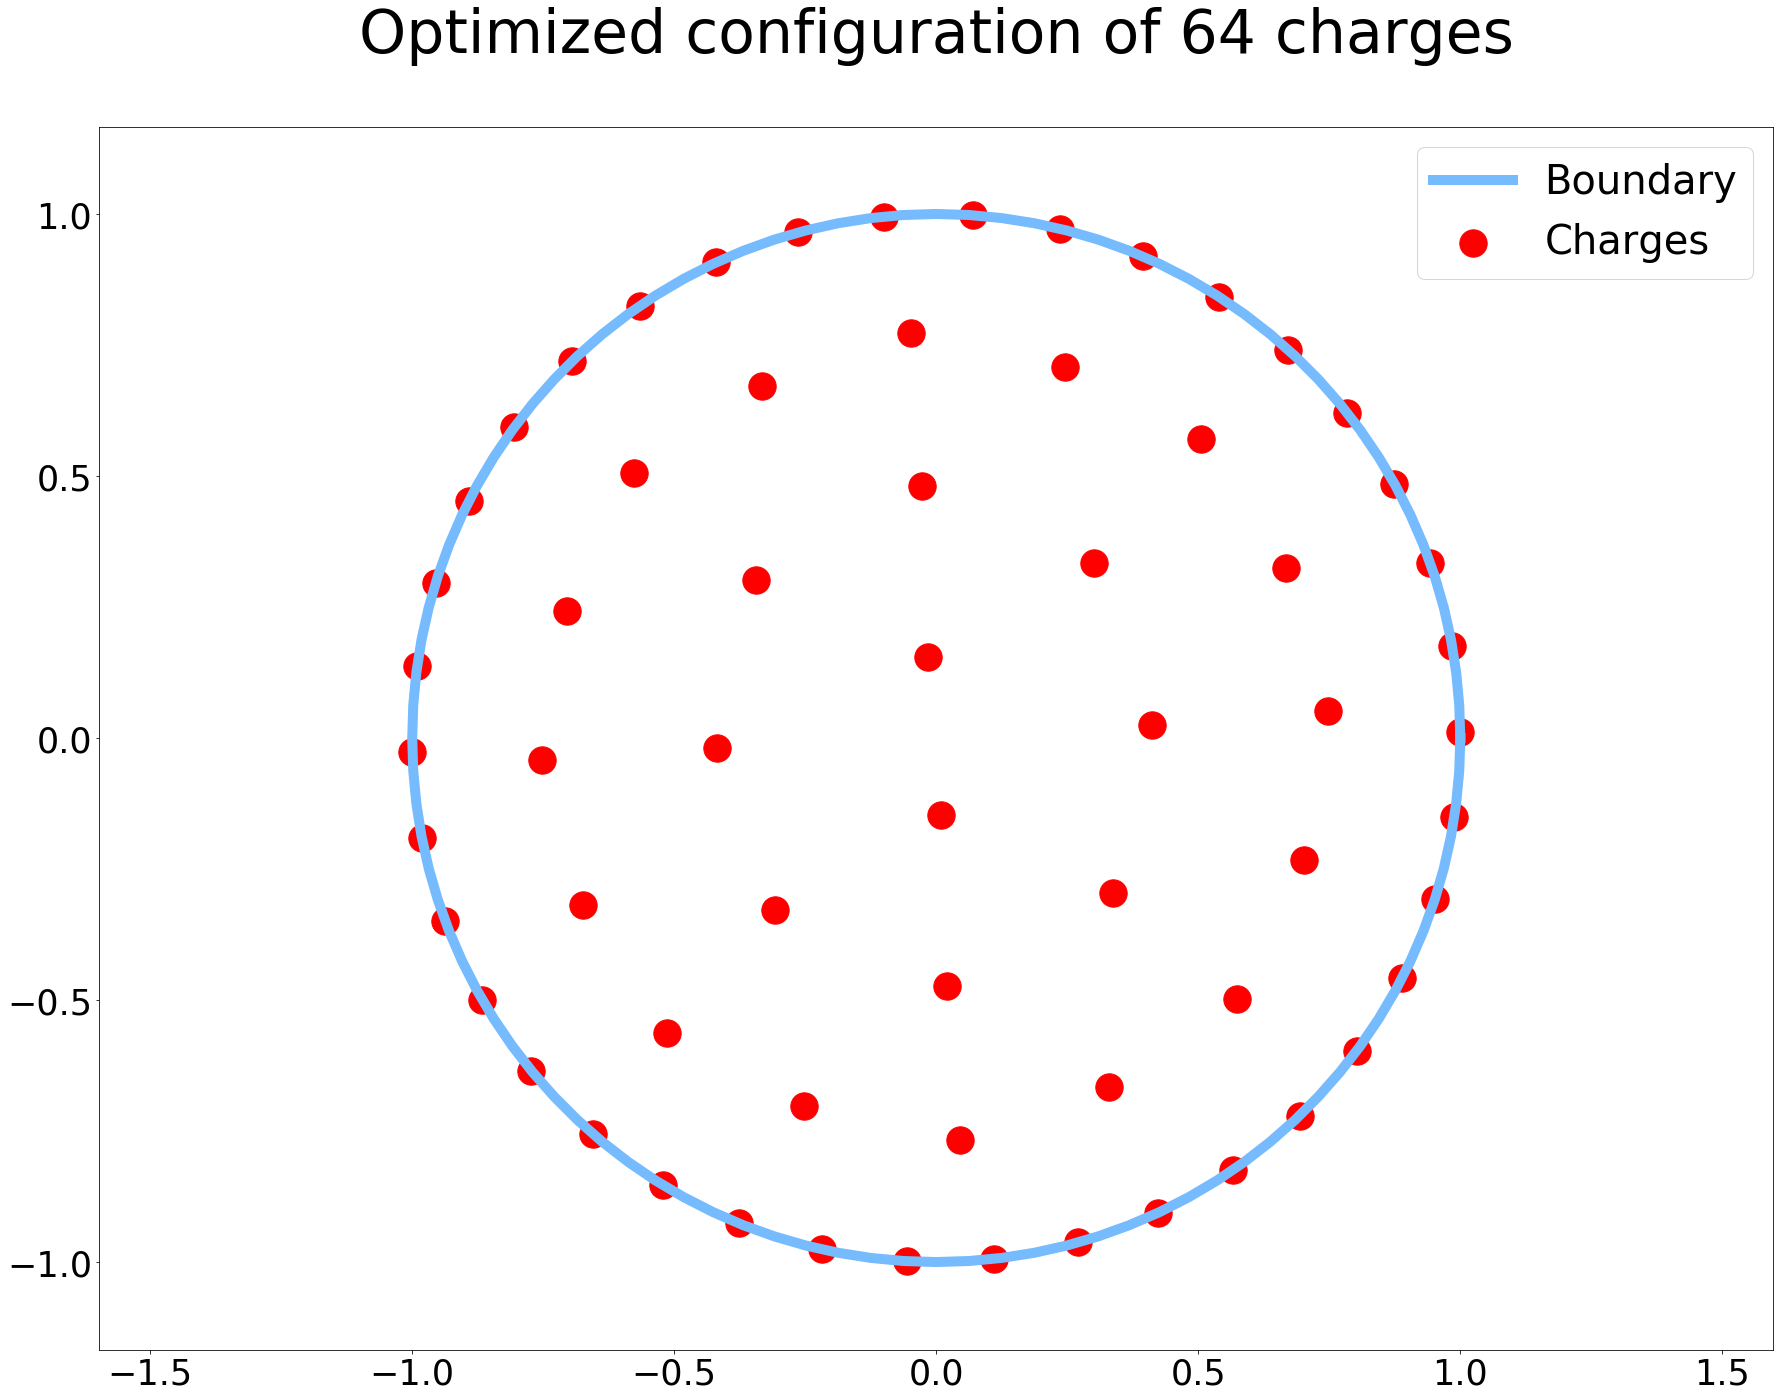

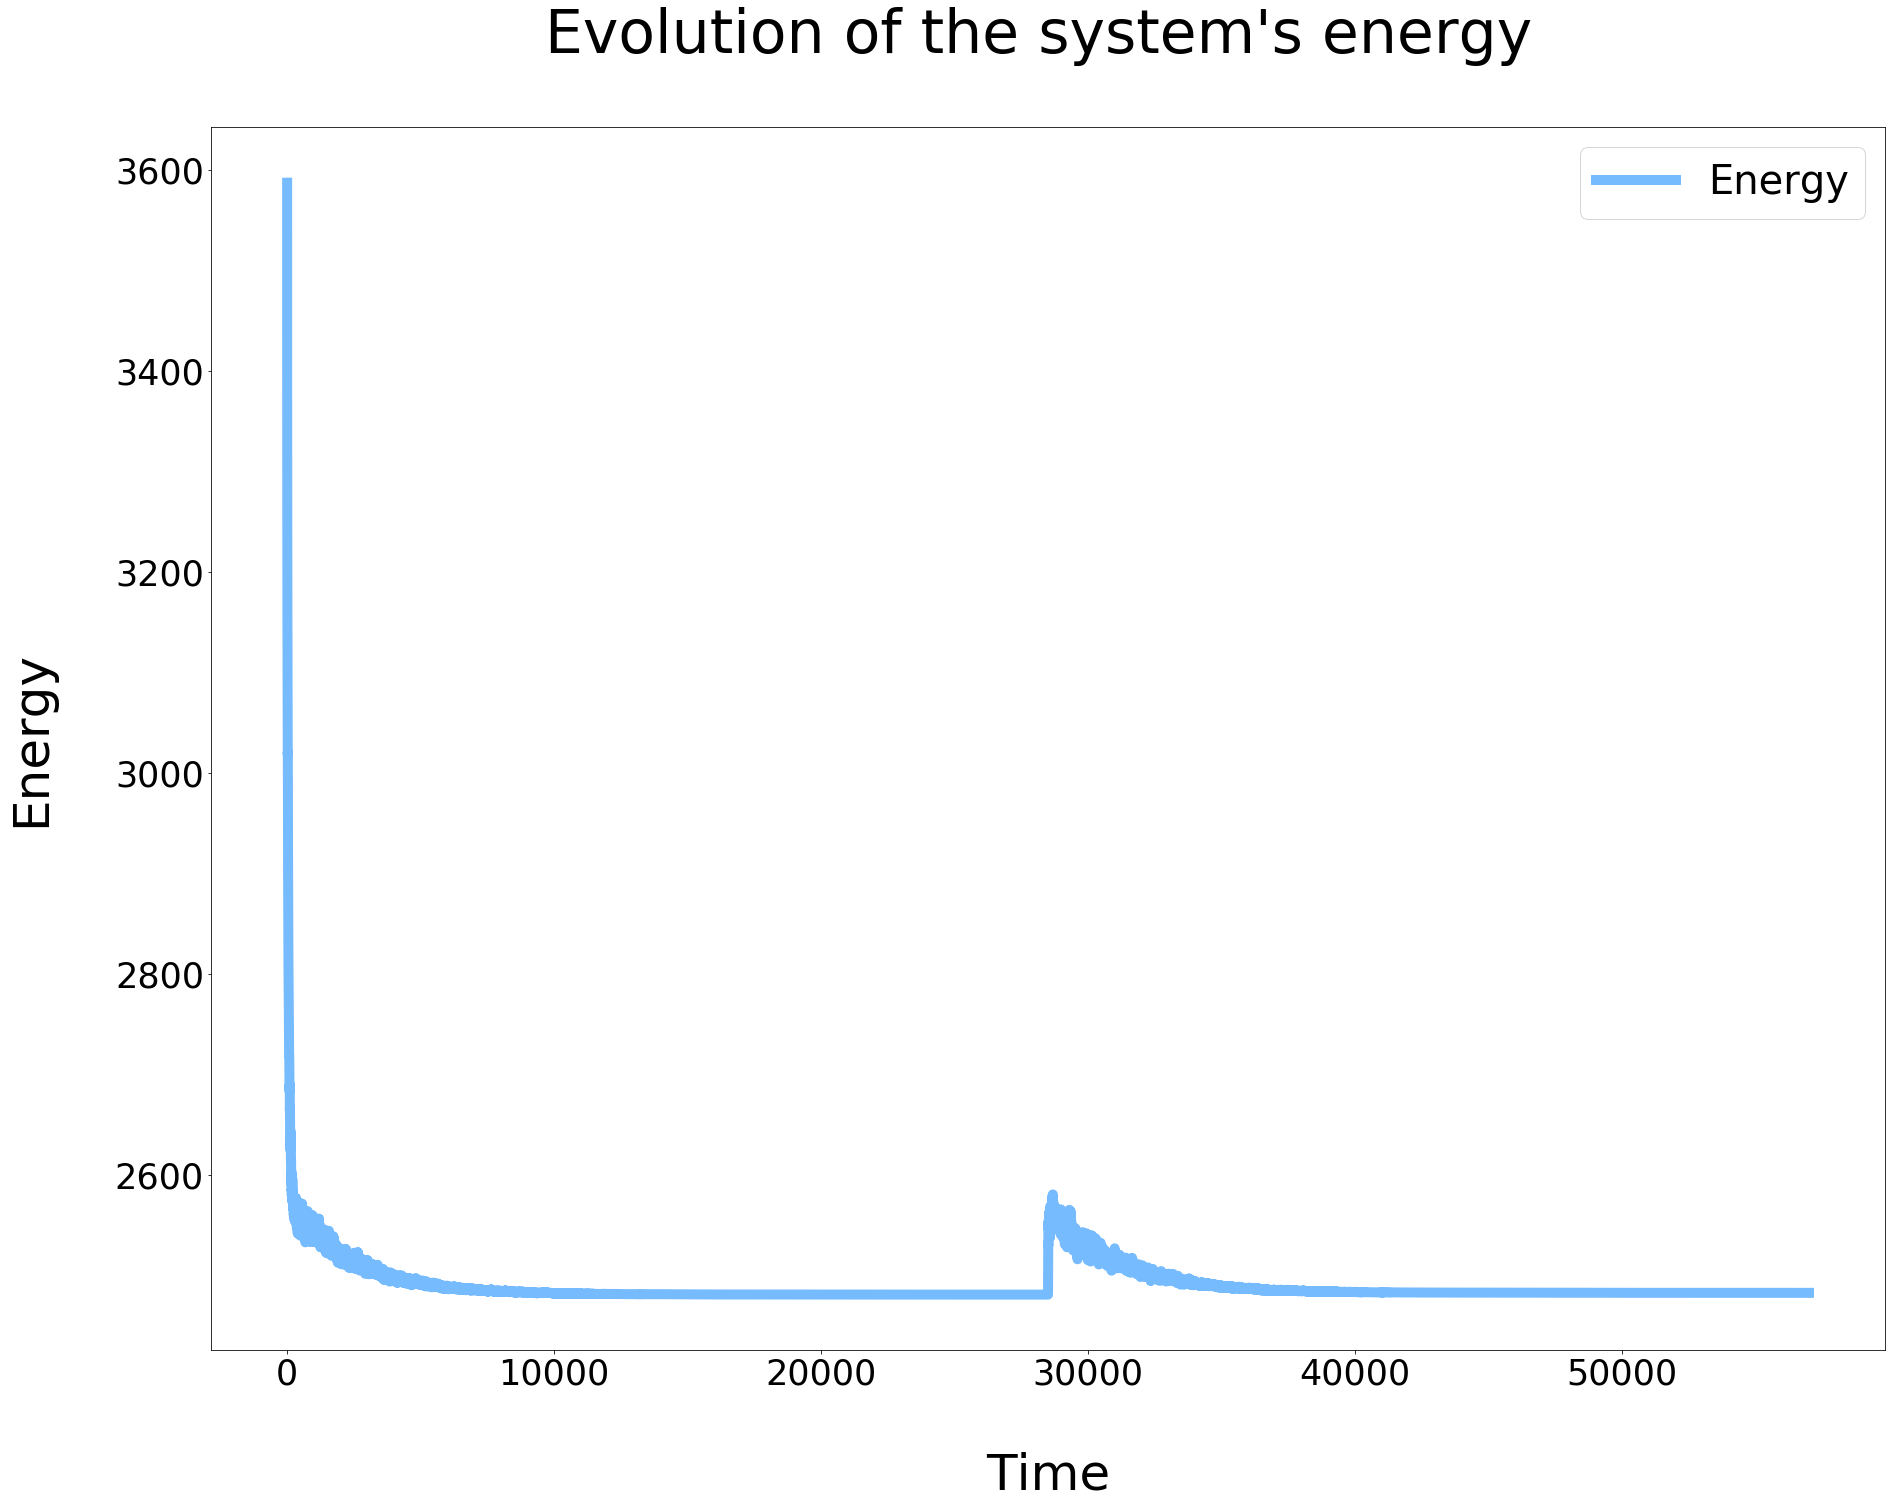

3/10 began


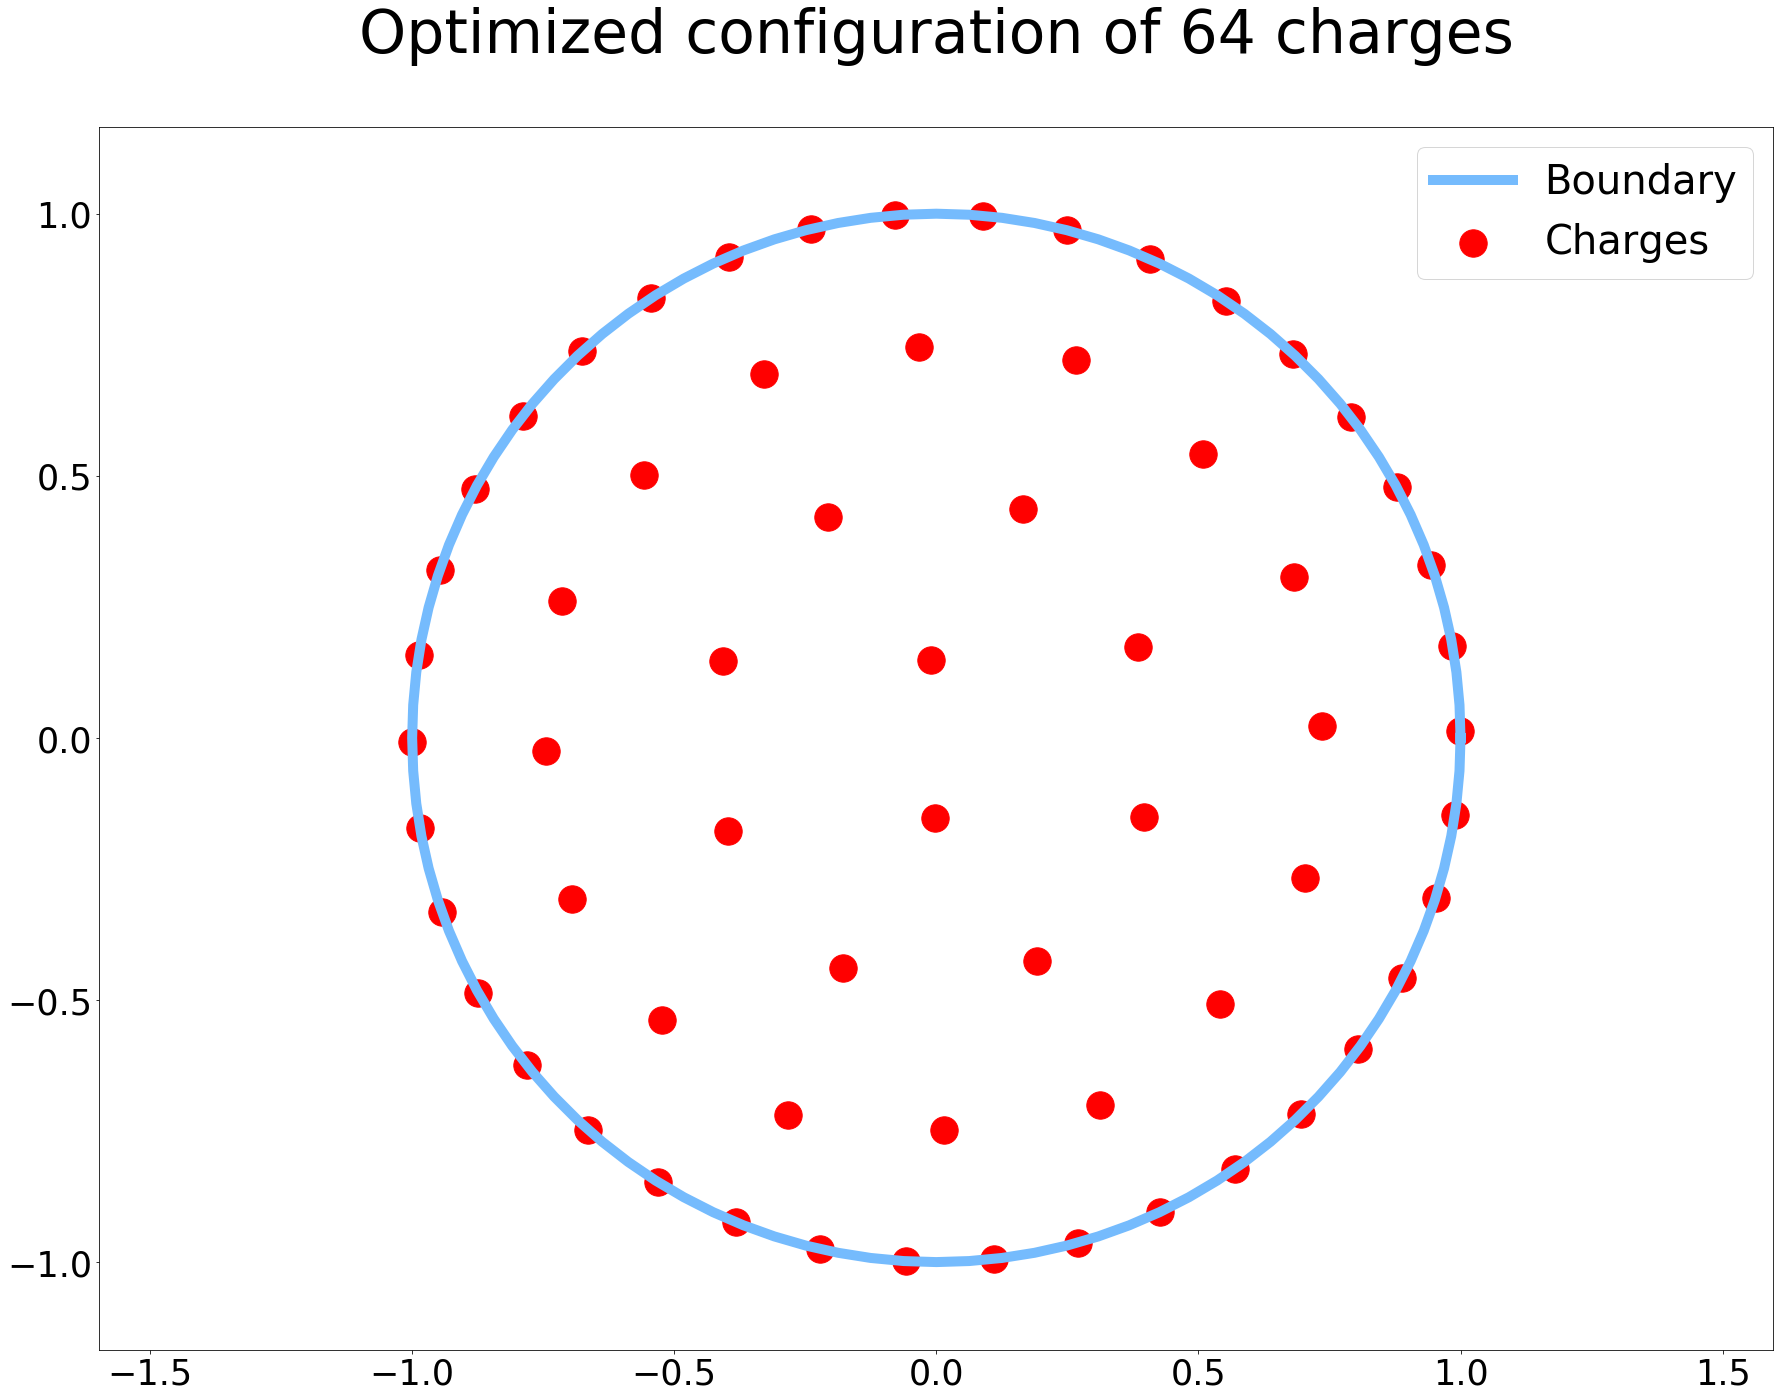

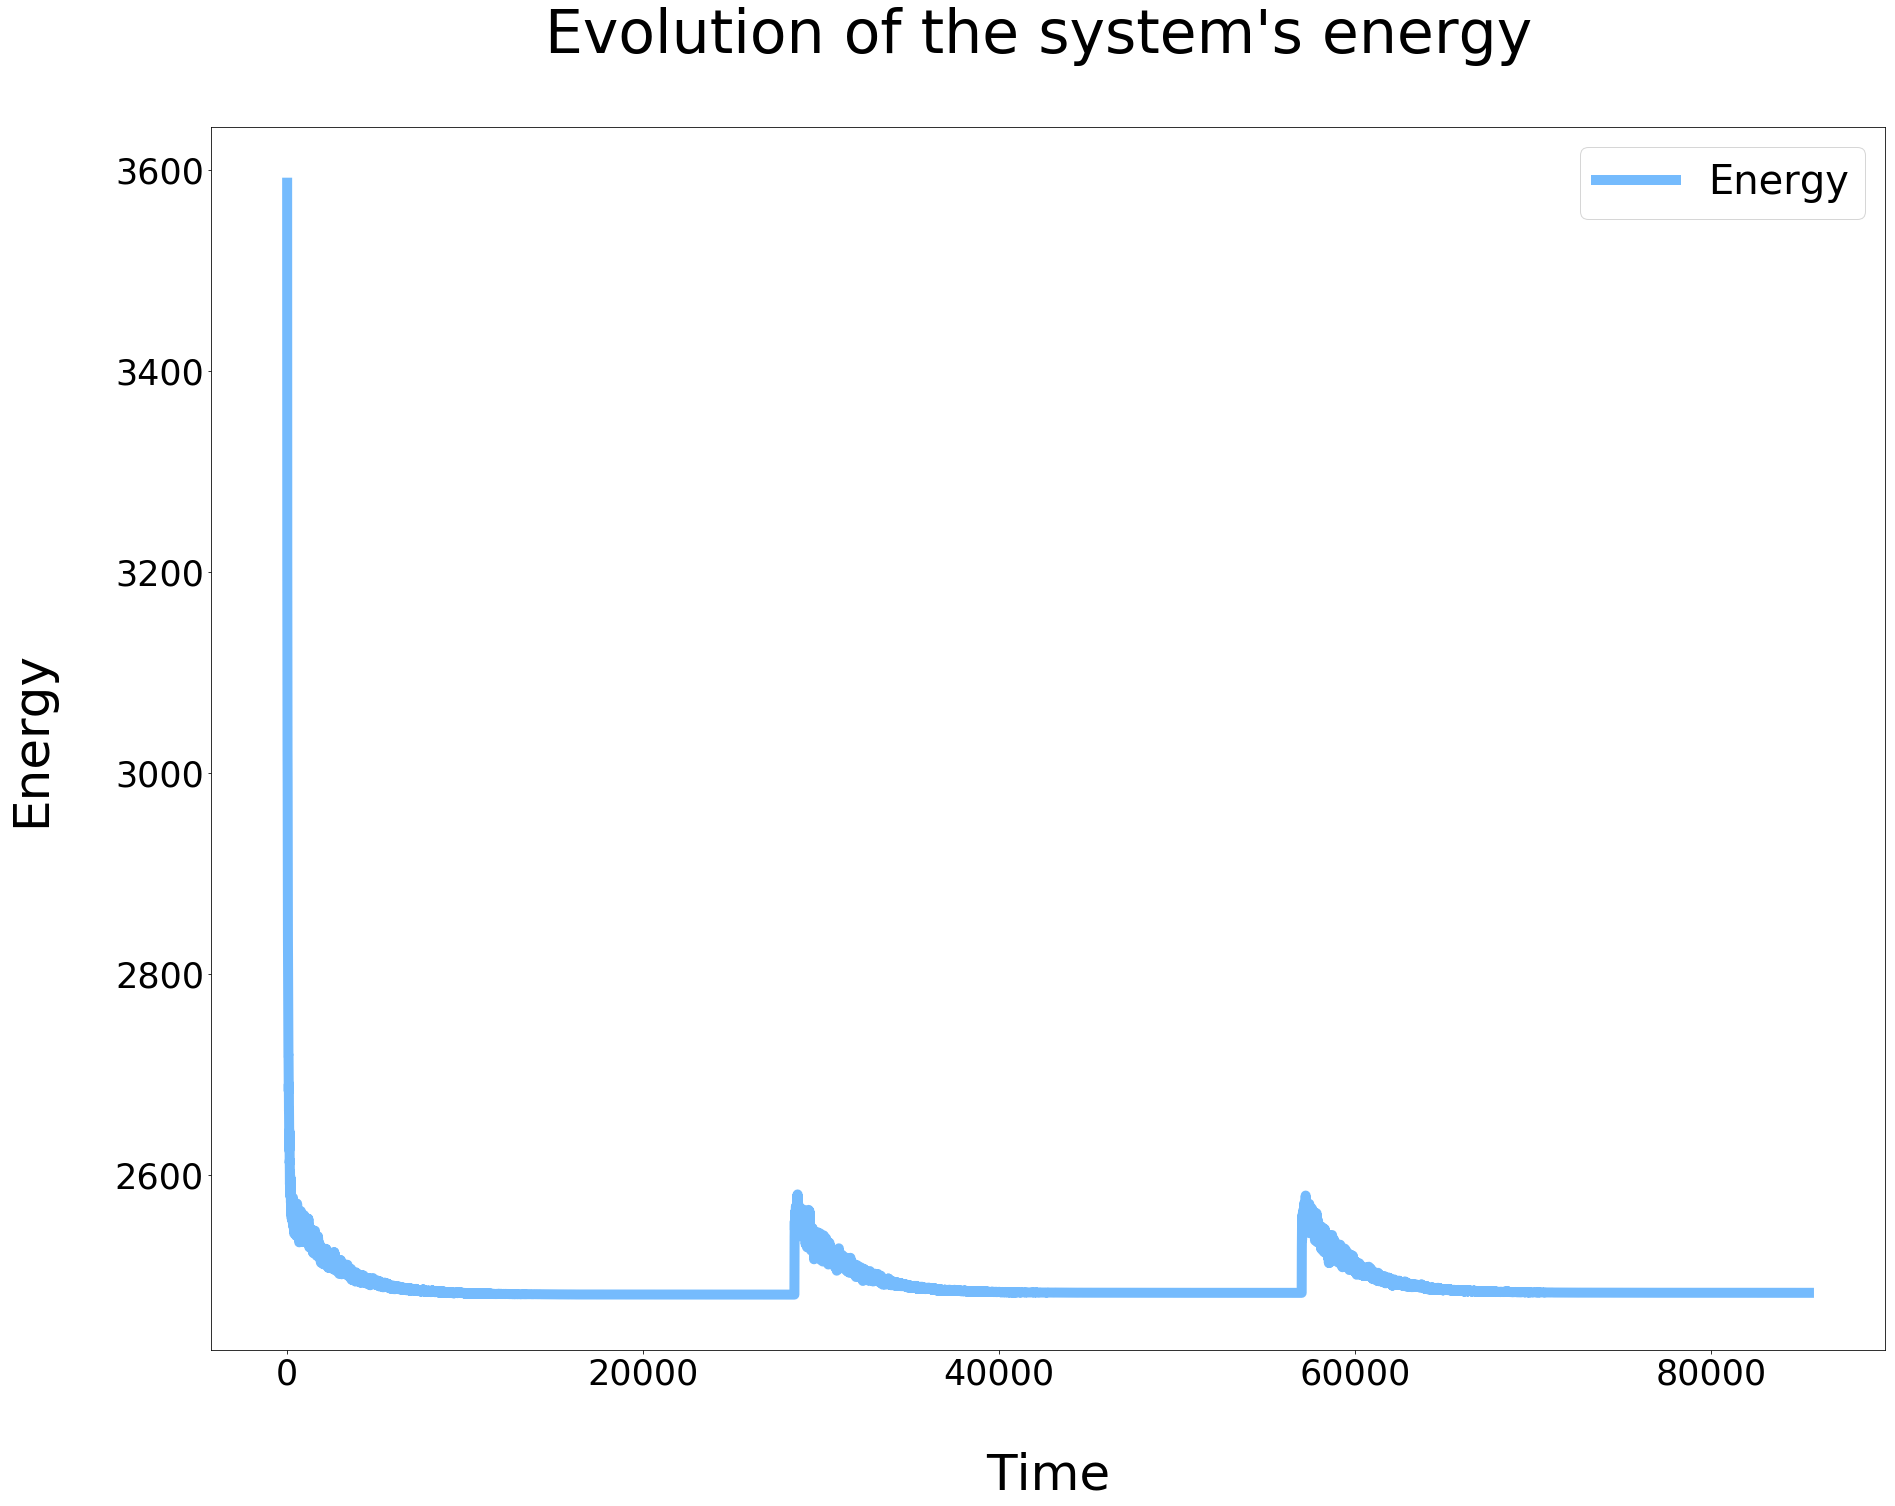

4/10 began


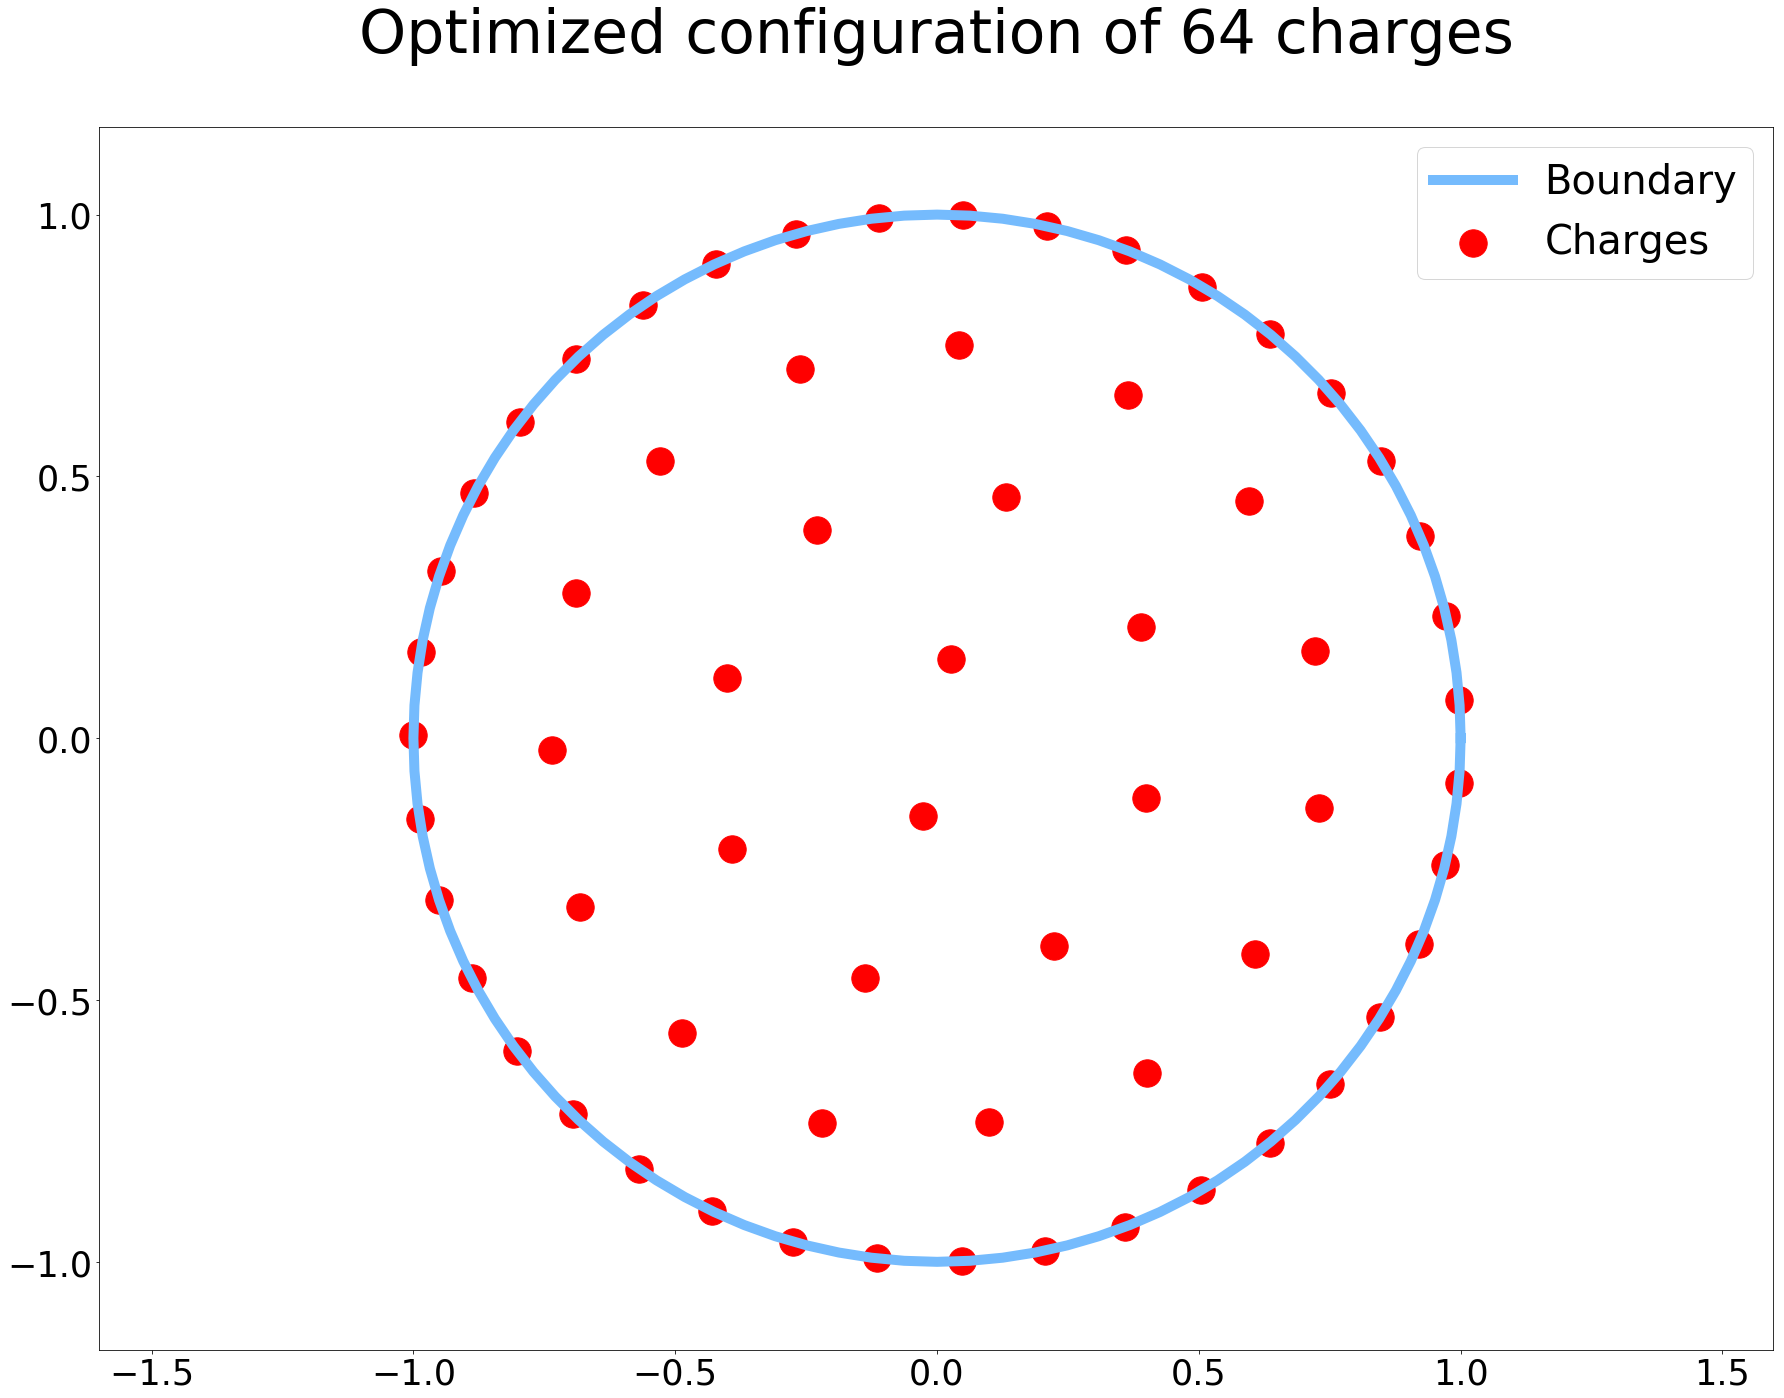

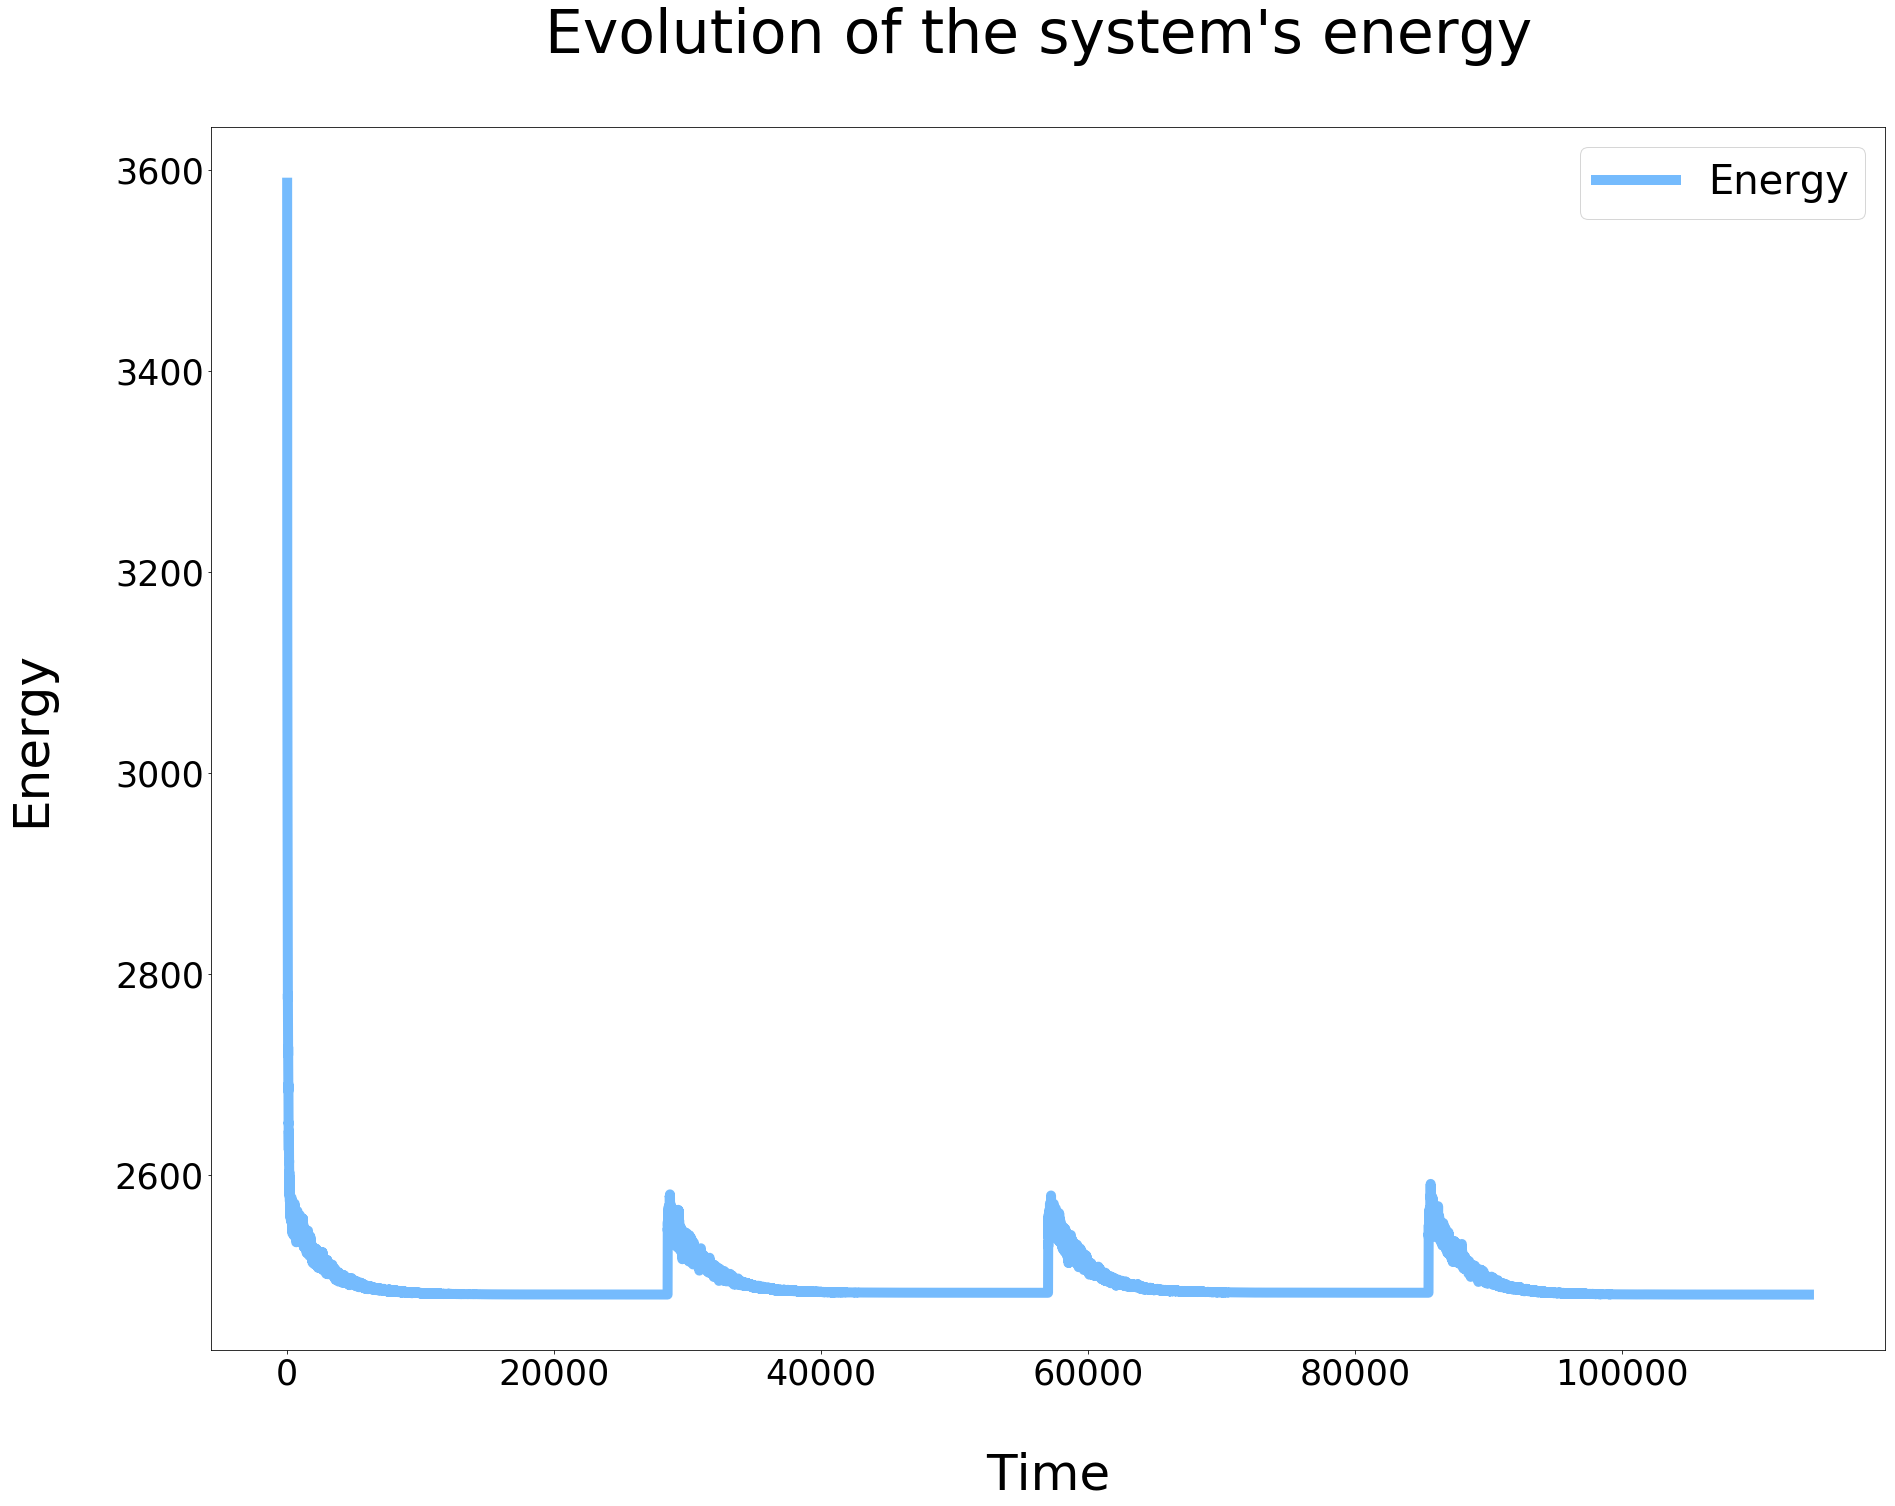

5/10 began


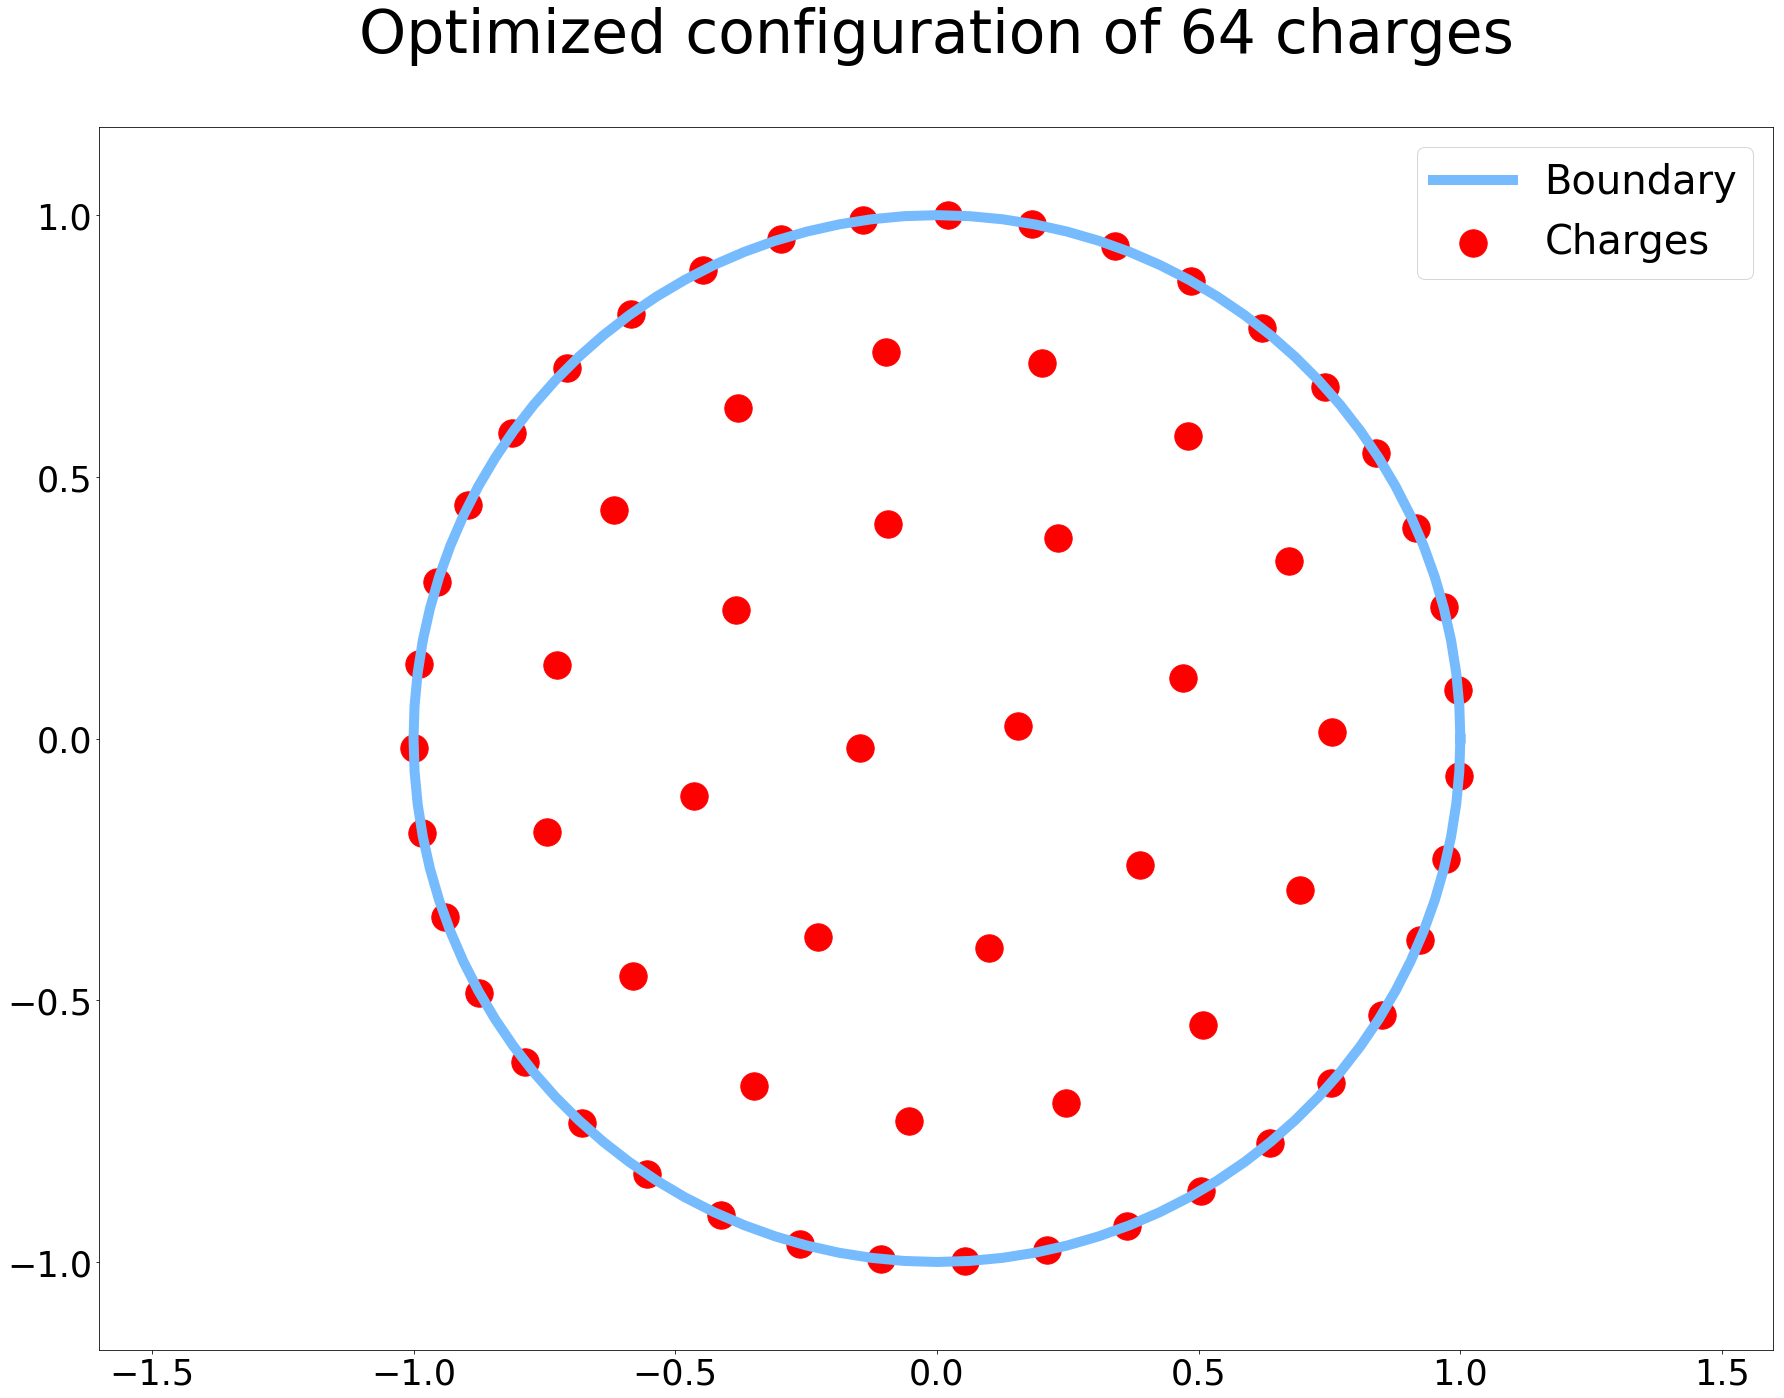

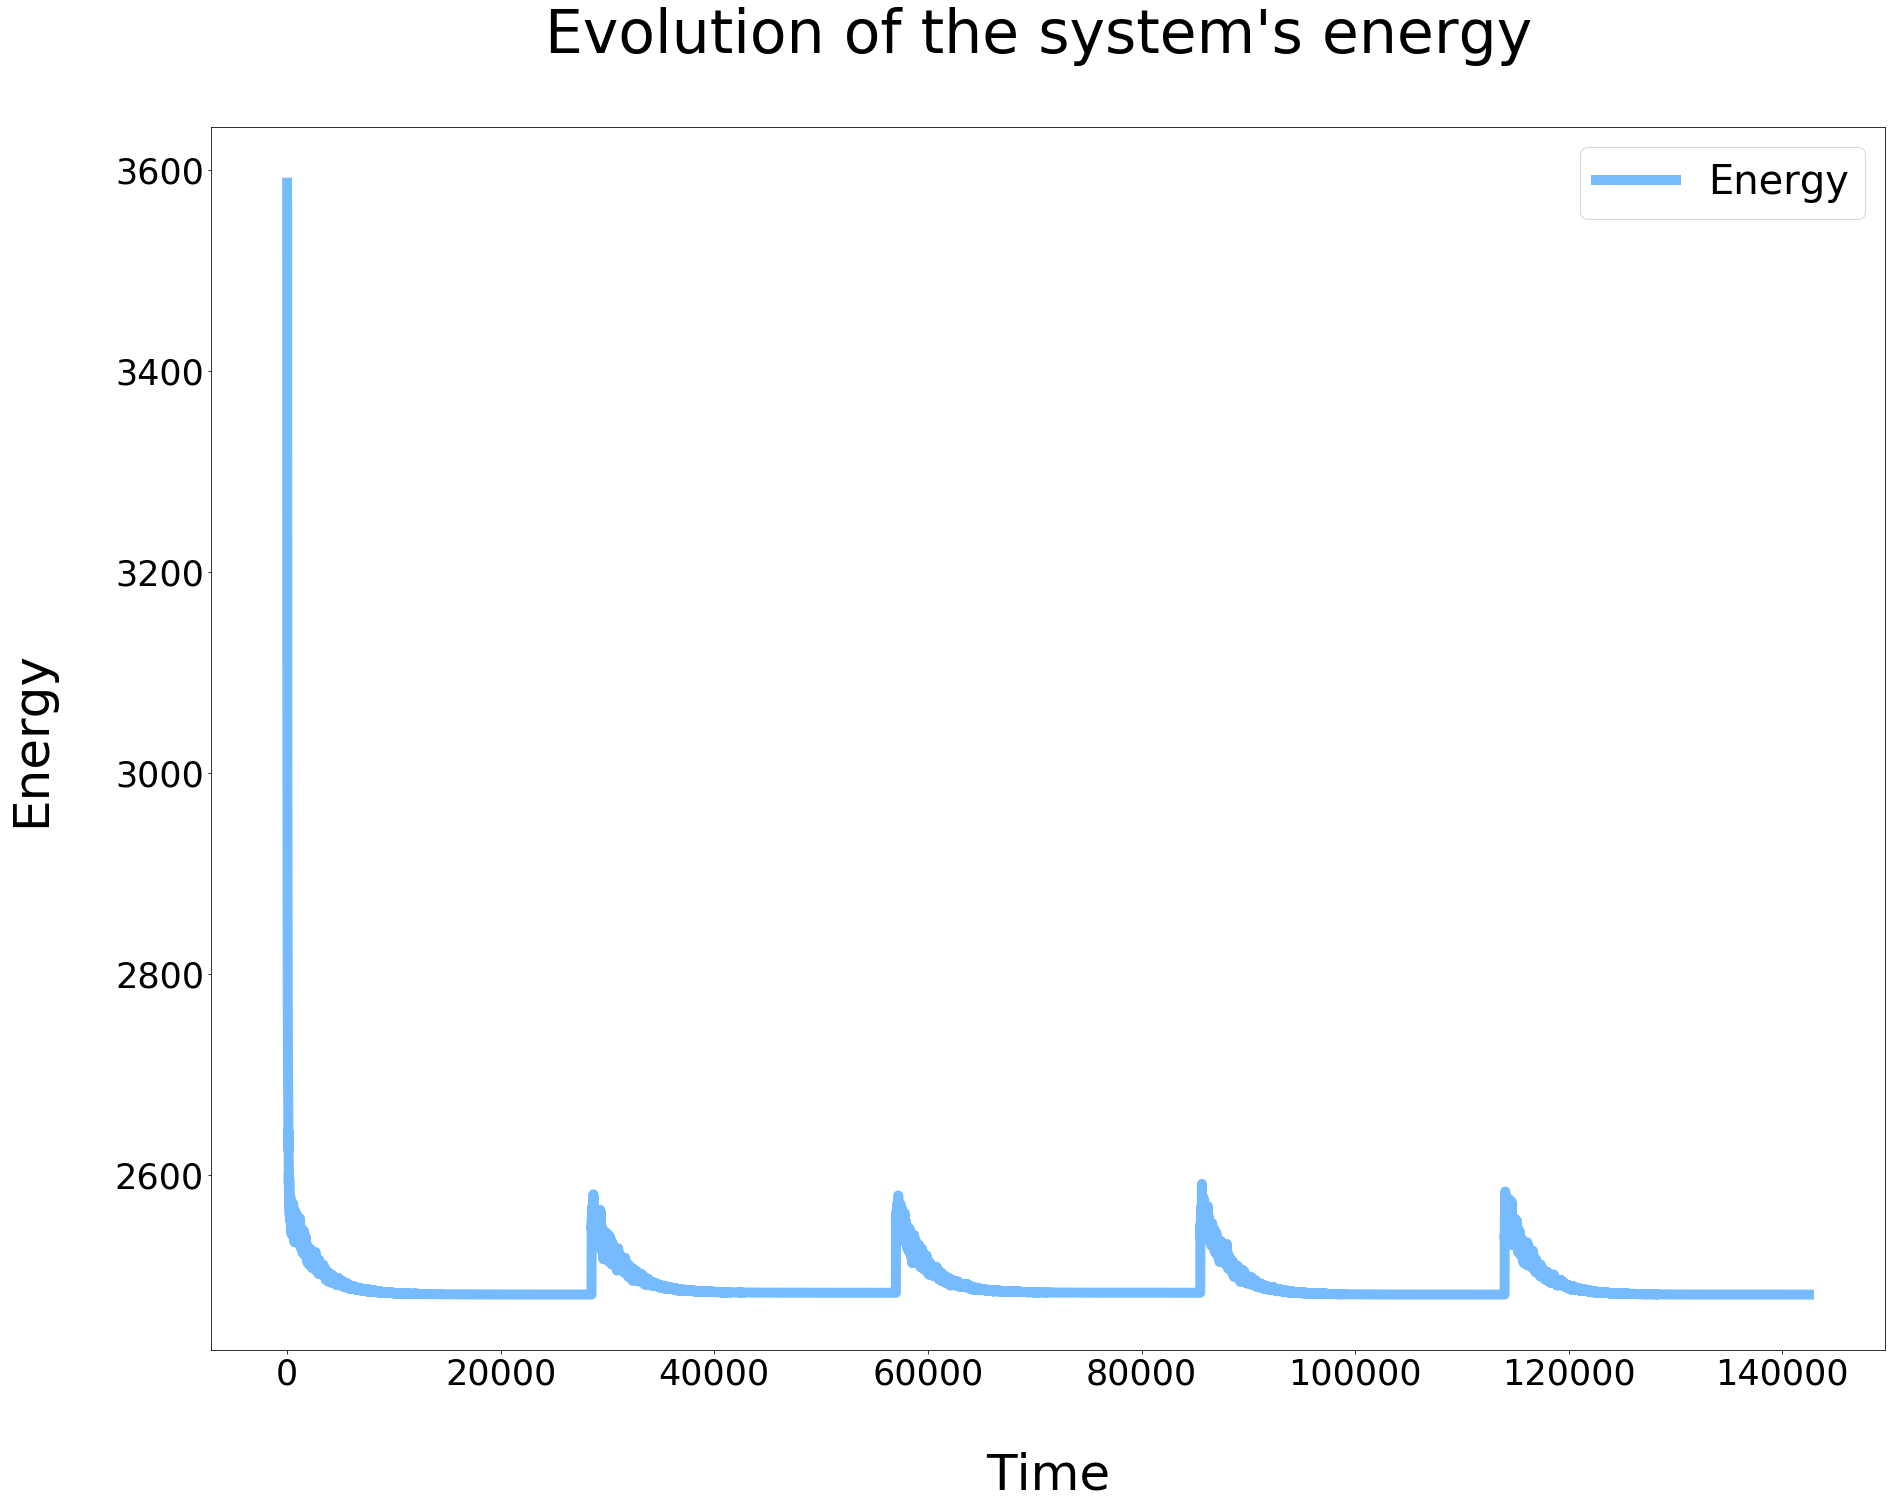

6/10 began


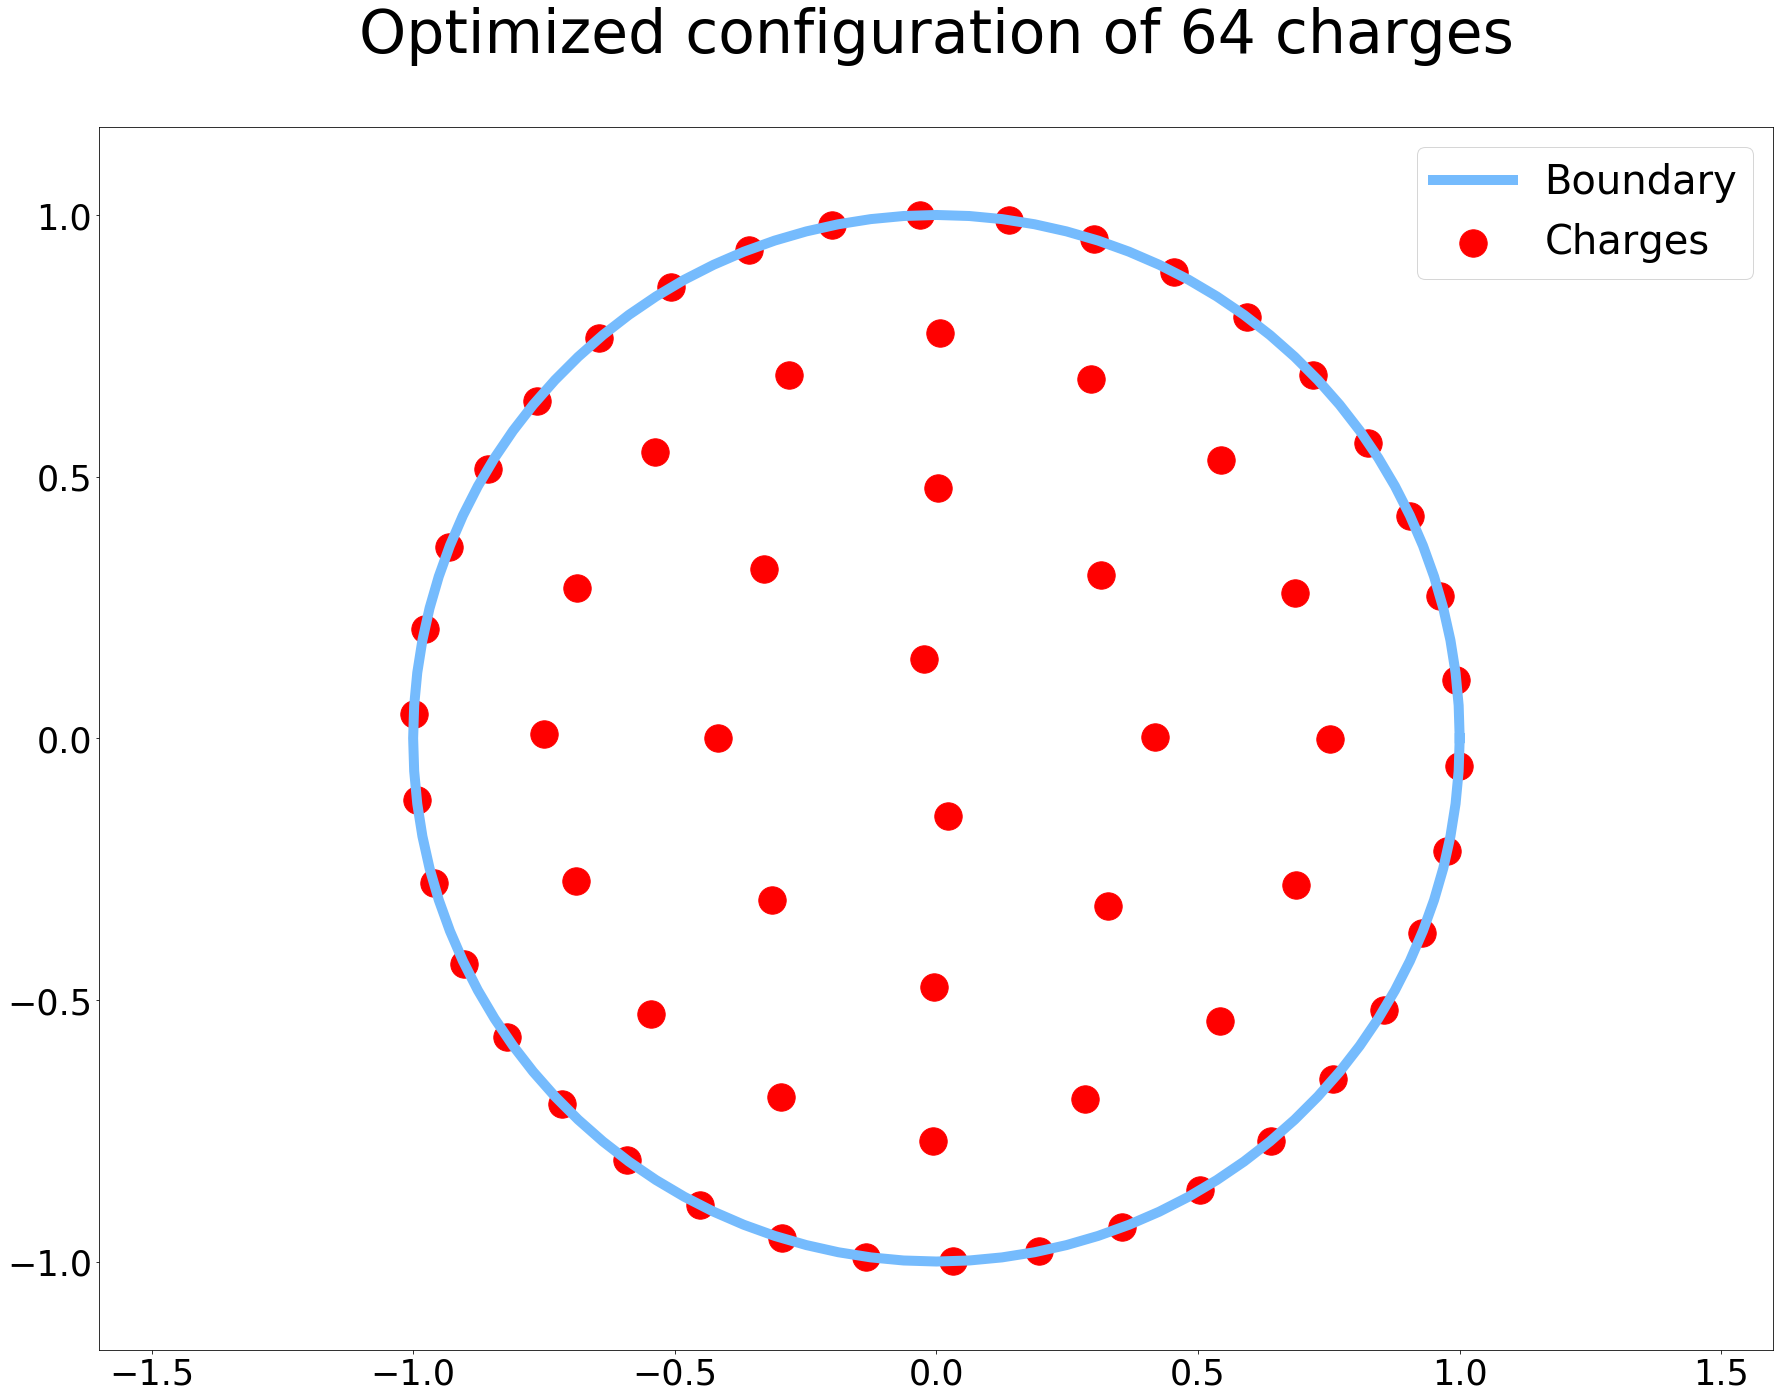

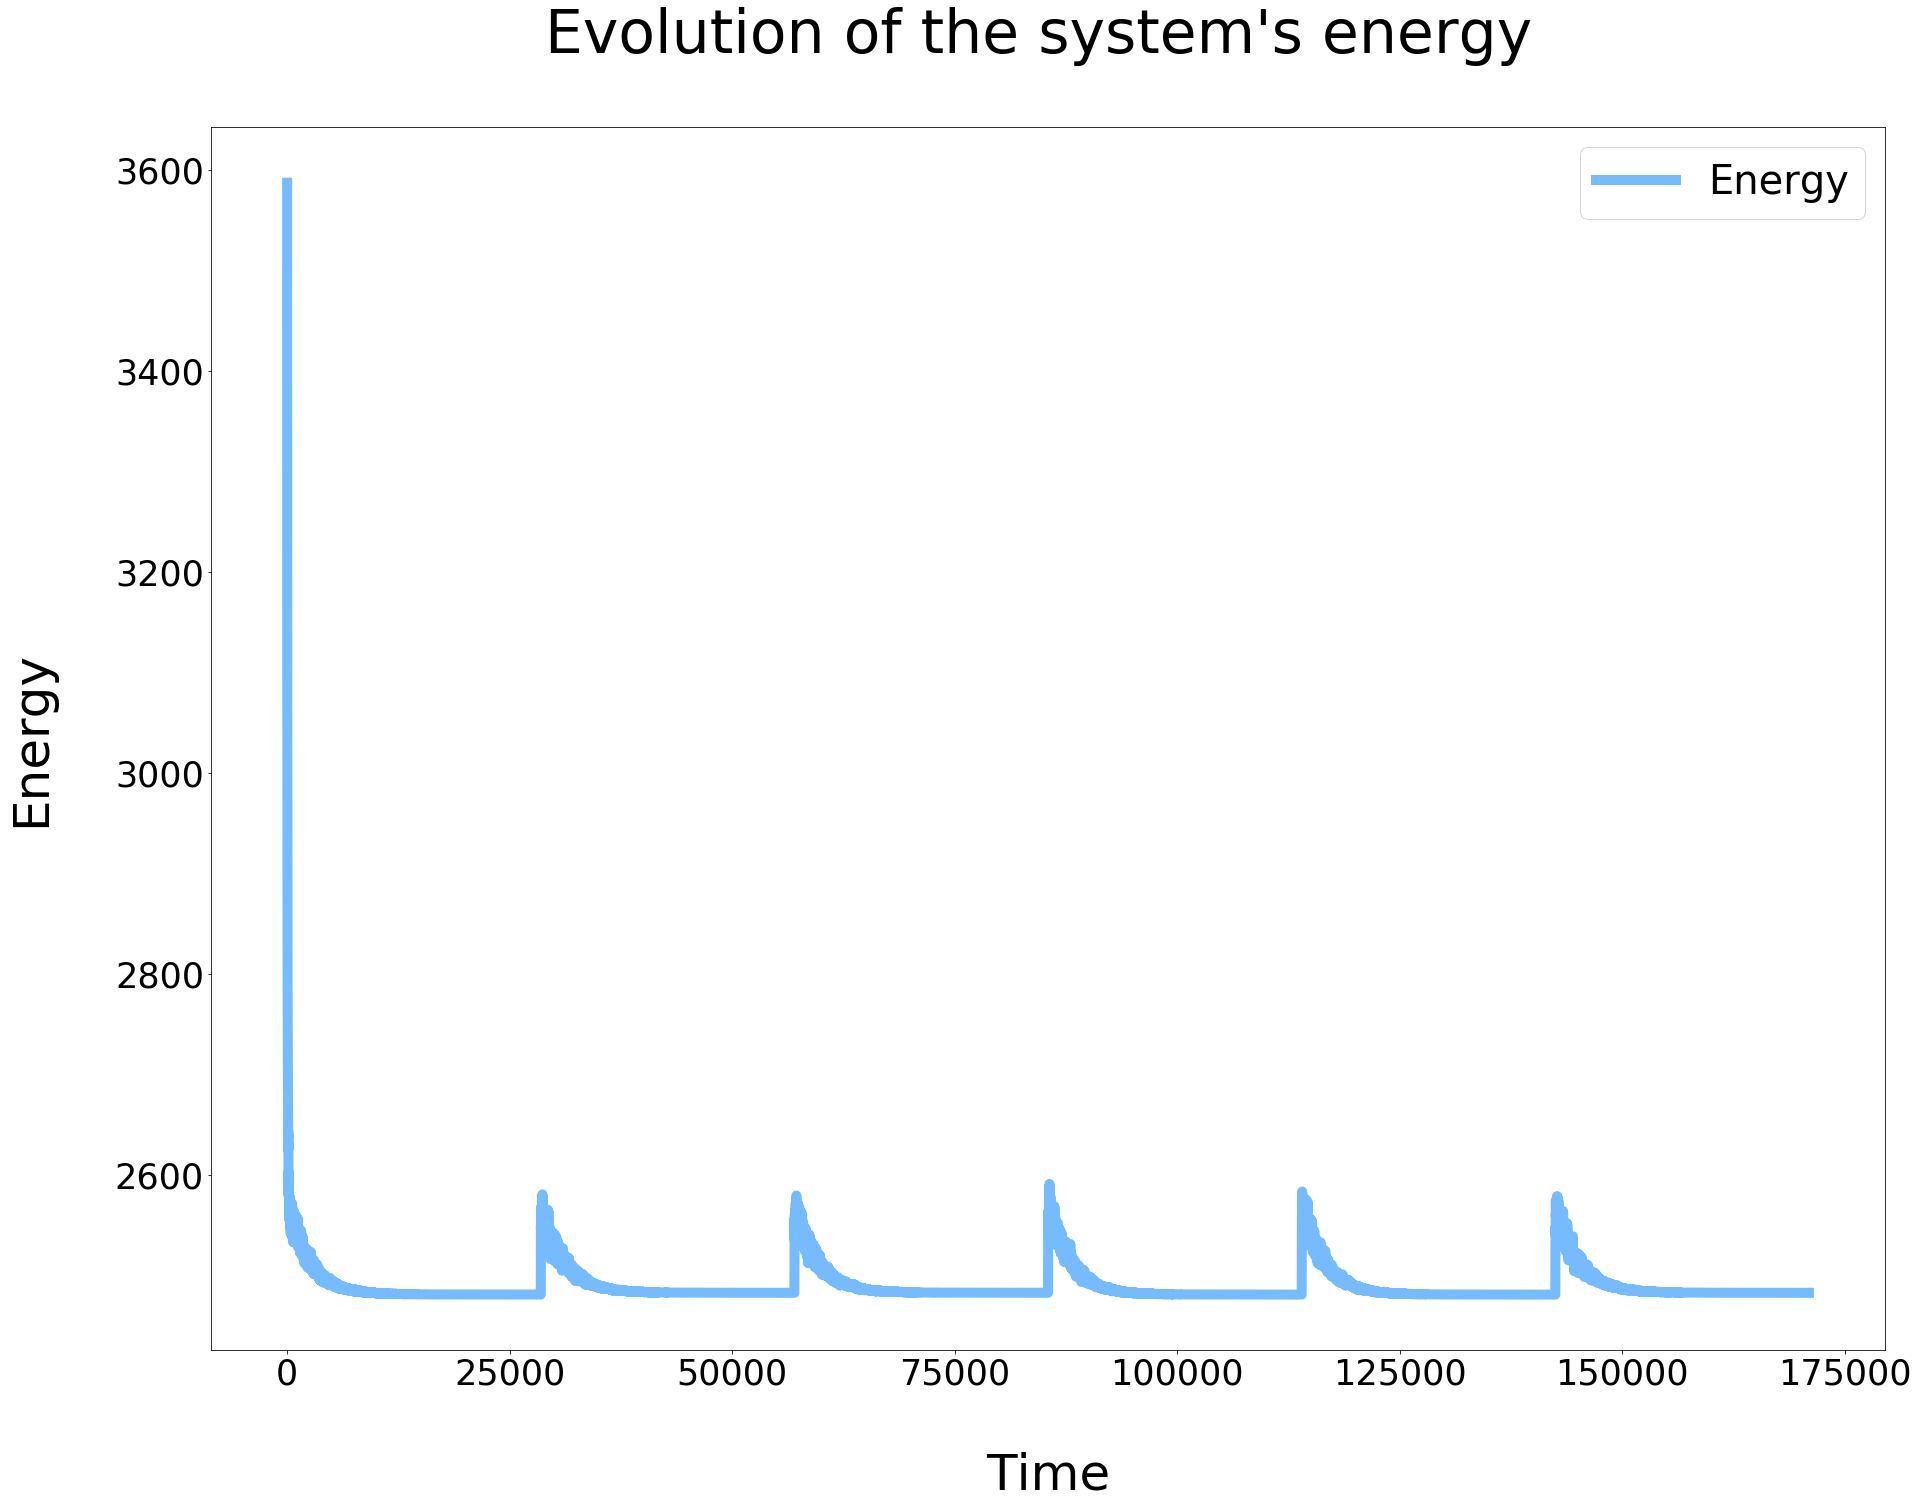

7/10 began


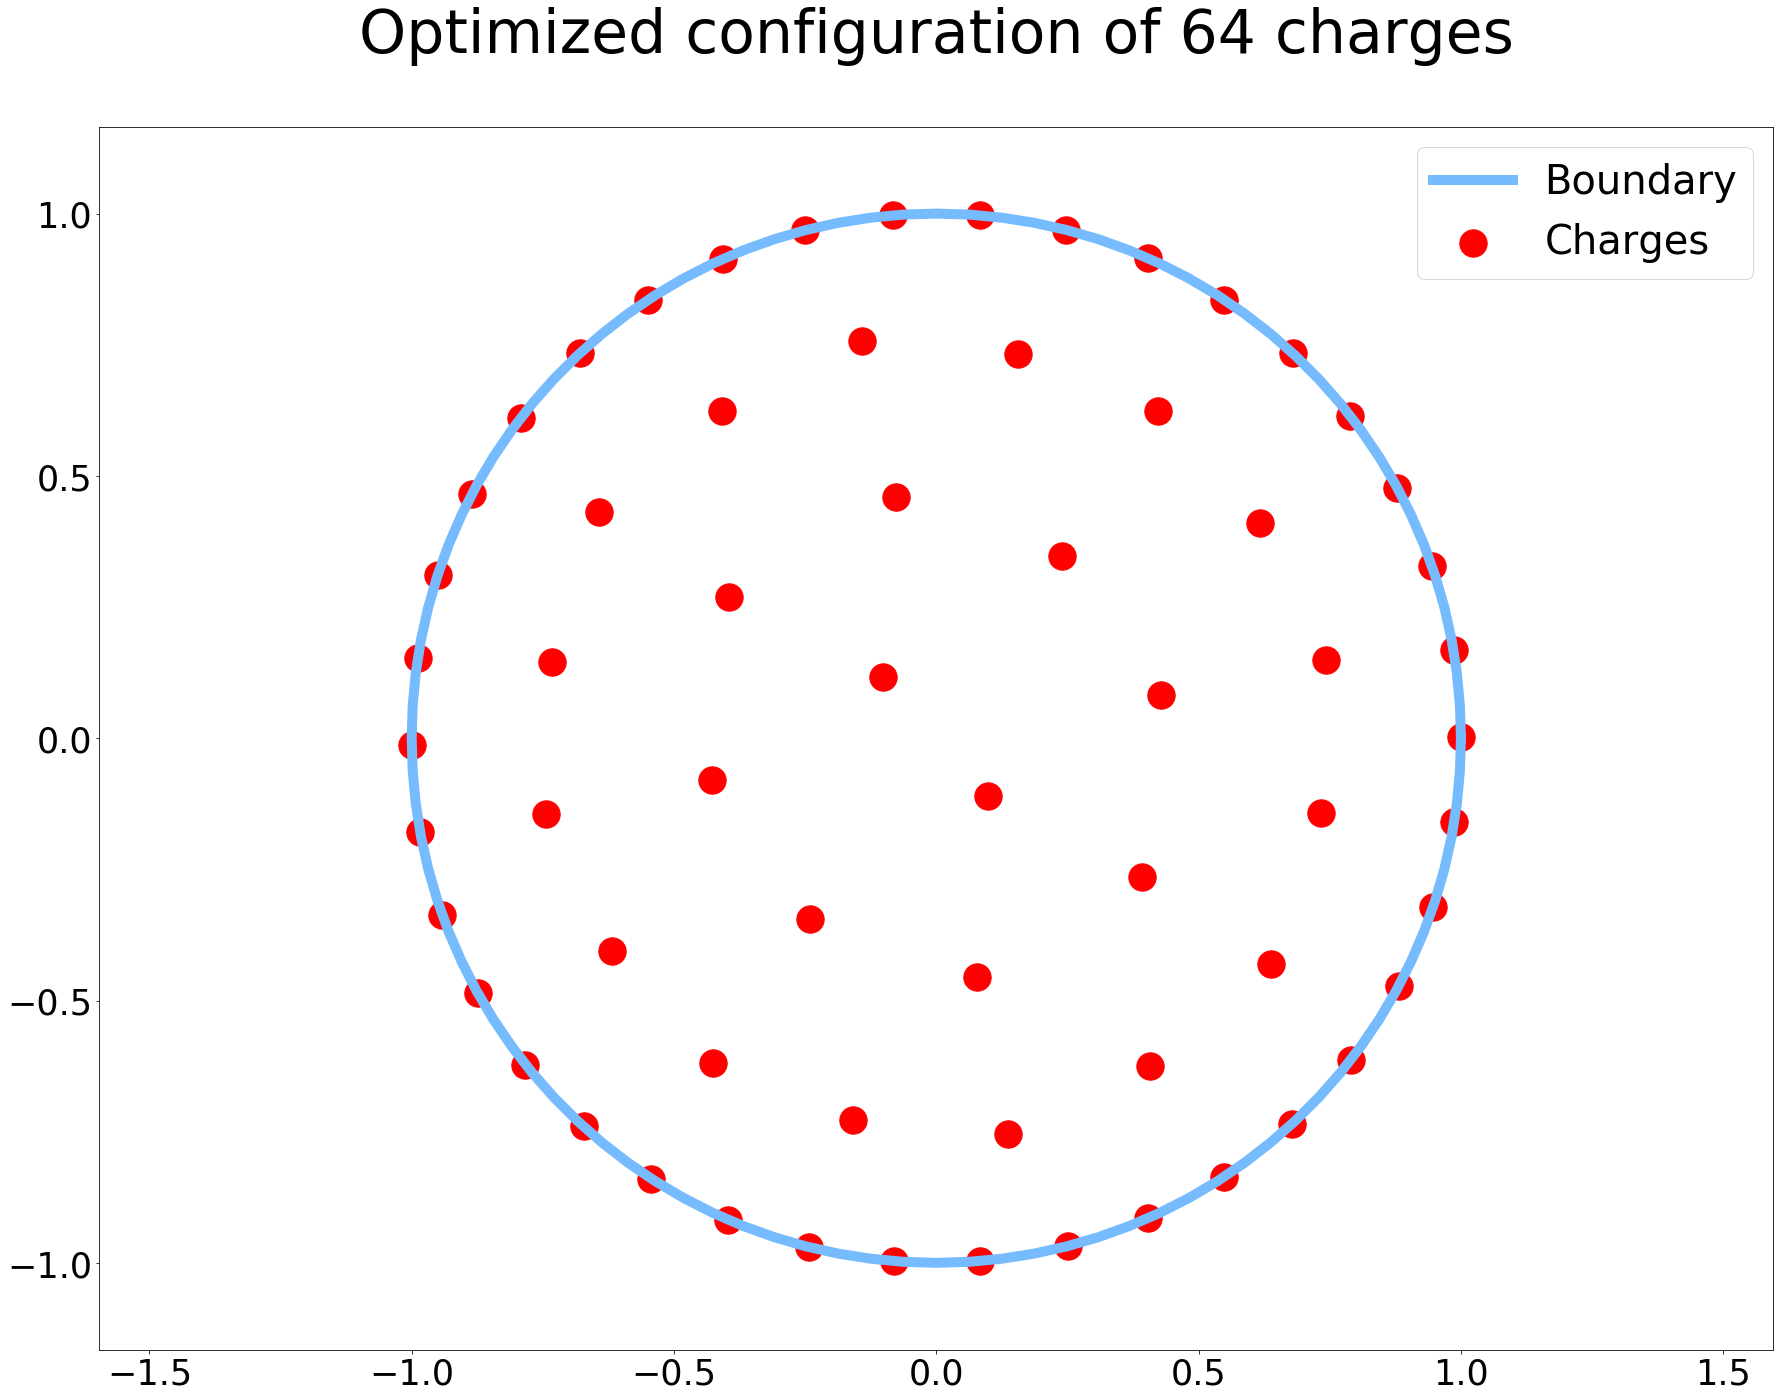

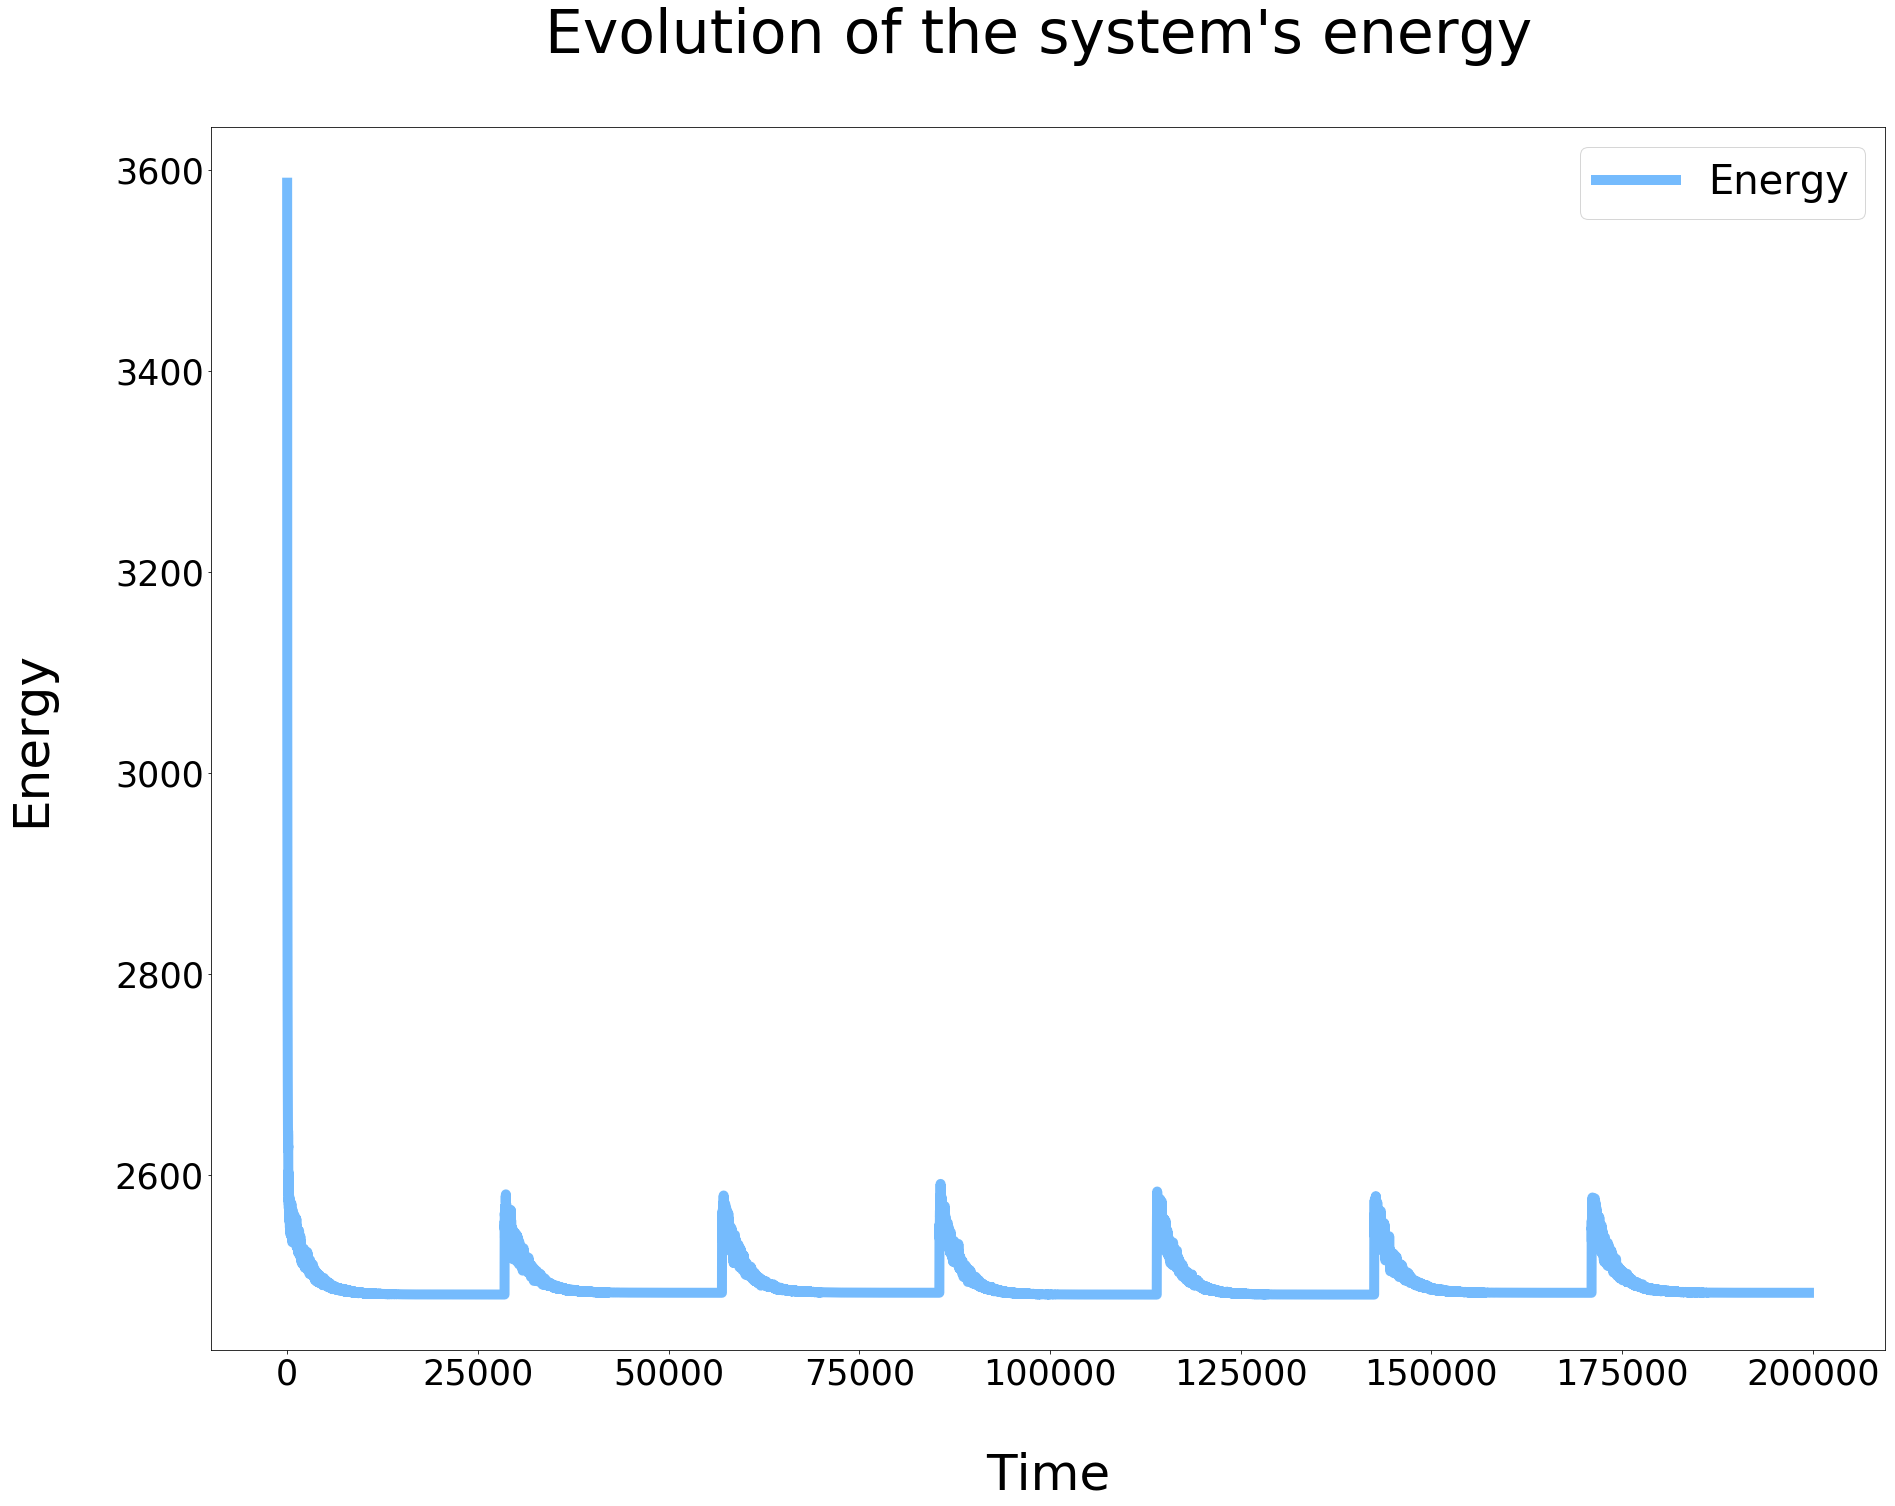

8/10 began


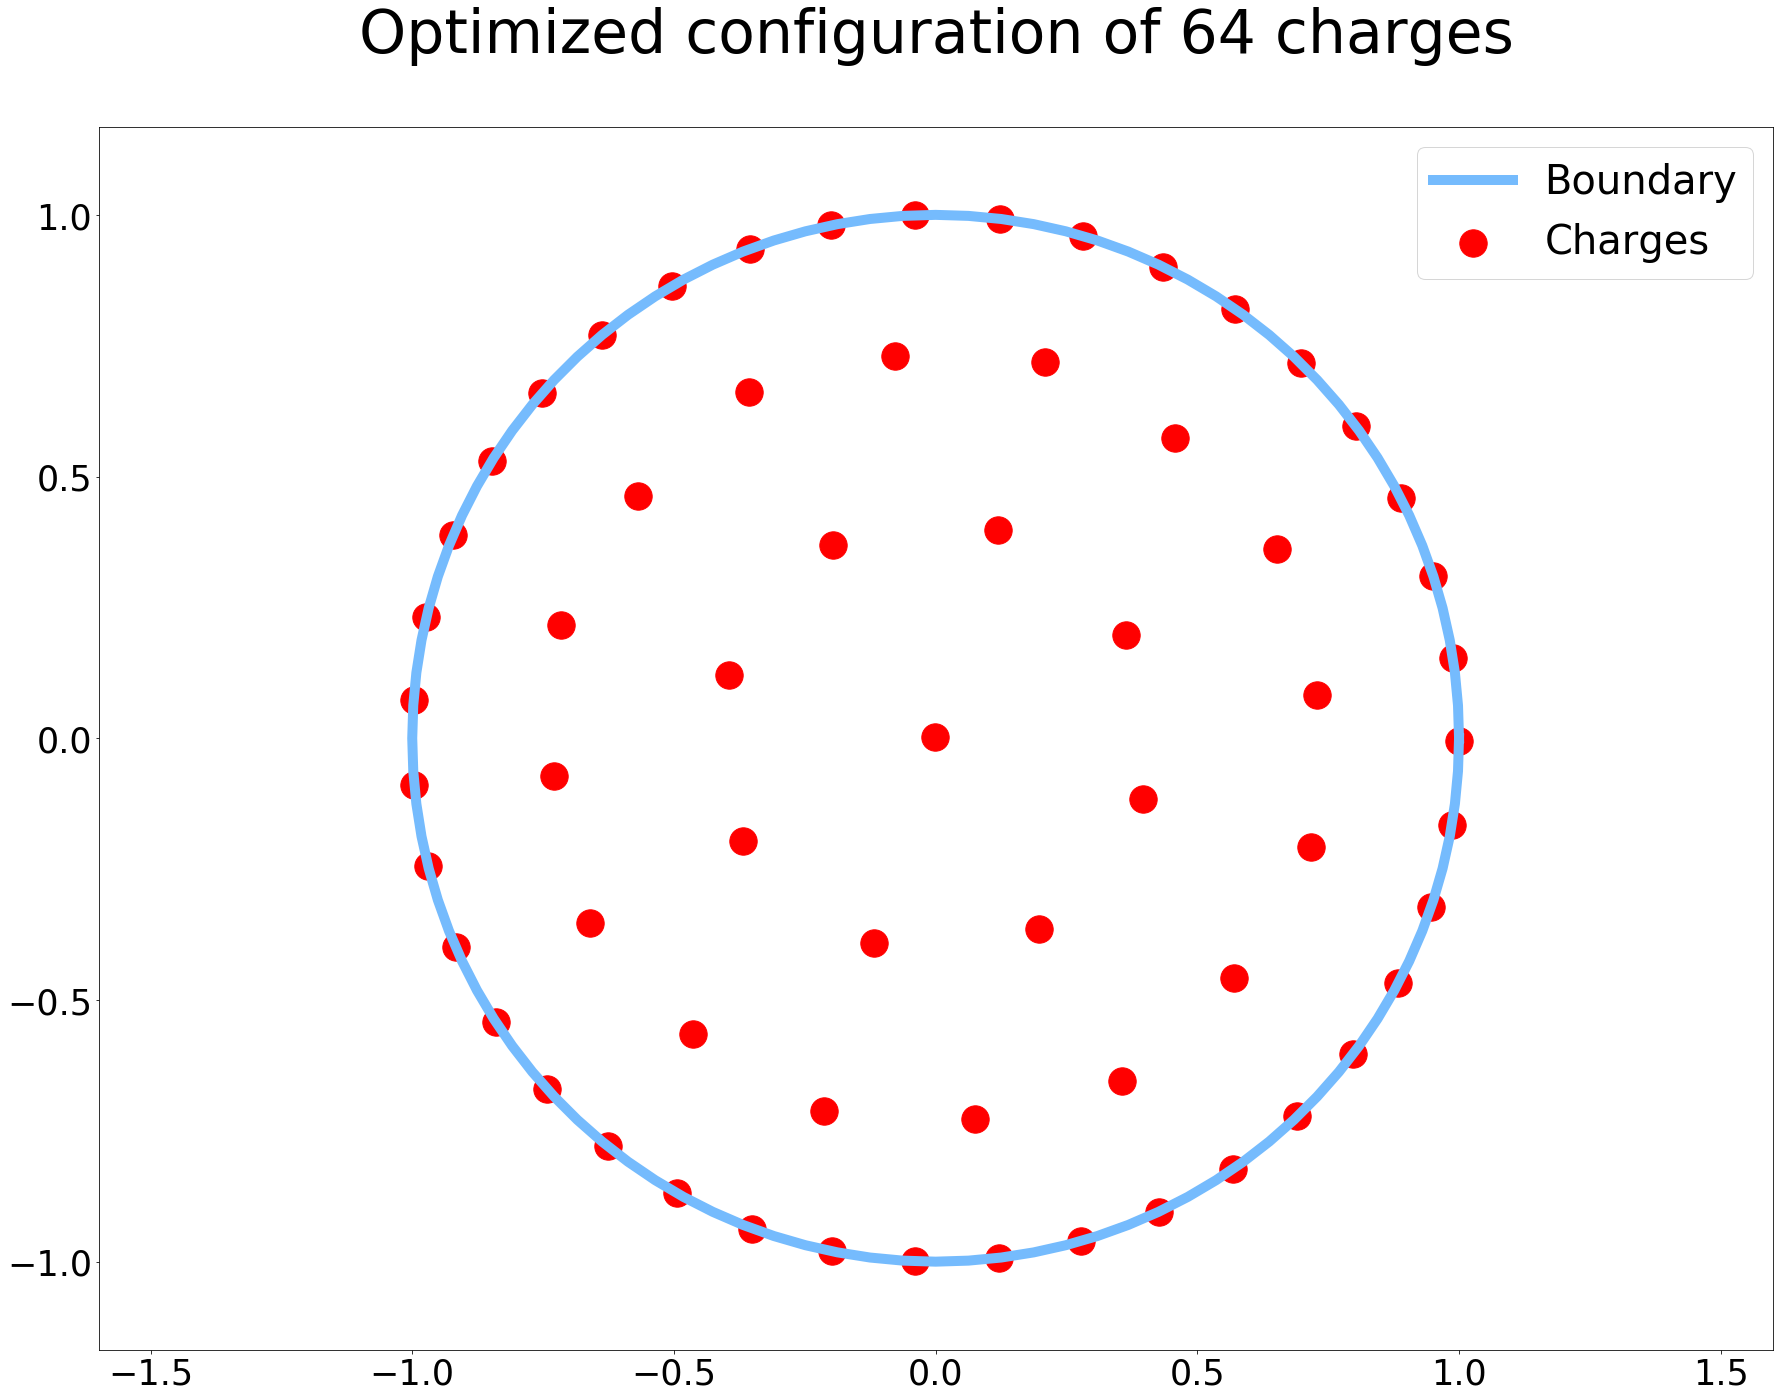

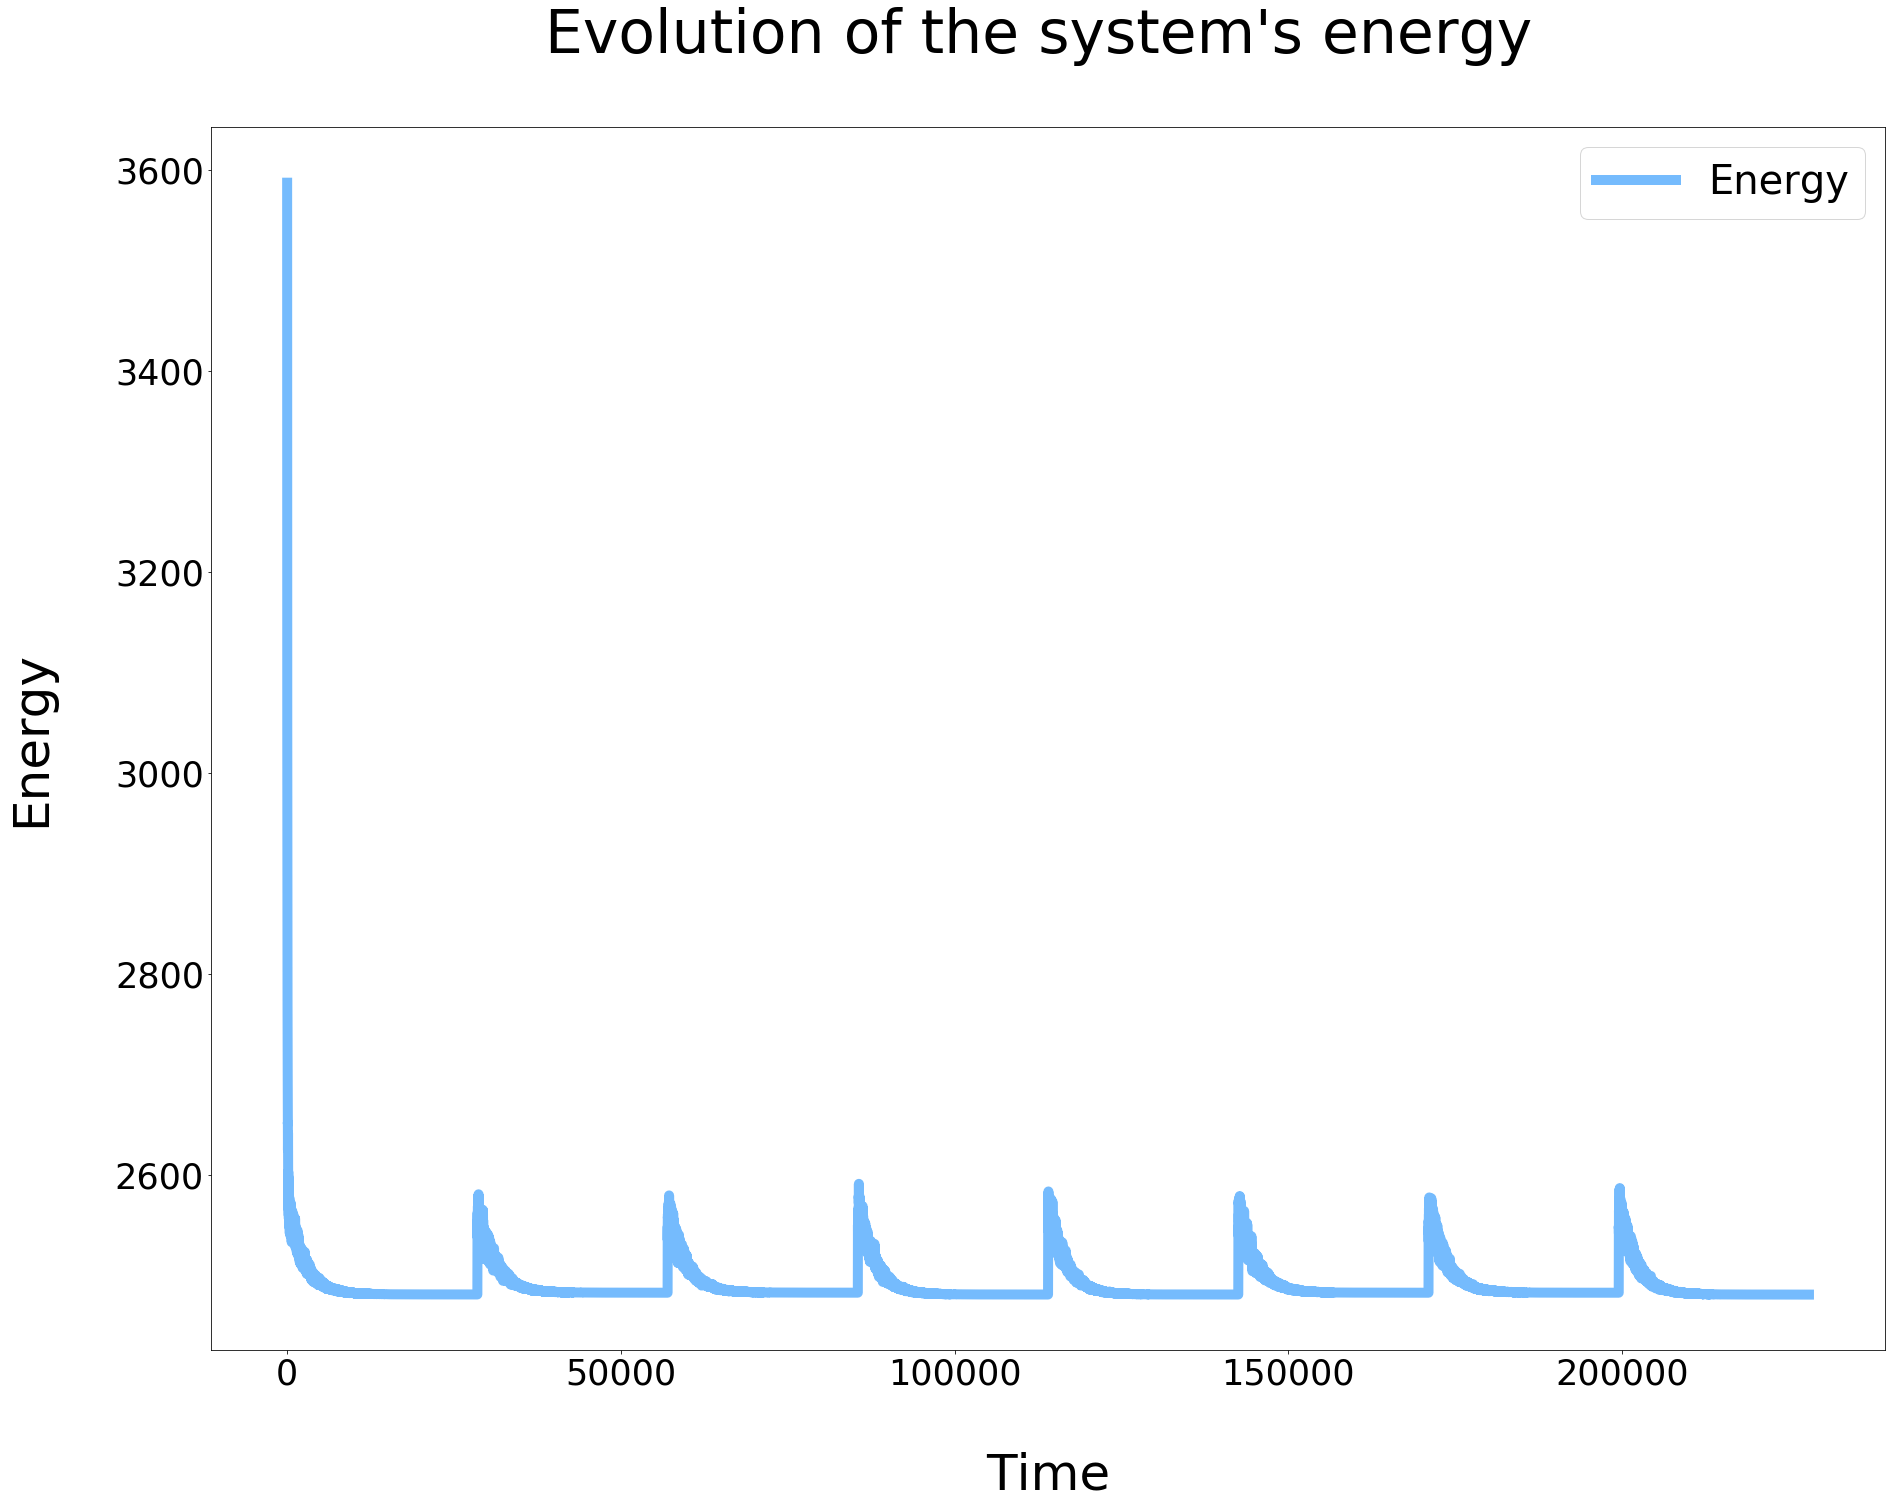

9/10 began


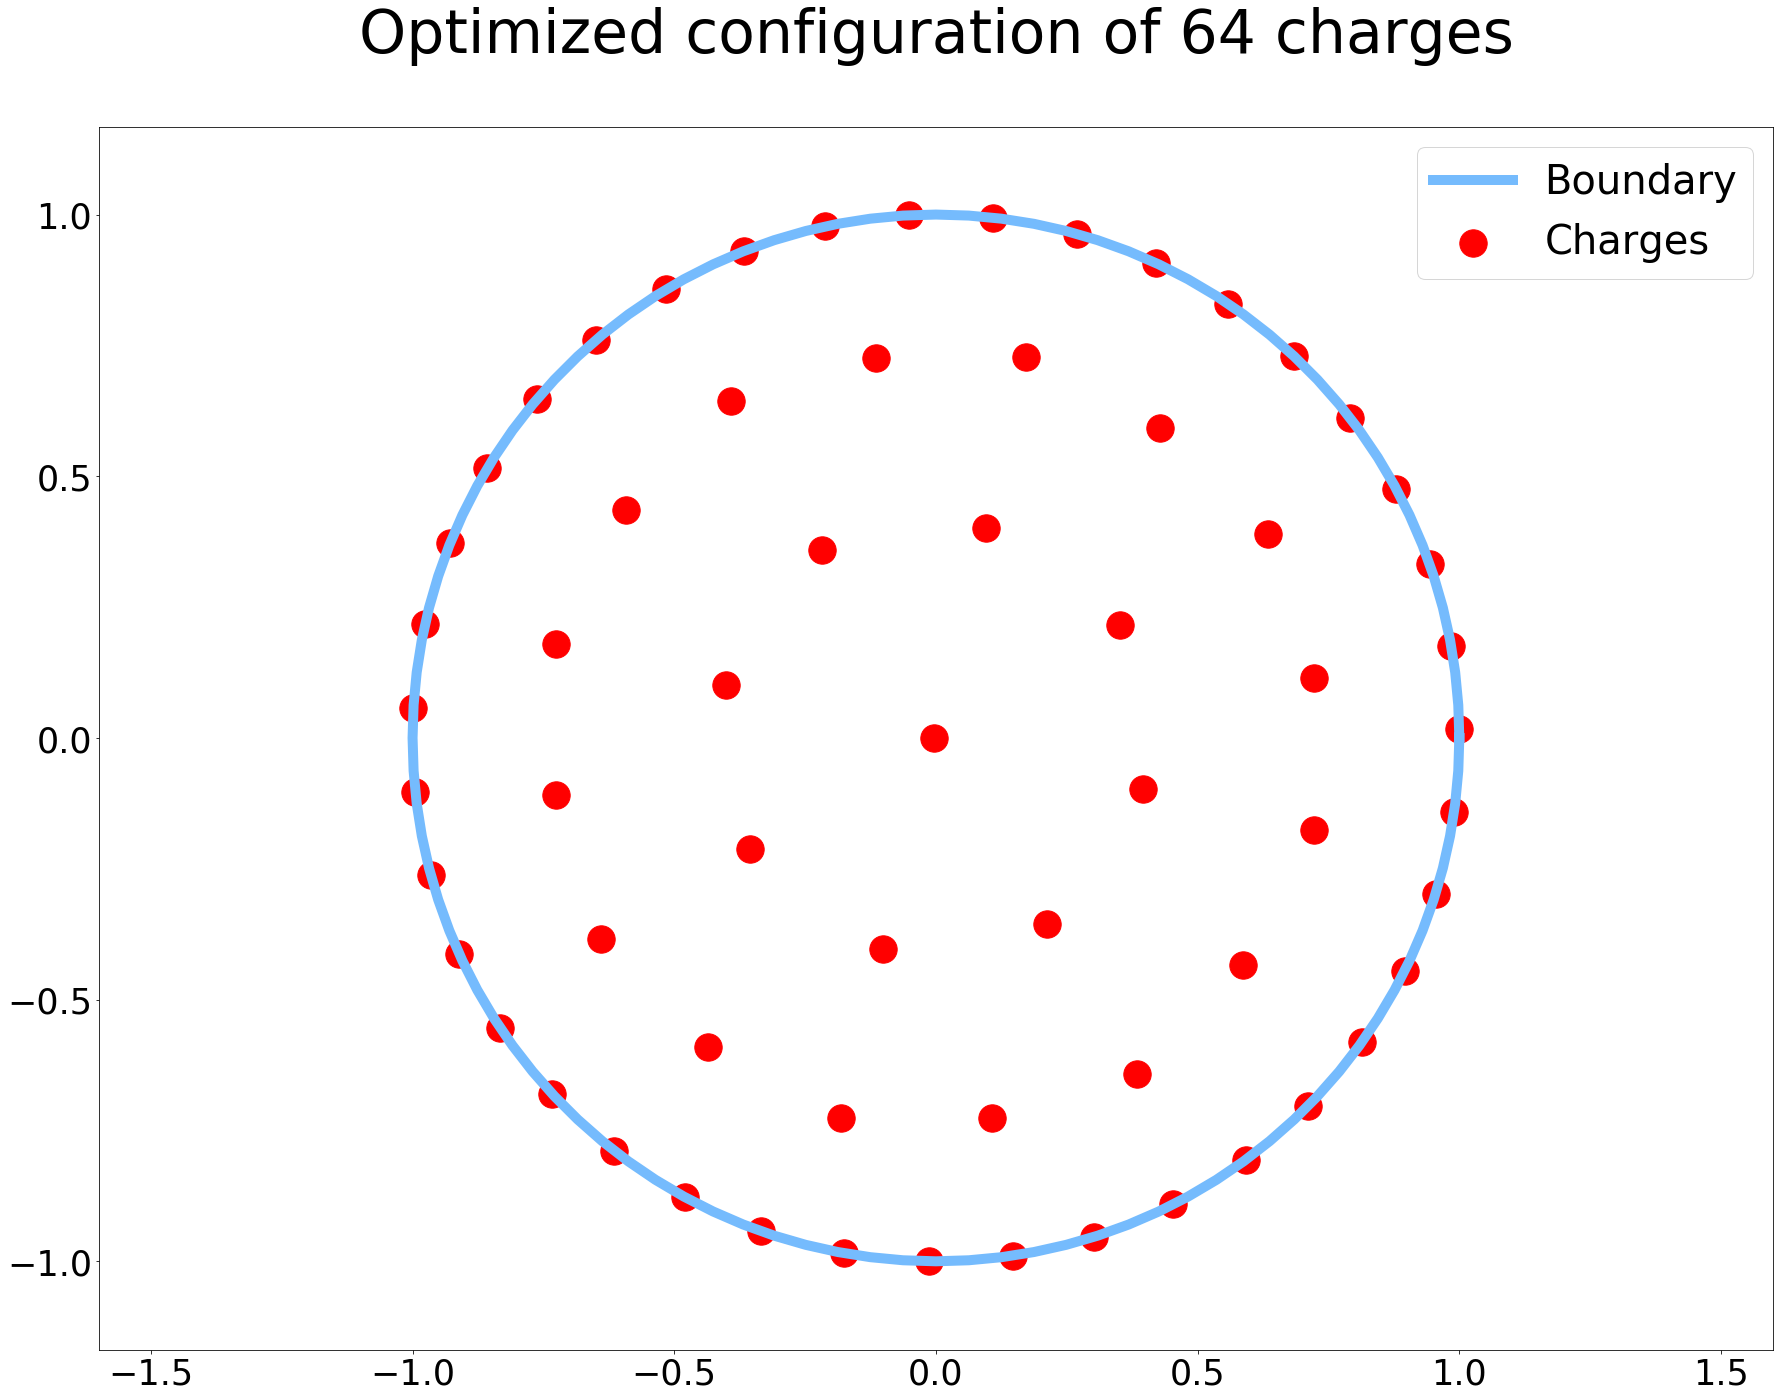

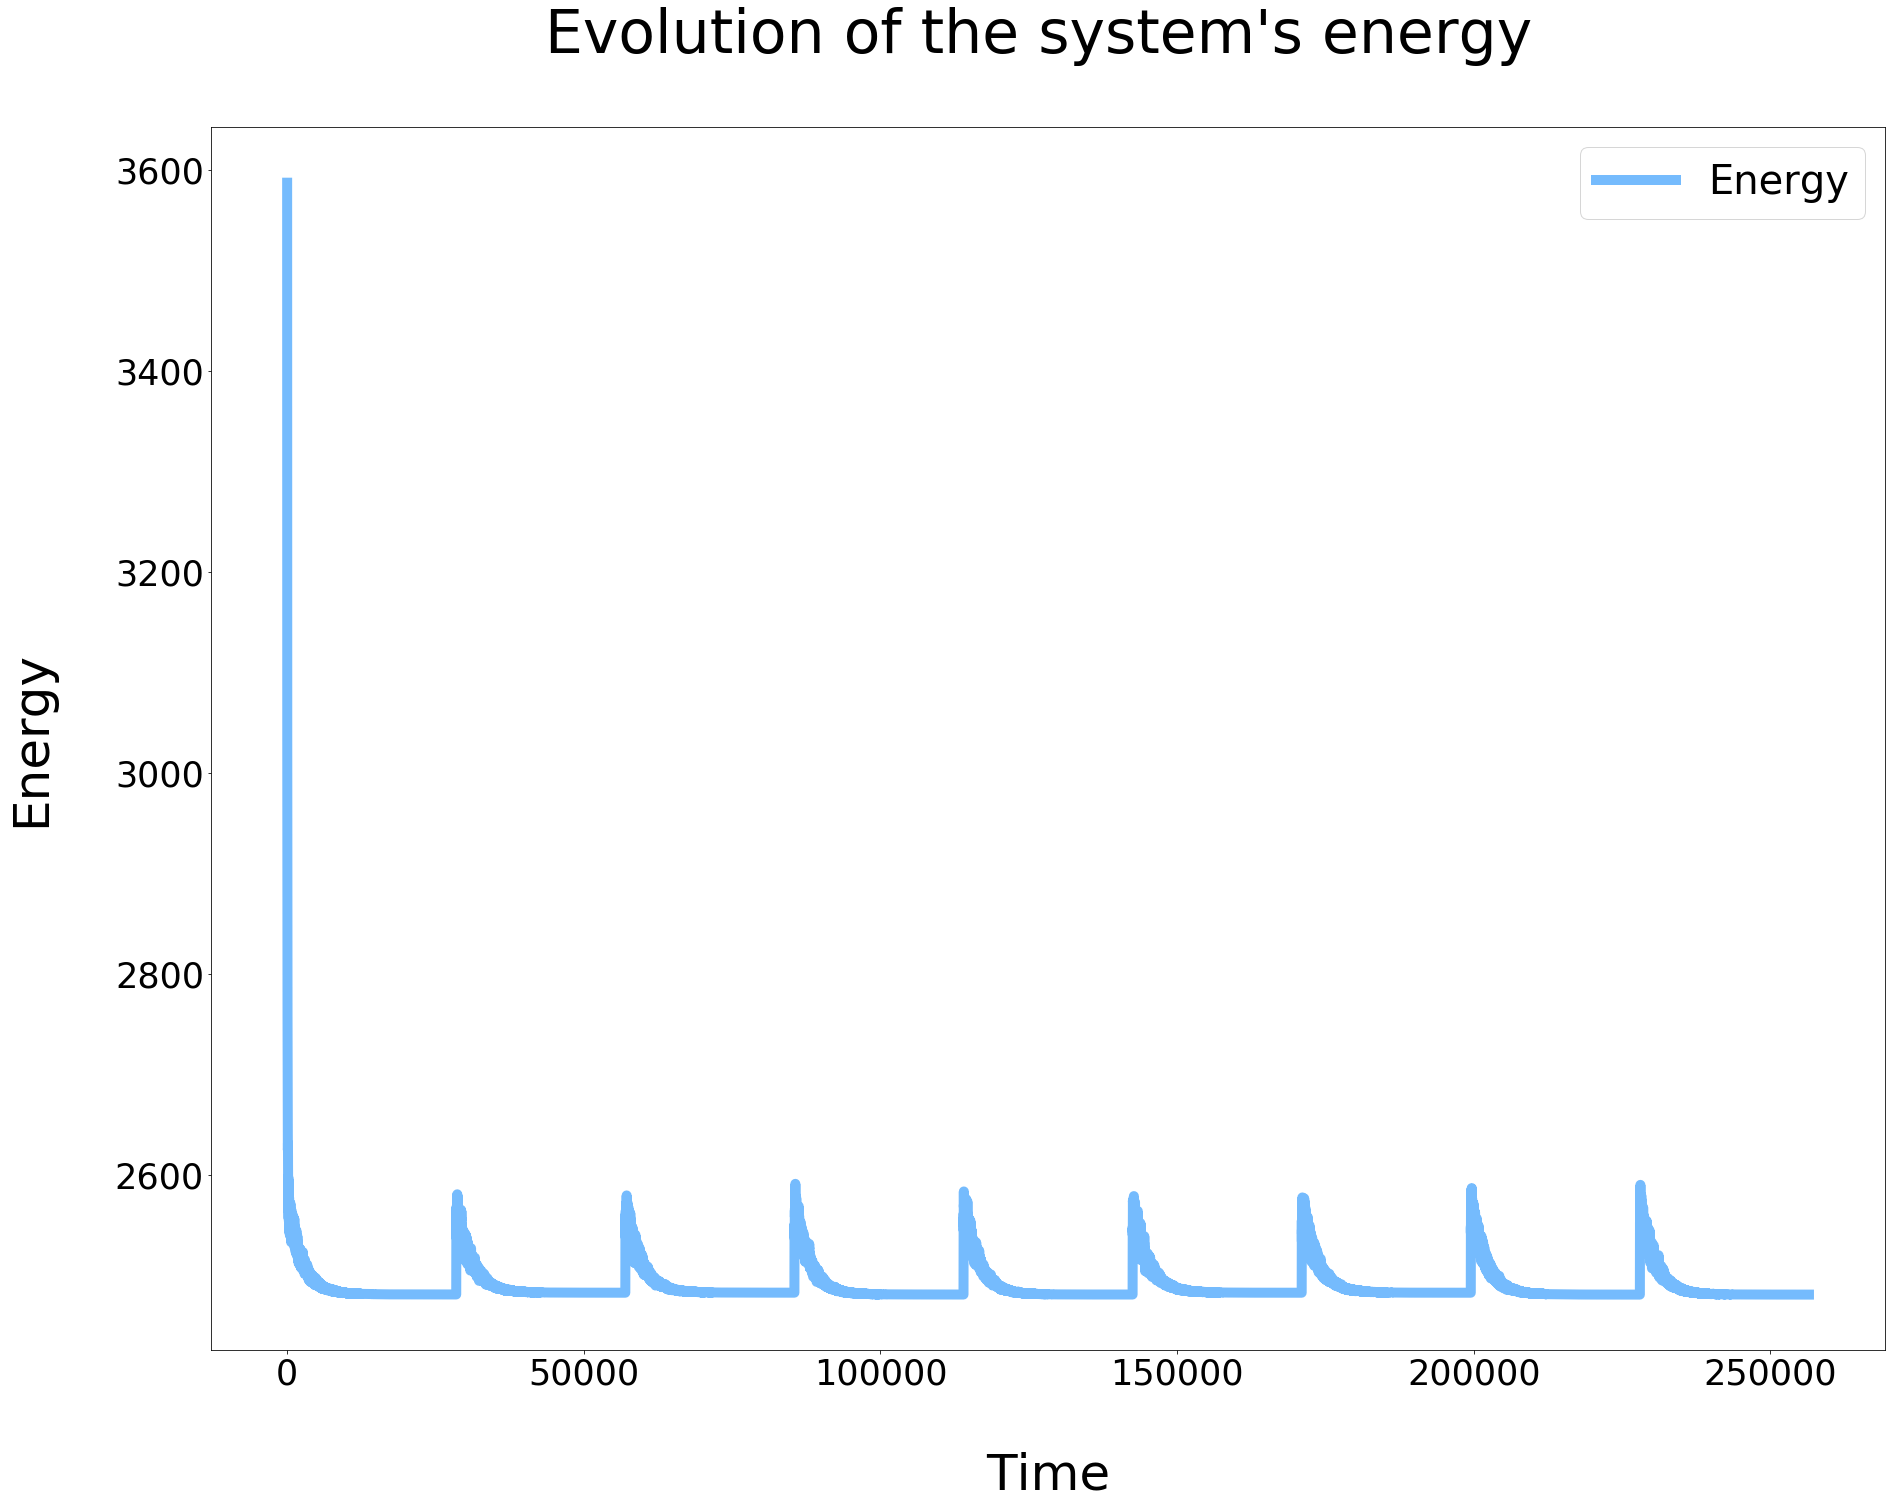

10/10 began


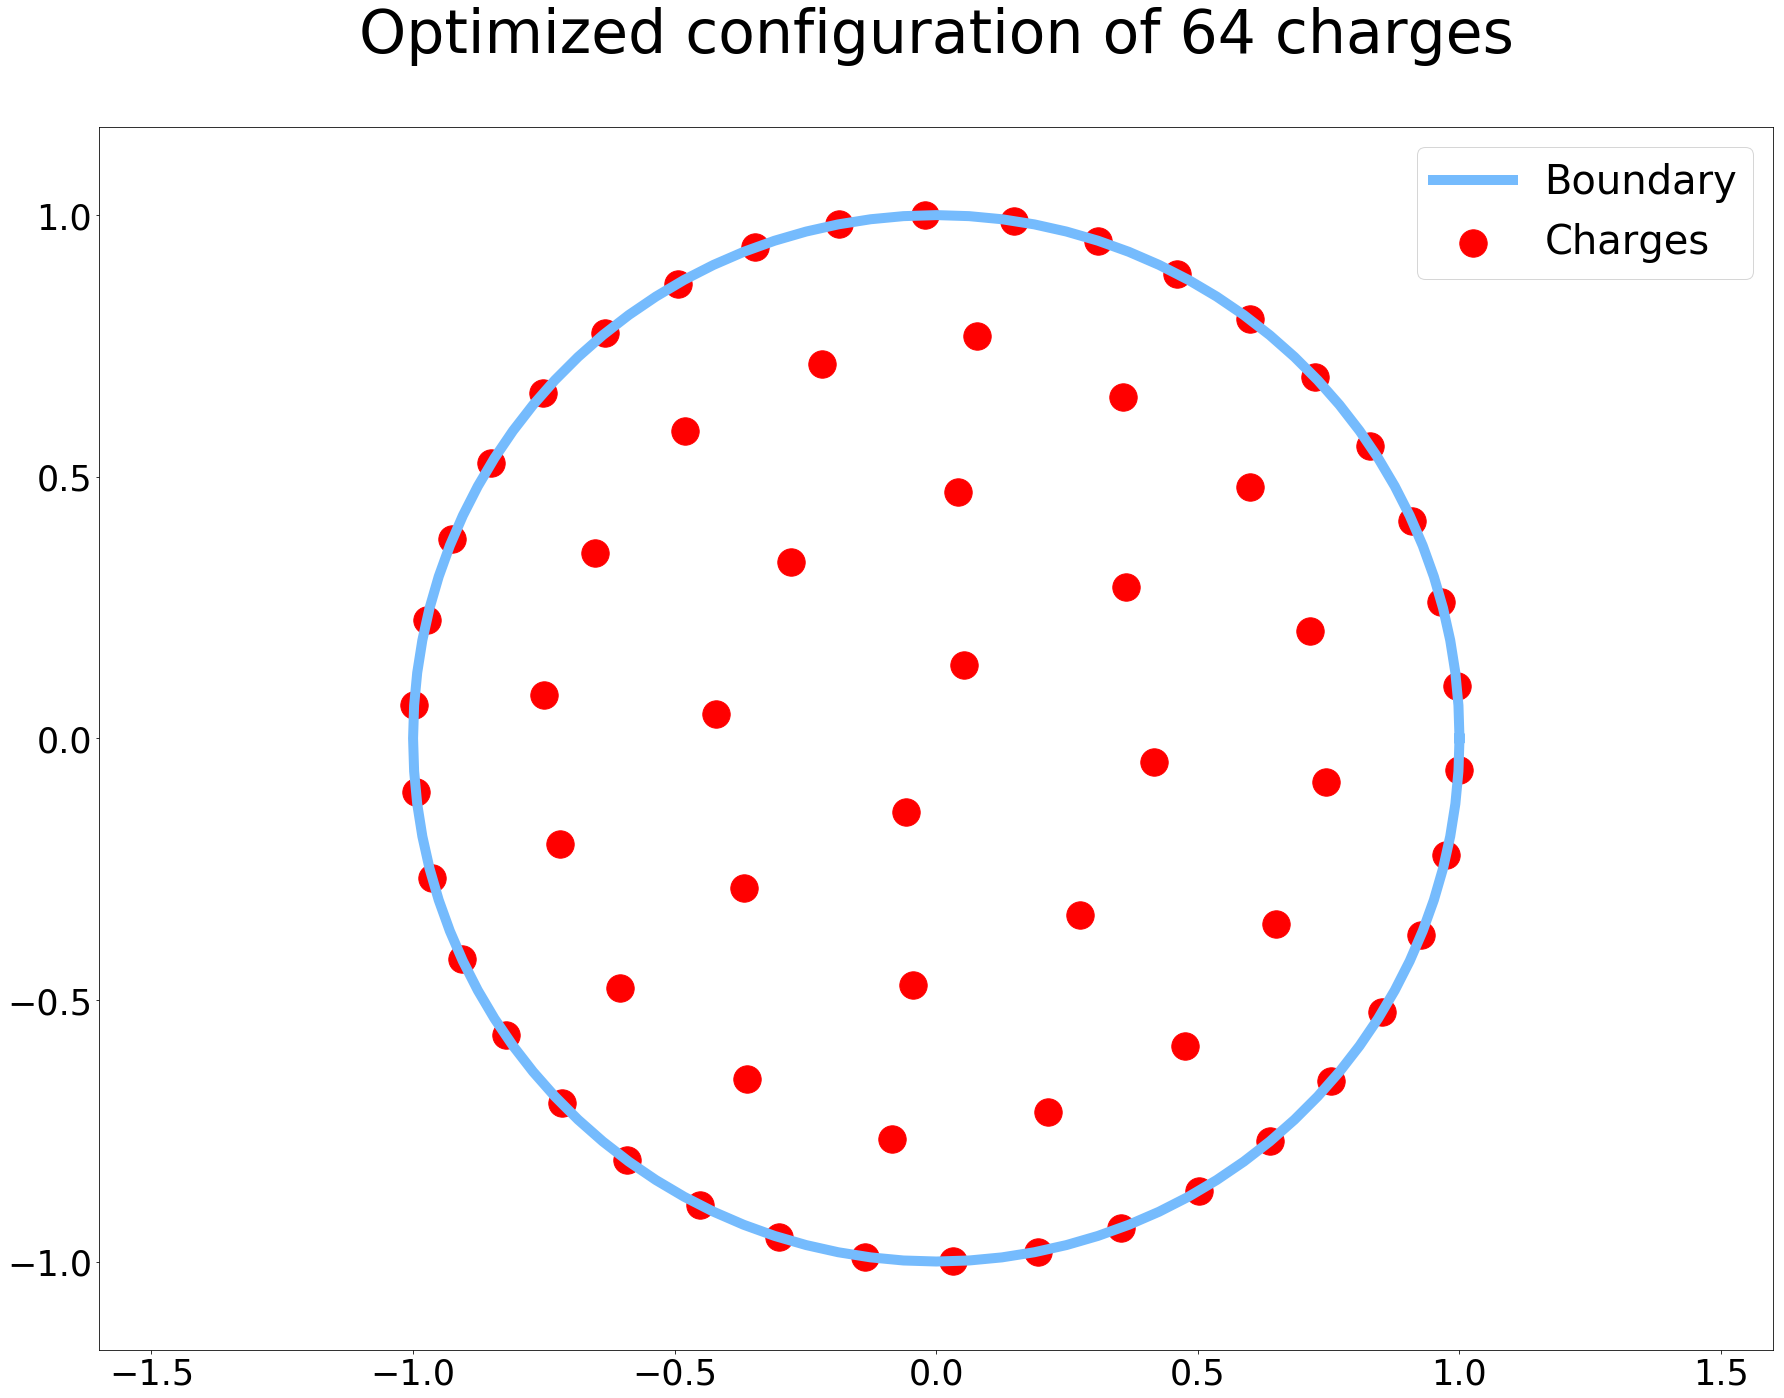

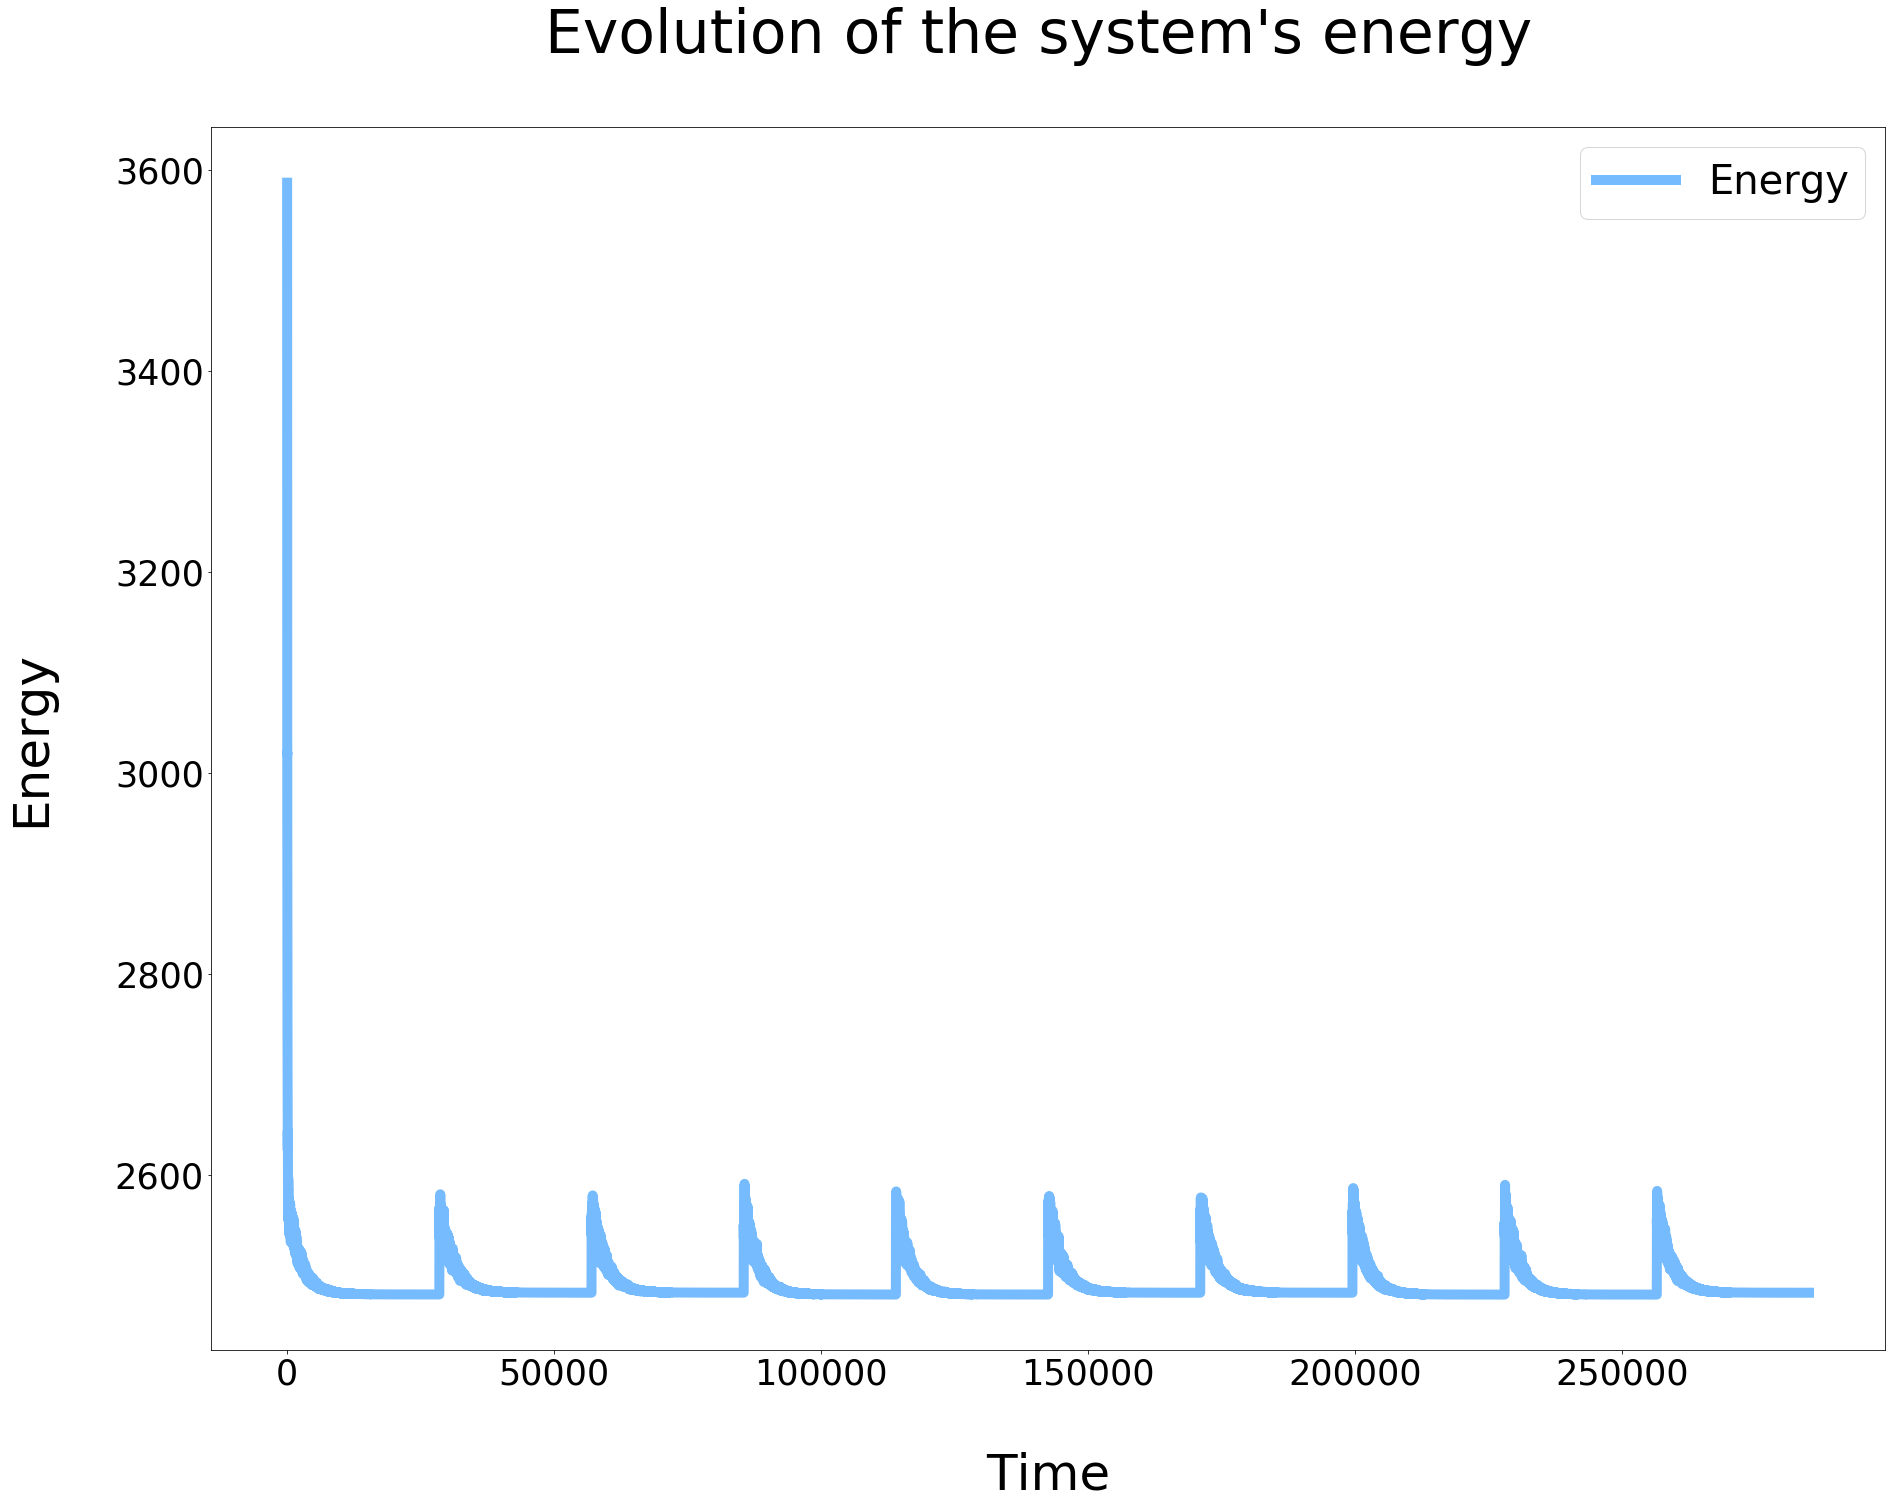

In [21]:
minima = mutliple_annealing(64, 10, 1., 0.98, 50, 'circle')

In [22]:
minima

[2480.9623571614829,
 2482.6989781438342,
 2482.7392323483964,
 2480.8930283819586,
 2480.8986785995967,
 2482.6884139697909,
 2482.6942336295106,
 2480.8189434406127,
 2480.8218909081329,
 2482.6941376182394]

In [25]:
np.round(minima,3)

array([ 2480.962,  2482.699,  2482.739,  2480.893,  2480.899,  2482.688,
        2482.694,  2480.819,  2480.822,  2482.694])

In [26]:
def save_now(annealer, file_name):  
  def save_energies(energies, file_name):
      plt.clf()
      plt.plot(range(len(energies)), energies, c='xkcd:sky blue', linewidth=10, label="Energy")
      plt.legend(fontsize='40')
      plt.xlabel('\nTime', fontsize='50')
      plt.ylabel('Energy\n', fontsize='50')
      plt.title('Evolution of the system\'s energy \n', fontsize='60')
      plt.gcf().set_size_inches(30, 22.5)
      plt.tick_params(axis='both', which='major', labelsize=35)
      plt.savefig(f'Results/{file_name}.pdf')
      plt.show()
  energies_temp = annealer.energies[10:]
  save_energies(energies_temp, file_name)